# Configuration

In [37]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/camilalobianco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
movies=pd.read_csv('resources/tmdb_5000_movies.csv')
credits=pd.read_csv('resources/tmdb_5000_credits.csv')
rating = pd.read_csv('resources/ratings_small.csv')

# Functions

In [39]:
def convert_json_to_list(data):
    """
    Converts a JSON string or list to a Python list.

    Input:
    - data (str or list): JSON string or list to be converted.

    Output:
    - list: A Python list representation of the input data.
    """

    if isinstance(data, str):
        try:
            return json.loads(data)
        except json.JSONDecodeError:
            return []
    
    elif isinstance(data, list):
        return data
    
    return []

def adjust_df(movies):

    """
    Adjusts the movies DataFrame by extracting and organizing specific information.

    Input:
    - movies (DataFrame): DataFrame containing movie data.

    Output:
    - DataFrame: Modified DataFrame with additional columns for director, cast, and production details.
    """

    def extract_director_info(crew):

        crew = convert_json_to_list(crew)

        if not isinstance(crew, list):
            return pd.Series([None, None, None])
        
        for member in crew:
            if member['job'] == 'Director':
                return pd.Series([member.get('id', None), member.get('name', None), member.get('gender', None)])
            
        return pd.Series([None, None, None])
    
    def extract_cast_info(cast):

        cast = convert_json_to_list(cast)

        if not isinstance(cast, list):
            return pd.Series([None]*9)
        
        extracted = []

        for i in range(3):
            if i<len(cast):
                member = cast[i]
                extracted.extend([
                    member.get('name', None), 
                    member.get('cast_id', None), 
                    member.get('gender', None)
                ])
            else:
                pd.Series([None]*9)
        
        return pd.Series(extracted)
    
    def extract_principal_production_country(countries):

        countries = convert_json_to_list(countries)

        if isinstance(countries, list) and len(countries)>0:
            return countries[0].get('name', None)
        
        return None
    
    def extract_principal_production_companie(companies):

        companies = convert_json_to_list(companies)

        if isinstance(companies, list) and len(companies)>0:
            return companies[0].get('name', None)
        
        return None
    
    def organized_genres(value):
    
        genres = convert_json_to_list(value)

        if isinstance(genres, list) and len(genres)>0:
            return ', '.join(genre.get('name', '') for genre in genres)
        
        return None
    
    def organize_keywords(data):

        keywords = convert_json_to_list(data)

        if not isinstance(keywords, list):
            return None
        
        return ', '.join(words.get('name') for words in keywords)
    
    movies['organized_keywords'] = movies['keywords'].apply(organize_keywords)
    movies['organized_genres'] = movies['genres'].apply(organized_genres)
    movies['production_countries'] = movies['production_countries'].apply(extract_principal_production_country)
    movies['production_companies'] = movies['production_companies'].apply(extract_principal_production_country)
    movies[[
        'cast_name_1', 'cast_id_1', 'gender_cast_1',
        'cast_name_2', 'cast_id_2', 'gender_cast_2',
        'cast_name_3', 'cast_id_3', 'gender_cast_3'
    ]] = movies['cast'].apply(extract_cast_info)

    movies["combined_cast"] = movies.apply(
        lambda row: ", ".join(
            [str(name) for name in [row["cast_name_1"], row["cast_name_2"], row["cast_name_3"]] if pd.notnull(name)]
        ),
        axis=1
    )
    
    movies[['director_id', 'director_name', 'director_gender']] = movies['crew'].apply(extract_director_info)
    movies['release_date'] = movies['release_date'].apply(lambda x: pd.to_datetime(x, errors='coerce').year if pd.notnull(x) else None)

    columns_to_convert = [
        'release_date', 'director_id', 'director_gender',
        'cast_id_1', 'gender_cast_1',
        'cast_id_2', 'gender_cast_2',
        'cast_id_3', 'gender_cast_3'
    ]
    movies[columns_to_convert] = movies[columns_to_convert].astype('Int64')

    return movies


def validate_and_plot_keyword_occurrences(movies, threshold=5, max_keywords=100):
    """
    Validates and plots the occurrences of keywords before and after cleaning.

    Input:
    - movies (DataFrame): DataFrame containing the data.
    - threshold (int): The threshold for keyword deletion.
    - max_keywords (int): The maximum number of keywords to display.
    """
    word_counts_before = (
        movies['organized_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )

    word_counts_after = (
        movies['cleaned_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )

    top_before = word_counts_before.head(10)
    top_after = word_counts_after.head(10)
    print("Top 10 Keywords Before Cleaning:")
    print(top_before)
    print("\nTop 10 Keywords After Cleaning:")
    print(top_after)

    sorted_counts_before = word_counts_before.sort_values(ascending=False).head(max_keywords)
    sorted_counts_after = word_counts_after.reindex(sorted_counts_before.index, fill_value=0)

    plt.figure(figsize=(12, 6))
    plt.step(range(len(sorted_counts_before)), sorted_counts_before.values, label='Before Cleaning', color='red', where='mid')
    plt.step(range(len(sorted_counts_after)), sorted_counts_after.values, label='After Cleaning', color='blue', where='mid')
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold for Keyword Deletion')
    plt.xlabel('Keyword Index (Top Frequencies)')
    plt.ylabel('Number of Occurrences')
    plt.legend()
    plt.title('Keyword Occurrences Before and After Cleaning')
    plt.tight_layout()
    plt.show()


# Info

In this section, we explore and document the datasets used in the project to understand their structure, key attributes, and potential applications. Below is the description of each dataset:

### Movies dataset

**tmdb_5000_movies.csv**
This dataset contains metadata about movies sourced from TMDB (The Movie Database). Below are its key characteristics:

- **Format**: CSV (Comma-Separated Values)
- **Columns**:
  - `budget`: Budget of the movie in USD.
  - `genres`: JSON-like string representing the genres of the movie.
  - `homepage`: URL of the movie's homepage (if available).
  - `id`: Unique identifier for each movie.
  - `keywords`: JSON-like string representing keywords associated with the movie.
  - `original_language`: The original language of the movie.
  - `original_title`: The original title of the movie.
  - `overview`: Brief description or synopsis of the movie.
  - `popularity`: Popularity score of the movie.
  - `production_companies`: JSON-like string listing the production companies involved in the movie.
  - `production_countries`: JSON-like string listing the production countries.
  - `release_date`: The release date of the movie.
  - `revenue`: Revenue generated by the movie in USD.
  - `runtime`: Duration of the movie in minutes.
  - `spoken_languages`: JSON-like string listing the languages spoken in the movie.
  - `status`: Current status of the movie (e.g., Released, Post Production).
  - `tagline`: A short tagline or catchphrase associated with the movie.
  - `title`: Title of the movie.
  - `vote_average`: Average user rating of the movie.
  - `vote_count`: Number of votes received for the movie.
  - `belongs_to_collection`: JSON-like string indicating if the movie is part of a collection.
  - `adult`: Boolean flag indicating whether the movie is classified as adult content.

- **Applications**: This dataset can be used for tasks such as movie recommendation, genre analysis, and financial analysis of films.

In [40]:
movies.head()

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4  [{"id": 818, "name": "based on novel"}, {"id":...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   
3  [{"name": "Legendary Pictures", "id": 923}, {"...   
4        [{"name": "Walt Disney Pictures", "id": 2}]   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16  1084939099   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   284139100   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3    165.0           [{"iso_639_1": "en", "name": "English"}]  Released   
4    132.0           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average  vote_count  
0                                    Avatar           7.2       11800  
1  Pirates of the Caribbean: At World's End           6.9        4500  
2                                   Spectre           6.3        4466  
3                     The Dark Knight Rises           7.6        9106  
4                               John Carter           6.1        2124

In [41]:
movies.production_countries

0       [{"iso_3166_1": "US", "name": "United States o...
1       [{"iso_3166_1": "US", "name": "United States o...
2       [{"iso_3166_1": "GB", "name": "United Kingdom"...
3       [{"iso_3166_1": "US", "name": "United States o...
4       [{"iso_3166_1": "US", "name": "United States o...
                              ...                        
4798    [{"iso_3166_1": "MX", "name": "Mexico"}, {"iso...
4799                                                   []
4800    [{"iso_3166_1": "US", "name": "United States o...
4801    [{"iso_3166_1": "US", "name": "United States o...
4802    [{"iso_3166_1": "US", "name": "United States o...
Name: production_countries, Length: 4803, dtype: object

In [42]:
movies.describe()

budget             id   popularity       revenue      runtime  \
count  4.803000e+03    4803.000000  4803.000000  4.803000e+03  4801.000000   
mean   2.904504e+07   57165.484281    21.492301  8.226064e+07   106.875859   
std    4.072239e+07   88694.614033    31.816650  1.628571e+08    22.611935   
min    0.000000e+00       5.000000     0.000000  0.000000e+00     0.000000   
25%    7.900000e+05    9014.500000     4.668070  0.000000e+00    94.000000   
50%    1.500000e+07   14629.000000    12.921594  1.917000e+07   103.000000   
75%    4.000000e+07   58610.500000    28.313505  9.291719e+07   118.000000   
max    3.800000e+08  459488.000000   875.581305  2.787965e+09   338.000000   

       vote_average    vote_count  
count   4803.000000   4803.000000  
mean       6.092172    690.217989  
std        1.194612   1234.585891  
min        0.000000      0.000000  
25%        5.600000     54.000000  
50%        6.200000    235.000000  
75%        6.800000    737.000000  
max       10.000000  13752.000000

In [43]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

### Credits dataset

**tmdb_5000_credits.csv**
This dataset contains detailed information about the cast and crew of the movies listed in the `tmdb_5000_movies.csv`. Below are its key characteristics:
- **Format**: CSV (Comma-Separated Values)
- **Primary Features**:
  - `movie_id`: Identifier linking the movie with the `tmdb_5000_movies` dataset.
  - `title`: Title of the movie.
  - `cast`: JSON-like string listing the actors involved in the movie.
  - `crew`: JSON-like string detailing the crew members and their roles (e.g., director, producer).
- **Applications**: Useful for exploring relationships between cast and crew, analyzing the impact of specific individuals on movie performance, and augmenting movie recommendation systems.

In [44]:
credits.head()

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

In [45]:
credits.describe()

movie_id
count    4803.000000
mean    57165.484281
std     88694.614033
min         5.000000
25%      9014.500000
50%     14629.000000
75%     58610.500000
max    459488.000000

In [46]:
credits.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


### Ratings dataset

**ratings_small.csv**
This dataset contains user ratings for a subset of movies. It is commonly used for collaborative filtering and recommendation systems. Below are its key characteristics:
- **Format**: CSV (Comma-Separated Values)
- **Primary Features**:
  - `userId`: Unique identifier for a user.
  - `movieId`: Unique identifier for a movie.
  - `rating`: User-assigned rating for the movie (typically on a 1-5 scale).
  - `timestamp`: Unix timestamp of when the rating was given.
- **Applications**: Core dataset for building recommendation models using collaborative filtering or hybrid approaches.

In [47]:
rating.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [48]:
rating.describe()

userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09

In [49]:
rating.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB



1. **Columns and Data Types**: 
   - The dataset consists of multiple columns with a mix of numerical, categorical, and textual data types. These include fields for movie identifiers, titles, genres, user ratings, and other relevant attributes.

2. **Non-Null Entries**:
   - Most columns have a complete set of non-null values, indicating a well-maintained dataset.

3. **Data Volume**:
   - The dataset includes a large number of rows, signifying ample data to train, validate, and test a robust recommendation model.

4. **Scalability**:
   - The combination of structured data and its volume indicates that the dataset is suitable for both exploratory data analysis and scalable machine learning tasks.

5. **Data Quality**:
   - Overall, the dataset appears to be clean, with clear data types and minimal missing values, ensuring readiness for analysis and model development.

1. **Merge Datasets**:
   - Combine multiple datasets using common keys such as movie IDs or user IDs.
   - Select the appropriate join type (e.g., inner, outer, left) to maintain data integrity and maximize relevant information retention.

In [50]:
movies = movies.rename(columns={'id': 'movie_id'})
movies = movies.merge(credits, how='outer', on=['movie_id', 'title'])
movies.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   movie_id              4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [51]:
movies = adjust_df(movies)

In [52]:
movies.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   movie_id              4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   Int64  
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [53]:
col = list(movies.columns)
nulls = [int(movies[column].isnull().sum()) for column in movies.columns]
percentage = [(movies[column].isnull().sum()/len(movies.index)*100) for column in movies.columns]

nulls_analysis = pd.DataFrame({'Col': col, 'Qt Null': nulls, '% Null': percentage})
bgg_5p = nulls_analysis[nulls_analysis['% Null']>2]

bgg_5p

Col  Qt Null     % Null
2               homepage     3091  64.355611
9   production_companies      351   7.307933
10  production_countries      174   3.622736
16               tagline      844  17.572351

#### Results and Insights

##### `info()` Analysis:
- **Column Count**: The merged dataset now contains all the columns from both datasets, including movie details, cast, and crew information.
- **Non-Null Values**:
  - Most columns have complete data, with few missing entries in specific fields (e.g., crew details).
  - Missing values highlight areas for potential cleaning or imputation.
- **Data Types**:
  - The dataset includes numerical, categorical, and textual fields, such as `budget`, `revenue`, and `cast`.

##### `describe()` Analysis:
- **Numerical Features**:
  - Key metrics like `budget`, `revenue`, and `runtime` were analyzed:
    - **Budget** and **Revenue** have a wide range, with some extreme values suggesting potential outliers.
    - **Runtime** is generally consistent, with most movies falling within a typical range (e.g., 90-150 minutes).
- **Distributions**:
  - Some numerical fields have skewed distributions (e.g., budgets heavily concentrated at lower values with a few high-value outliers).

#### Observations

1. **Data Completeness**:
   - The majority of the merged data is complete, but missing entries in certain columns (e.g., crew) may require imputation or exclusion depending on their importance.

2. **Outliers**:
   - Extreme values in numerical columns like `budget` and `revenue` might influence subsequent analyses or modeling and should be addressed as needed.

3. **Dataset Enrichment**:
   - The merged dataset provides a richer set of features, including cast and crew information, which can be used for advanced analyses, such as identifying influential actors or directors.

In [54]:
def associate_col_with_value(row, col_name, value_col):
    """
    Associates values from a specified column with another value in the row.

    Input:
    - row (Series): A row from a DataFrame.
    - col_name (str): The name of the column to extract values from.
    - value_col (str): The name of the column whose value will be associated.

    Output:
    - list: A list of tuples with values from col_name and the associated value from value_col.
    """
    col_value = row.get(col_name)
    if col_value is None or not isinstance(col_value, str):
        return []
    values = col_value.split(',')
    return [(value.strip(), row[value_col]) for value in values if value.strip()]

def process_association(df, col_name, value_col):
    """
    Processes a DataFrame to calculate the mean association between values in a specified column and another value in the row.

    Input:
    - df (DataFrame): DataFrame containing the data.
    - col_name (str): The name of the column to extract values from.
    - value_col (str): The name of the column whose value will be associated.
    """
    association_list = df.apply(
        associate_col_with_value, axis=1, col_name=col_name, value_col=value_col
    ).explode().dropna().tolist()
    exploded_df = pd.DataFrame(association_list, columns=[col_name, value_col])
    exploded_df = exploded_df[exploded_df[value_col].apply(lambda x: isinstance(x, (int, float)))]
    result_df = exploded_df.groupby(col_name)[value_col].mean().reset_index()
    return result_df.sort_values(by=value_col, ascending=False).reset_index(drop=True)

def process_col_count(df, col_name):
    """
    Processes a DataFrame to count the occurrences of values in a specified column.

    Input:
    - df (DataFrame): DataFrame containing the data.
    - col_name (str): The name of the column to extract values from.
    """
    values_list = (
        df[col_name]
        .dropna()
        .apply(lambda x: x.split(',') if isinstance(x, str) else [])
        .explode()
        .str.strip()
    )
    values_list = values_list[values_list != ""]
    exploded_df = pd.DataFrame(values_list, columns=[col_name])
    value_counts = exploded_df[col_name].value_counts().reset_index()
    value_counts.columns = [col_name, 'count']
    return value_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

def generate_wordcloud(data, key_col, value_col, title):
    """
    Generates a word cloud from a DataFrame.

    Input:
    - data (DataFrame): DataFrame containing the data.
    - key_col (str): The name of the column to use as keys in the word cloud.
    - value_col (str): The name of the column to use as values in the word cloud.
    - title (str): The title of the word cloud.
    """
    word_freq = dict(zip(data[key_col], data[value_col]))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='black',  
        colormap='Reds'  
    ).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, color='white')
    plt.show()

In [55]:
keyword_popularity = process_association(movies, col_name='organized_keywords', value_col='popularity')
keyword_popularity.head(10)

organized_keywords  popularity
0    evil mastermind  875.581305
1       astrophysics  724.247784
2       zero gravity  724.247784
3         relativity  724.247784
4       self healing  514.569956
5           peak oil  434.278564
6        dark future  434.278564
7         wooden eye  271.972889
8          gold coin  271.972889
9        pirate ship  271.972889

In [56]:
keyword_counts = process_col_count(movies, col_name='organized_keywords')
keyword_counts.head(10)

organized_keywords  count
0        woman director    324
1      independent film    318
2  duringcreditsstinger    307
3        based on novel    197
4                murder    189
5   aftercreditsstinger    170
6              violence    150
7              dystopia    139
8                 sport    126
9               revenge    118

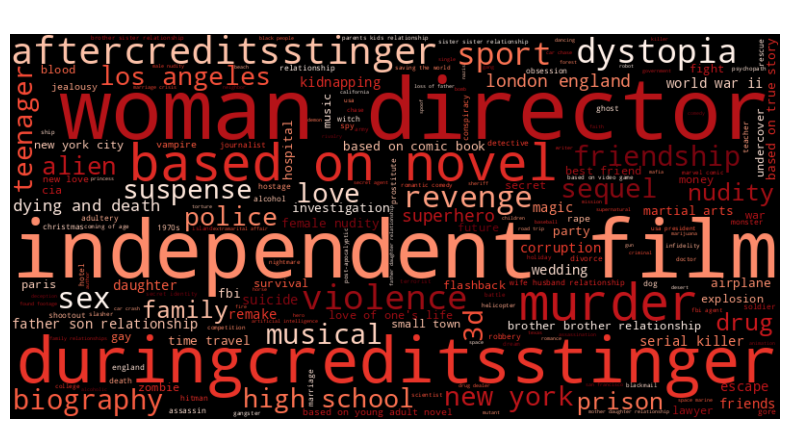

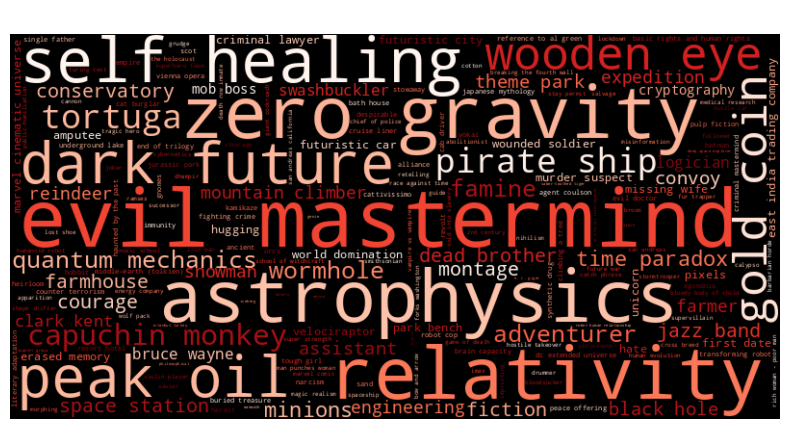

In [57]:
generate_wordcloud(keyword_counts, 'organized_keywords', 'count', "WordCloud Keywords - Count")
generate_wordcloud(keyword_popularity, 'organized_keywords', 'popularity', "WordCloud Keywords - Popularity")

#### **Keywords by Popularity**:
- **Top 3 Keywords**:
  1. **Evil mastermind**: 875.58 popularity.
  2. **Astrophysics**: 724.25 popularity.
  3. **Zero gravity**: 724.25 popularity.
- **Observations**:
  - Themes related to science, space, and complex narratives (e.g., "evil mastermind," "astrophysics") dominate popular movies.
  - Niche terms like "self healing" and "dark future" also rank highly in popularity, indicating their appeal in specific genres.

#### **Keywords by Count**:
- **Top 3 Keywords**:
  1. **Woman director**: 324 occurrences.
  2. **Independent film**: 318 occurrences.
  3. **Duringcreditsstinger**: 307 occurrences.
- **Observations**:
  - Commonly occurring keywords are more generic and indicative of broader categories (e.g., "woman director," "independent film").
  - These terms highlight trends in representation and production styles, though they may not correlate directly with popularity.

In [58]:
movies['organized_genres']

0                            Crime, Comedy
1       Adventure, Action, Science Fiction
2                        Animation, Family
3                   Comedy, Drama, Romance
4                                    Drama
                       ...                
4798                                Horror
4799                 Comedy, Family, Drama
4800                       Thriller, Drama
4801                                Family
4802                           Documentary
Name: organized_genres, Length: 4803, dtype: object

In [59]:
genres_popularity = process_association(movies, col_name='organized_genres', value_col='popularity')
genres_popularity.head(10)

organized_genres  popularity
0        Adventure   39.268042
1        Animation   38.813439
2  Science Fiction   36.451806
3          Fantasy   36.387043
4           Action   30.940382
5           Family   27.832849
6          Mystery   24.586827
7         Thriller   24.460077
8              War   23.777289
9            Crime   22.853274

In [60]:
genres_counts = process_col_count(movies, col_name='organized_genres')
genres_counts.head(10)

organized_genres  count
0            Drama   2297
1           Comedy   1722
2         Thriller   1274
3           Action   1154
4          Romance    894
5        Adventure    790
6            Crime    696
7  Science Fiction    535
8           Horror    519
9           Family    513

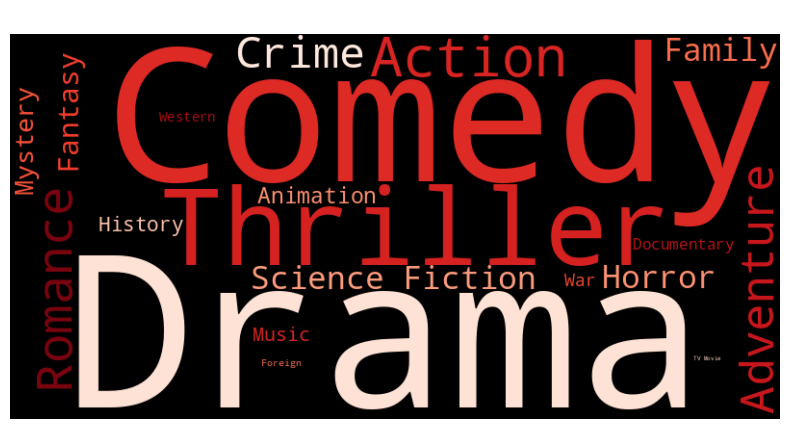

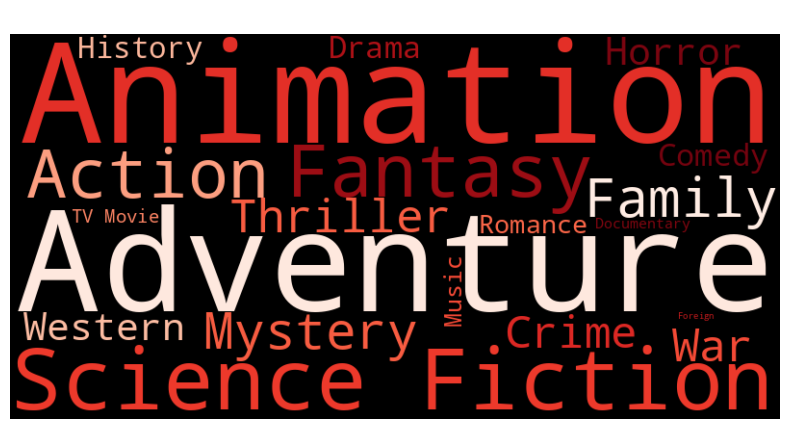

In [61]:
generate_wordcloud(genres_counts, 'organized_genres', 'count', "WordCloud Genre - Count")
generate_wordcloud(genres_popularity, 'organized_genres', 'popularity', "WordCloud Genre - Popularity")

#### **Genres by Popularity**:
- **Top 3 Genres**:
  1. **Adventure**: 39.27 popularity.
  2. **Animation**: 38.81 popularity.
  3. **Science Fiction**: 36.45 popularity.
- **Observations**:
  - Adventure, Animation, and Science Fiction dominate the popularity ranking, emphasizing audience interest in engaging, imaginative, and visually rich storytelling.
  - Genres like Fantasy and Action also perform well, reflecting their broad appeal.

#### **Genres by Count**:
- **Top 3 Genres**:
  1. **Drama**: 2297 occurrences.
  2. **Comedy**: 1722 occurrences.
  3. **Thriller**: 1274 occurrences.
- **Observations**:
  - Drama and Comedy are the most frequent genres, showing their consistent presence in movie production.
  - While frequent, these genres do not necessarily align with the top-ranked genres by popularity, such as Adventure and Animation.


#### Conclusions

1. **Keywords Insights**:
   - Popular keywords emphasize niche or high-concept themes (e.g., science, futuristic narratives).
   - Frequently used keywords, on the other hand, reveal broader trends in movie production and industry focus.

2. **Genre Trends**:
   - Adventure and Animation lead in popularity, showcasing their strong connection to audience preferences.
   - Drama and Comedy, while the most produced, do not consistently align with the highest popularity.

3. **Utility for Recommendations**:
   - Popular keywords and genres can guide personalized recommendations, while frequent ones may inform general user interests.

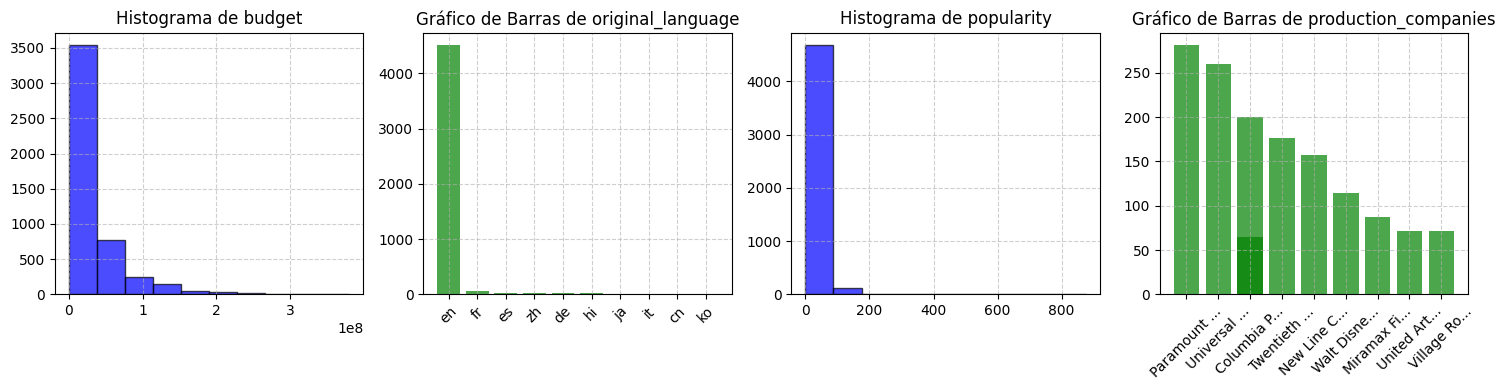

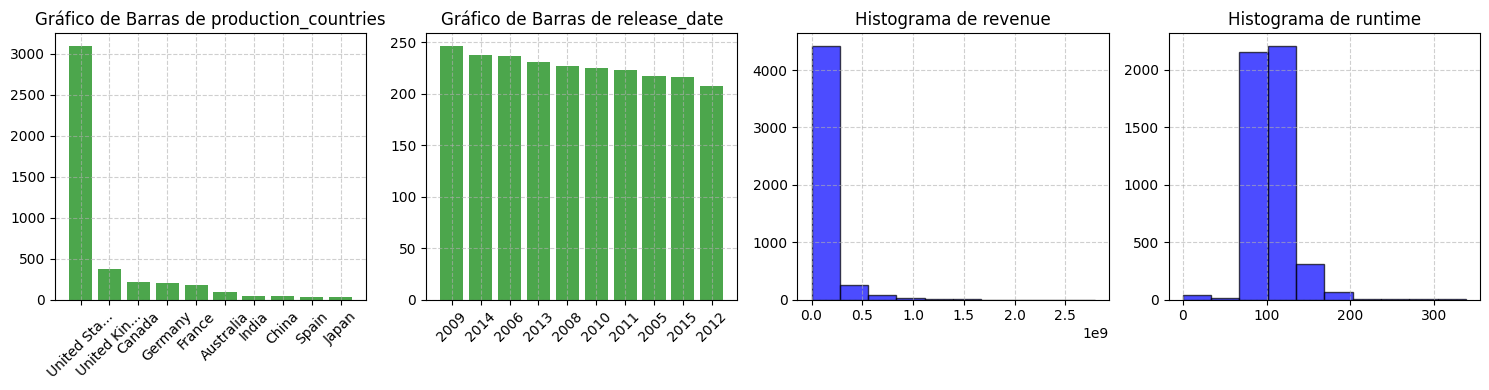

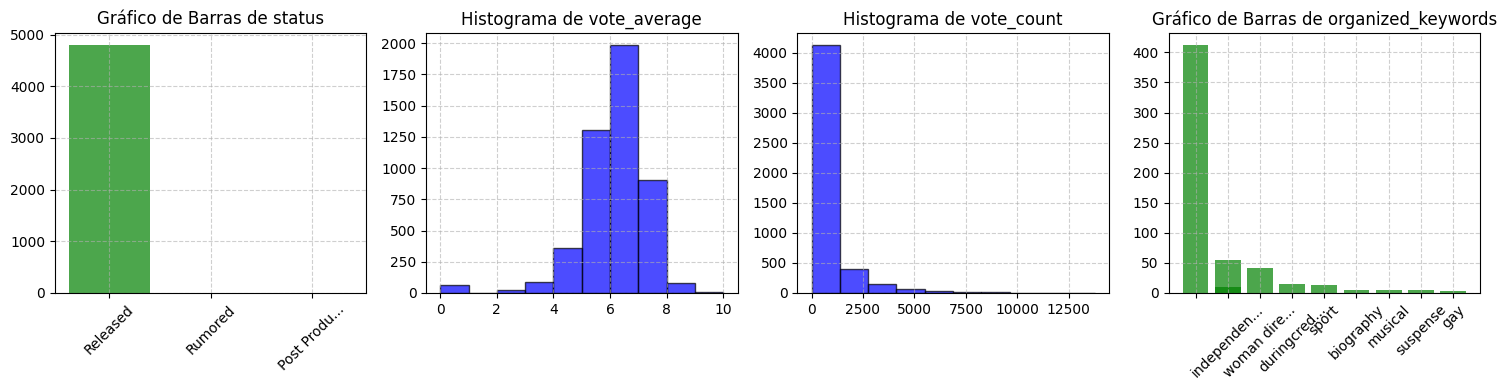

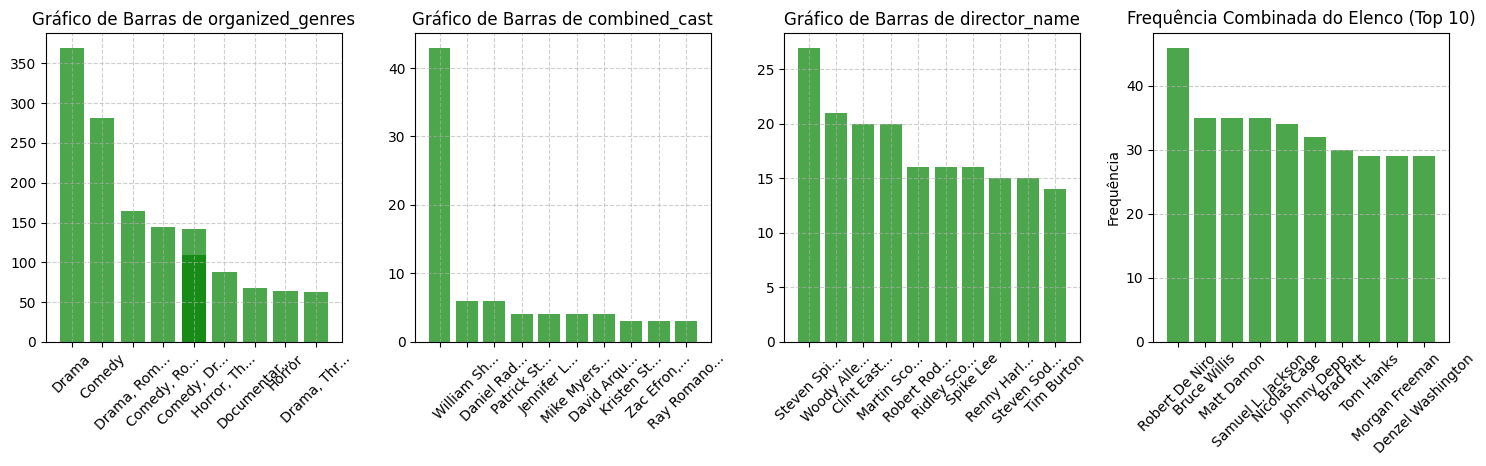

In [62]:
def truncate_labels(labels, max_length=10):
    """
    Truncates text labels to a specified maximum length, appending "..." if truncated.

    Parameters:
    - labels (iterable): List or series of text labels to be truncated.
    - max_length (int): Maximum allowed length for each label.

    Returns:
    - list: List of truncated labels.
    """
    labels = labels.astype(str)
    return [label[:max_length] + "..." if isinstance(label, str) and len(label) > max_length else label for label in labels]

def filter_columns(df):
    """
    Filters out specific columns from a DataFrame based on exclusion criteria.

    Parameters:
    - df (DataFrame): The DataFrame to filter columns from.

    Returns:
    - DataFrame: A DataFrame with specified columns excluded.
    """
    exclude_columns = [
        "genres", "keywords", "overview", "original_title", 
        "spoken_languages", "tagline", "cast", "crew", "title", 'homepage'
    ]
    return df[
        [
            col for col in df.columns
            if col not in exclude_columns
            and not "_id" in col
            and "gender" not in col
            and col not in ["cast_name_1", "cast_name_2", "cast_name_3"]
        ]
    ]

def plot_combined_cast_bar(ax, df, columns, max_labels=10):
    """
    Plots a bar chart of the combined frequency of cast members from specified columns.

    Parameters:
    - ax (Axes): The matplotlib axes to plot on.
    - df (DataFrame): The DataFrame containing the data.
    - columns (list): List of column names to combine for the plot.
    - max_labels (int): Maximum number of labels to display on the x-axis.
    """
    combined_series = pd.concat([df[col] for col in columns], axis=0).dropna()
    value_counts = combined_series.value_counts().head(max_labels)

    ax.bar(value_counts.index, value_counts.values, color='green', alpha=0.7)
    ax.set_title("Frequência Combinada do Elenco (Top 10)")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Frequência")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

def plot_all_columns_with_combined_cast(df, cast_columns, bins=10, max_cols=4, batch_size=4):
    """
    Plots histograms or bar charts for all columns in a DataFrame, excluding specified cast columns.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - cast_columns (list): List of cast-related column names to exclude from individual plots.
    - bins (int): Number of bins for histograms.
    - max_cols (int): Maximum number of columns per row in the plot grid.
    - batch_size (int): Number of columns to process in each batch.
    """
    filtered_df = filter_columns(df)
    filtered_df = filtered_df.drop(columns=cast_columns, errors='ignore')
    num_columns = len(filtered_df.columns)
    num_batches = (num_columns + batch_size - 1) // batch_size

    for batch in range(num_batches):
        start_col = batch * batch_size
        end_col = min(start_col + batch_size, num_columns)
        batch_df = filtered_df.iloc[:, start_col:end_col]

        n_cols = len(batch_df.columns)
        n_rows = (n_cols + max_cols - 1) // max_cols

        if n_cols % max_cols != 0:
            n_rows += 1

        fig, axes = plt.subplots(n_rows, max_cols, figsize=(15, n_rows * 4))
        axes = axes.flatten()

        for idx, col in enumerate(batch_df.columns):
            ax = axes[idx]
            if batch_df[col].dtype in ['int64', 'float64']:
                ax.hist(batch_df[col].dropna(), bins=bins, color='blue', alpha=0.7, edgecolor='black')
                ax.set_title(f'Histograma de {col}')
            else:
                value_counts = batch_df[col].value_counts().head(10)
                truncated_labels = truncate_labels(value_counts.index)
                ax.bar(truncated_labels, value_counts.values, color='green', alpha=0.7)
                ax.set_title(f'Gráfico de Barras de {col}')
                ax.tick_params(axis='x', rotation=45)
            ax.grid(True, linestyle='--', alpha=0.6)

        if len(batch_df.columns) < len(axes):
            plot_combined_cast_bar(axes[len(batch_df.columns)], df, cast_columns)

        for idx in range(n_cols + 1, len(axes)):
            fig.delaxes(axes[idx])

        plt.tight_layout()
        plt.show()

cast_columns = ["cast_name_1", "cast_name_2", "cast_name_3"]
plot_all_columns_with_combined_cast(movies, cast_columns=cast_columns, bins=10, max_cols=4, batch_size=4)



### Results and Insights
The dataset revealed significant trends and patterns:

- **Budget and Revenue**:
  - Both metrics are highly skewed, with the majority of movies having low budgets and revenues. A few outliers dominate, indicating that blockbusters disproportionately drive financial results in the industry.

- **Popularity**:
  - Popularity scores are concentrated at lower values, with a small number of movies achieving extremely high popularity, likely representing high-profile releases.

- **Original Language**:
  - English (`en`) is the primary language for the vast majority of movies, with only minor contributions from other languages like French, German, and Spanish, underscoring the dominance of English-language productions.

- **Genres**:
  - Drama is the most frequent genre, followed by Comedy and Action. However, genres like Adventure and Science Fiction appear less frequently but tend to have higher popularity scores, suggesting niche but impactful content.

- **Production Companies and Countries**:
  - Paramount Pictures, Universal Pictures, and Columbia Pictures are the most prolific production companies. The United States overwhelmingly leads in movie production, with a significant gap compared to other countries like the United Kingdom and Canada.

- **Movie Runtime**:
  - Most movies have runtimes between 80 and 120 minutes, peaking around 100 minutes, aligning with standard feature film lengths.

- **Release Dates**:
  - Movie releases are distributed relatively evenly across the years, with a slight decline post-2012.

- **Status**:
  - Nearly all movies in the dataset are marked as "Released," indicating a focus on completed films.

- **Audience Engagement**:
  - Average ratings cluster around 6-7, reflecting a general audience approval in this range. However, vote counts are highly skewed, with a few movies receiving significantly more attention than the majority.

- **Keywords**:
  - Frequent keywords include "independent film" and "woman director," highlighting thematic focuses. However, these terms do not always correlate with high popularity, which favors niche keywords like "astrophysics" or "evil mastermind."

- **Key People**:
  - Actors such as Robert De Niro, Bruce Willis, and Matt Damon appear most frequently in the dataset, while directors like Steven Spielberg, Woody Allen, and Clint Eastwood dominate the directorial space.

# Cleaning

In [63]:
def replace_keyword_with_most_frequent(keywords):
    """
    Replaces keywords with their most frequent stemmed version.

    Input:
    - keywords (str): A string of keywords separated by commas.
    """
    stemmer = PorterStemmer()
    words = keywords.split(', ')

    stem_to_words = {}
    for word in words:
        stem = stemmer.stem(word)
        if stem not in stem_to_words:
            stem_to_words[stem] = []
        stem_to_words[stem].append(word)

    stem_to_most_frequent = {}
    for stem, word_list in stem_to_words.items():
        word_freq = {}
        for word in word_list:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1

        max_count = 0
        most_frequent_word = None

        for word, count in word_freq.items():
            if count > max_count:
                max_count = count
                most_frequent_word = word
        
        stem_to_most_frequent[stem] = most_frequent_word

    normalized_words = []
    for word in words:
        stem = stemmer.stem(word)
        normalized_word = stem_to_most_frequent[stem]
        normalized_words.append(normalized_word)

    return ', '.join(normalized_words)

def clean_keywords(movies):
    """
    Cleans keywords by removing low-frequency keywords and replacing them with synonyms.

    Input:
    - movies (DataFrame): DataFrame containing the data.
    """
    words_before_cleaning = []
    words_after_cleaning = []

    keyword_lists = movies['normalized_keywords'].str.split(',\s*', regex=True)
    all_keywords = keyword_lists.explode().str.strip()
    keyword_counts = all_keywords.value_counts().to_dict()

    def process_keyword_list(keyword_list):
        new_keywords = []
        for keyword in keyword_list:
            original_keyword = keyword.strip()
            count = keyword_counts.get(original_keyword, 0)
            if count < 5:
                continue
            elif count < 7:
                synonyms = set()
                for syn in wordnet.synsets(original_keyword):
                    for lemma in syn.lemmas():
                        synonym = lemma.name().replace('_', ' ').lower()
                        if synonym != original_keyword.lower() and synonym in keyword_counts:
                            synonyms.add(synonym)
                synonyms_counts = [(synonym, keyword_counts.get(synonym, 0)) for synonym in synonyms]
                synonyms_counts.sort(key=lambda x: x[1], reverse=True)
                for synonym, syn_count in synonyms_counts:
                    if syn_count >= count:
                        new_keywords.append(synonym)
                        words_before_cleaning.append(original_keyword)
                        words_after_cleaning.append(synonym)
                        break
                else:
                    continue
            else:
                new_keywords.append(original_keyword)
        return ', '.join(new_keywords)

    movies['cleaned_keywords'] = keyword_lists.apply(process_keyword_list)

    examples_df = pd.DataFrame({
        'words_before_cleaning': words_before_cleaning,
        'words_after_cleaning': words_after_cleaning
    })

    examples_df = examples_df.drop_duplicates()

    print(examples_df.head(10))

    return movies

In [64]:
movies['normalized_keywords'] = movies['organized_keywords'].apply(replace_keyword_with_most_frequent)

In [65]:
movies = clean_keywords(movies)

   words_before_cleaning words_after_cleaning
0                vietnam          vietnam war
1            destruction                death
3             heartbreak                grief
4               distrust            suspicion
5               congress             relation
6                  panic               terror
7                   ring                 gang
8                stadium                arena
9                cavalry                horse
10             spiritism         spirituality


##### Results

1. **Keyword Standardization**:
   - Keywords with similar meanings or contexts were consolidated into a single, standardized term. For example:
     - "vietnam" was replaced with "vietnam war."
     - "stadium" became "arena."
     - "spiritism" was updated to "spirituality."
   - This reduced the number of unique keywords in the dataset, creating a cleaner and more manageable feature space.

2. **Enhanced Interpretability**:
   - Ambiguous or overly specific terms were replaced with broader, more interpretable concepts. For instance:
     - "destruction" was replaced with "death."
     - "cavalry" was replaced with "horse," capturing a more general theme.

3. **Consistency Across Data**:
   - Similar concepts that previously appeared under different keywords were merged, ensuring consistency in the dataset. This is critical for analyses that rely on keyword frequency or associations, such as clustering or trend identification.


##### Insights

1. **Reduction of Redundancy**:
   - By consolidating similar keywords, the dataset becomes more concise, reducing noise. This is particularly beneficial for recommendation models or visualizations, as it eliminates the dilution of importance caused by redundant terms.

2. **Thematic Clarity**:
   - The replacement of specific terms with broader ones (e.g., "stadium" to "arena") helps in capturing overarching themes, making it easier to analyze and interpret trends in movie keywords.

3. **Keyword Trends**:
   - The cleaned keywords reveal stronger and clearer thematic patterns. For example:
     - "Vietnam war" indicates a focus on historical or war-related movies.
     - "Spirituality" highlights a thematic interest in abstract or religious topics.
   - These patterns can be used to segment movies into clearer thematic groups or to identify underrepresented niches.

4. **Improved Feature Utility**:
   - With cleaner keywords, their use in downstream tasks such as movie clustering, recommendation systems, or trend analysis becomes more reliable. The reduction in noise enhances model accuracy and interpretability.

5. **Potential Business Insights**:
   - Identifying standardized, high-impact keywords like "vietnam war" or "spirituality" can guide content producers to create or market movies targeting these specific themes, as they represent coherent and meaningful topics.

##### Conclusions

- The cleaning process significantly improves the usability and quality of keyword data by reducing redundancy, enhancing clarity, and standardizing terms.
- This step paves the way for robust keyword-based analysis, enabling insights into audience preferences, thematic trends, and potential gaps in movie production.
- Future analyses can now leverage the cleaned `normalized_keywords` column to build better models and extract actionable insights from the data.

### Cleaning Keywords Statistics

In [66]:
def analyze_keyword_changes(movies, threshold=5):
    """
    Analyzes changes in keyword frequencies before and after cleaning.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    - threshold (int): The frequency threshold for keywords.
    """
    word_counts_before = (
        movies['organized_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )
    word_counts_after = (
        movies['cleaned_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )

    low_frequency_before = word_counts_before[word_counts_before < threshold]

    low_frequency_after = word_counts_after.reindex(low_frequency_before.index, fill_value=0)

    changes = pd.DataFrame({
        'Before Cleaning': low_frequency_before,
        'After Cleaning': low_frequency_after
    }).sort_values(by='Before Cleaning', ascending=False)

    print("Low-Frequency Keywords Before and After Cleaning:")
    print(changes.head(20)) 
    return changes

In [67]:
changes = analyze_keyword_changes(movies, threshold=5)

Low-Frequency Keywords Before and After Cleaning:
                      Before Cleaning  After Cleaning
organized_keywords                                   
motorcycle gang                     4               0
pope                                4               0
golf                                4               0
reality tv                          4               0
dormitory                           4               0
totalitarian regime                 4               0
reality                             4               0
drug humor                          4               0
medical research                    4               0
sweden                              4               0
shot in the shoulder                4               0
special forces                      4               0
ancient egypt                       4               0
father murder                       4               0
blindness                           4               0
adolf hitler                    

In [68]:
movies_cleaned = clean_keywords(movies)

print("\nDataFrame after cleaning:")
print(movies_cleaned[['organized_keywords', 'cleaned_keywords']])

print("\Words replaced or removed:")
changes = analyze_keyword_changes(movies_cleaned, threshold=5)

   words_before_cleaning words_after_cleaning
0                vietnam          vietnam war
1            destruction                death
3             heartbreak                grief
4               distrust            suspicion
5               congress             relation
6                  panic               terror
7                   ring                 gang
8                stadium                arena
9                cavalry                horse
10             spiritism         spirituality

DataFrame after cleaning:
                                     organized_keywords  \
0     hotel, new year's eve, witch, bet, hotel room,...   
1     android, galaxy, hermit, death star, lightsabe...   
2     father son relationship, harbor, underwater, f...   
3     vietnam veteran, hippie, mentally disabled, ru...   
4     male nudity, female nudity, adultery, midlife ...   
...                                                 ...   
4798                                                  

In [69]:
def validate_keyword_changes(movies, threshold=5):
    """
    Validates keyword changes by comparing the frequency of keywords before and after cleaning.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    - threshold (int): The frequency threshold for keywords.
    """
    word_counts_before = (
        movies['organized_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )
    word_counts_after = (
        movies['cleaned_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )

    before_set = set(word_counts_before.index)
    after_set = set(word_counts_after.index)
    removed_keywords = before_set - after_set
    added_keywords = after_set - before_set

    print("\nWords removed:")
    print(removed_keywords)

    print("\nWords Added:")
    print(added_keywords)

    low_frequency_before = word_counts_before[word_counts_before < threshold]
    low_frequency_after = word_counts_after.reindex(low_frequency_before.index, fill_value=0)

    changes = pd.DataFrame({
        'Before Cleaning': low_frequency_before,
        'After Cleaning': low_frequency_after
    }).sort_values(by='Before Cleaning', ascending=False)

    print("\nLow-Frequency Keywords Comparison:")
    print(changes.head(20))

    return changes


In [70]:
changes = validate_keyword_changes(movies_cleaned, threshold=5)


Words removed:
{'mutiny', 'vienna austria', 'cheating husband', 'world champion', 'pizzeria', 'avatar', 'pug', 'opium', 'satanism', 'exodus', 'prison camp', 'bridesmaid', 'chick flick', 'tribe', 'fighter plane', 'block party', 'the doors', 'blood on shirt', 'grandparents', 'korean', 'romanian new wave', 'scholarship', 'salesperson', 'trust fund', 'music video', 'pity', 'expectant father', 'air conditioner', 'rhedosaurus', 'impalement', 'arm sling', 'owl', 'blueprint', 'horse whisperer', 'buried alive', 'radioactive', 'four-wheelers', 'tea kettle', 'mysterious letter', 'repressed memory', 'chauffeur', 'sale of soul', 'south central l.a.', 'casting', 'gala', 'spoiled son', 'kenia', 'doomsday clock', 'bestiality', 'recreational vehicle', 'lawnmower', 'naturalist', 'gold miner', 'marcus square', 'contortionist', 'epilepsy', 'toast', 'officer', 'installer', 'threat', 'dyr', 'broker', 'intellectual', 'bad power', 'barricade', 'meteorology', 'robin hood', 'answering machine', 'student of med

In [71]:
def validate_replacements(movies):
    """
    Validates keyword replacements by comparing the frequency of keywords before and after cleaning.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    """
    word_counts_before = (
        movies['organized_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )
    intermediate_words = set(word_counts_before[(word_counts_before >= 5) & (word_counts_before < 7)].index)

    replacements = []
    for before, after in zip(movies['organized_keywords'], movies['cleaned_keywords']):
        before_set = set(before.split(', '))
        after_set = set(after.split(', '))

        replaced = before_set & intermediate_words - after_set
        for word in replaced:
            replacements.append({'Word Before': word, 'Replaced By': after_set})

    replacements_df = pd.DataFrame(replacements)
    print("\Words replaced:")
    print(replacements_df.head(20))
    return replacements_df


In [72]:
replacements_df = validate_replacements(movies_cleaned)

\Words replaced:
                      Word Before  \
0                  rescue mission   
1                          galaxy   
2                         vietnam   
3                        suburbia   
4                     bittersweet   
5                         naivety   
6   blindness and impaired vision   
7                     arms dealer   
8                   mad scientist   
9                            work   
10                  class society   
11                    destruction   
12                         mutiny   
13                        jamaica   
14                       governor   
15                   swashbuckler   
16                         yakuza   
17                   marine corps   
18                    u.s. marine   
19                      guerrilla   

                                          Replaced By  
0           {planet, android, rebellion, space opera}  
1           {planet, android, rebellion, space opera}  
2   {mentally disabled, based on nove

In [73]:
def generate_cleaning_stats(movies):
    """
    Generates cleaning statistics by comparing the frequency of keywords before and after cleaning.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    """
    word_counts_before = (
        movies['organized_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )
    word_counts_after = (
        movies['cleaned_keywords']
        .str.split(', ')
        .explode()
        .value_counts()
    )

    total_words_before = word_counts_before.sum()
    total_words_after = word_counts_after.sum()
    removed_words = total_words_before - total_words_after

    print(f"\nCleaning Statistics:")
    print(f"- Words before cleaning: {total_words_before}")
    print(f"- Words after cleaning: {total_words_after}")
    print(f"- Words removed: {removed_words}")
    print(f"- % Words removed: {removed_words / total_words_before:.2%}")


In [74]:
generate_cleaning_stats(movies_cleaned)


Cleaning Statistics:
- Words before cleaning: 36615
- Words after cleaning: 21530
- Words removed: 15085
- % Words removed: 41.20%


In [75]:
def plot_cleaning_impact_improved(movies, threshold=5, max_keywords=50):
    """
    Plots the impact of cleaning on keyword frequencies.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    - threshold (int): The frequency threshold for keywords.
    - max_keywords (int): The maximum number of keywords to plot.
    """
    word_counts_before = (
        movies['organized_keywords']
        .dropna()
        .str.split(', ')
        .explode()
        .str.strip()
        .replace('', pd.NA)
        .dropna()
        .value_counts()
    )
    word_counts_after = (
        movies['cleaned_keywords']
        .dropna()
        .str.split(', ')
        .explode()
        .str.strip()
        .replace('', pd.NA)
        .dropna()
        .value_counts()
    )

    sorted_counts_before = word_counts_before.head(max_keywords)
    sorted_counts_after = word_counts_after.reindex(sorted_counts_before.index, fill_value=0)

    plt.figure(figsize=(12, 6))

    plt.plot(
        sorted_counts_before.index,
        sorted_counts_before.values,
        label='Before Cleaning',
        color='red',
        marker='o'
    )
    plt.plot(
        sorted_counts_before.index,
        sorted_counts_after.values,
        label='After Cleaning',
        color='blue',
        marker='o'
    )

    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold for Deletion')

    plt.xlabel('Keywords (Top Frequencies)', fontsize=12)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.title('Impact of Cleaning on Keyword Frequencies', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    plt.show()

def plot_scatter_replacements(movies, threshold=5, max_words=50):
    """
    Plots a scatter plot of keyword frequencies before and after cleaning.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    - threshold (int): The frequency threshold for keywords.
    - max_words (int): The maximum number of words to plot.
    """
    word_counts_before = (
        movies['organized_keywords']
        .dropna()
        .str.split(', ')
        .explode()
        .str.strip()
        .replace('', pd.NA)
        .dropna()
        .value_counts()
    )
    word_counts_after = (
        movies['cleaned_keywords']
        .dropna()
        .str.split(', ')
        .explode()
        .str.strip()
        .replace('', pd.NA)
        .dropna()
        .value_counts()
    )

    df_scatter = pd.DataFrame({
        'Word': word_counts_before.index,
        'Before': word_counts_before.values,
        'After': word_counts_after.reindex(word_counts_before.index, fill_value=0).values
    }).head(max_words)

    df_scatter['Category'] = df_scatter.apply(
        lambda row: 'Removed' if row['After'] == 0 else ('Substituted' if row['Before'] != row['After'] else 'Maintained'),
        axis=1
    )

    plt.figure(figsize=(12, 6))
    for category, color in zip(['Removed', 'Substituted', 'Maintained'], ['red', 'orange', 'blue']):
        subset = df_scatter[df_scatter['Category'] == category]
        plt.scatter(subset['Before'], subset['After'], label=category, color=color, alpha=0.7, s=100)

    plt.plot([0, df_scatter['Before'].max()], [0, df_scatter['Before'].max()], color='gray', linestyle='--', label='No Change')

    plt.xlabel('Frequency Before Cleaning', fontsize=12)
    plt.ylabel('Frequency After Cleaning', fontsize=12)
    plt.title('Keyword Frequency Before and After Cleaning', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_most_changed_keywords(movies, max_words=30):
    """
    Plots the most changed keywords before and after cleaning.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    - max_words (int): The maximum number of words to plot.
    """
    word_counts_before = (
        movies['organized_keywords']
        .dropna()
        .str.split(', ')
        .explode()
        .str.strip()
        .replace('', pd.NA)
        .dropna()
        .value_counts()
    )
    word_counts_after = (
        movies['cleaned_keywords']
        .dropna()
        .str.split(', ')
        .explode()
        .str.strip()
        .replace('', pd.NA)
        .dropna()
        .value_counts()
    )

    changes_df = pd.DataFrame({
        'Before Cleaning': word_counts_before,
        'After Cleaning': word_counts_after.reindex(word_counts_before.index, fill_value=0)
    })

    changes_df['Difference'] = (changes_df['Before Cleaning'] - changes_df['After Cleaning']).abs()

    most_changed = changes_df.sort_values('Difference', ascending=False).head(max_words)

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        most_changed[['Before Cleaning', 'After Cleaning']],
        annot=True,
        fmt=".0f",
        cmap="coolwarm",
        linewidths=0.5,
        cbar_kws={"label": "Frequency Difference"}
    )
    plt.title('Most Changed Keywords Before and After Cleaning', fontsize=14)
    plt.ylabel('Keywords', fontsize=12)
    plt.xlabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()



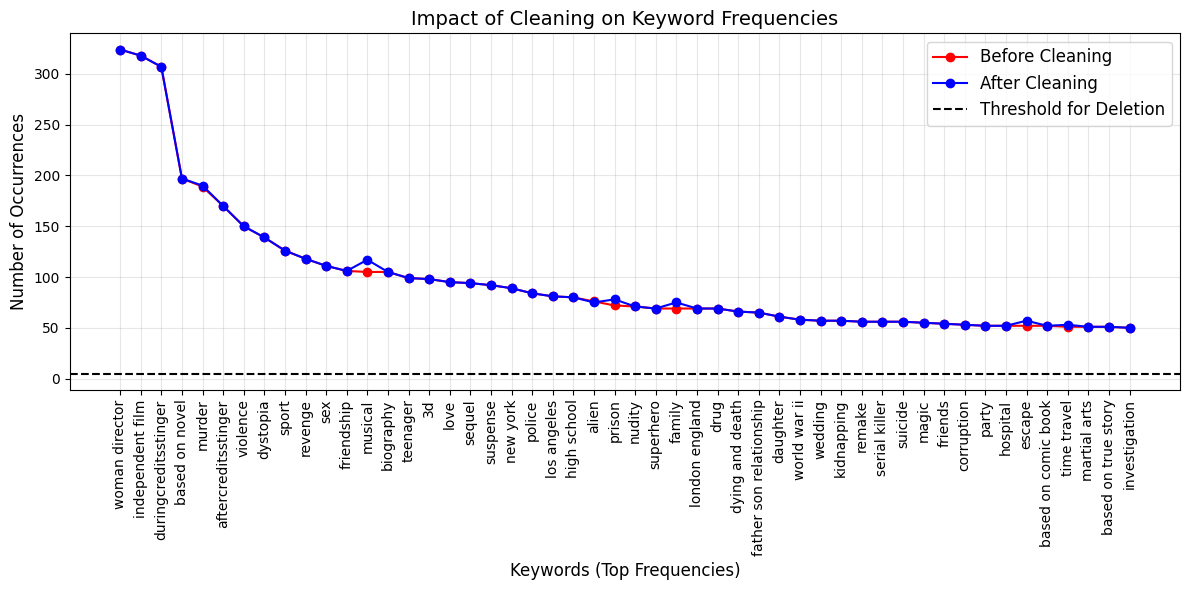

In [76]:
plot_cleaning_impact_improved(movies_cleaned, threshold=5, max_keywords=50)

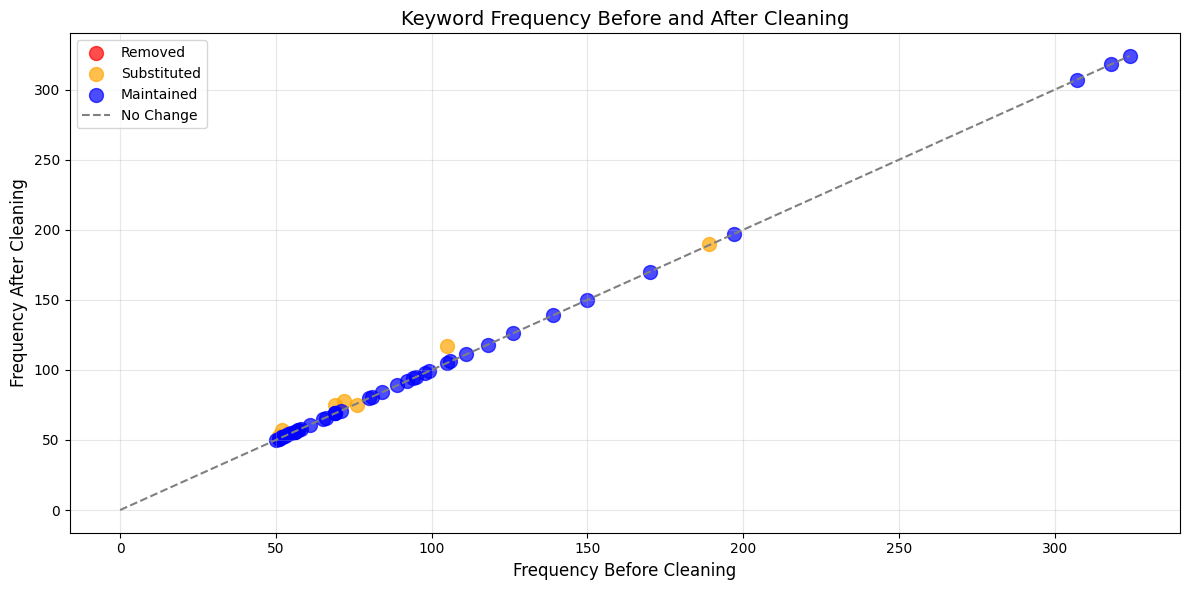

In [77]:
plot_scatter_replacements(movies_cleaned, threshold=5, max_words=50)

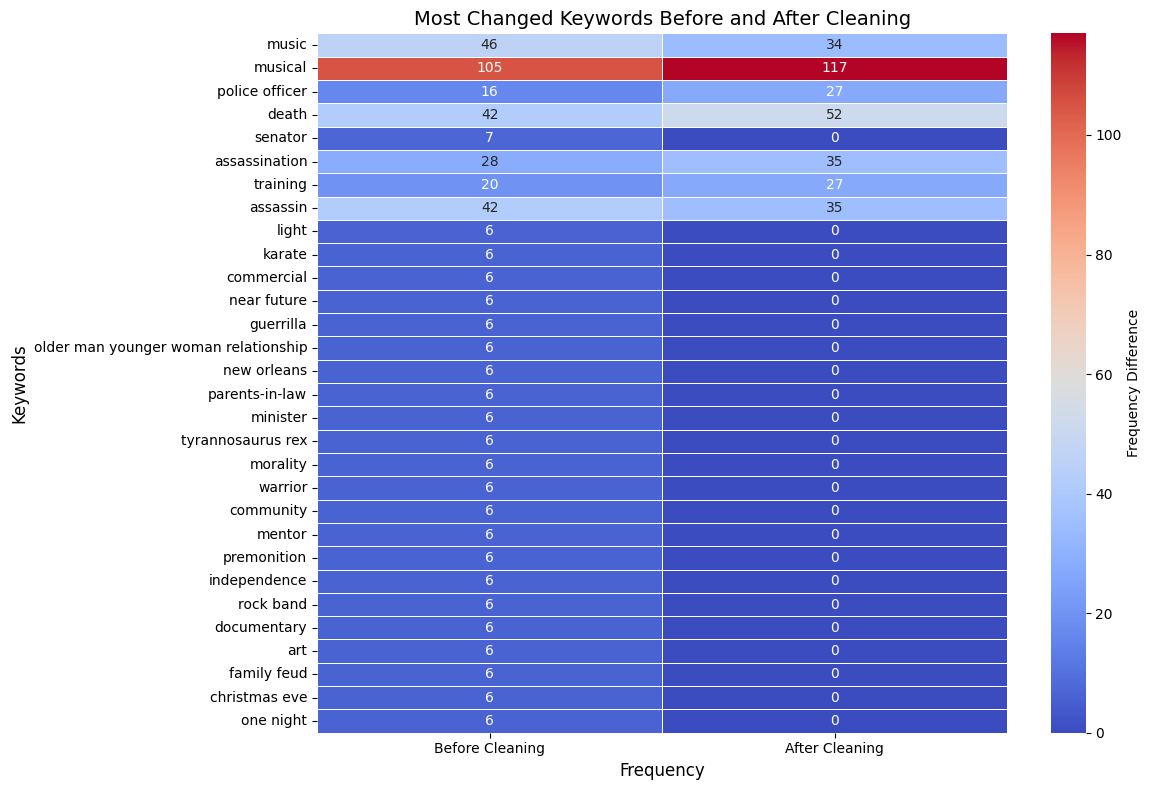

In [78]:
plot_most_changed_keywords(movies_cleaned, max_words=30)

#### Insights

1. **Reduction in Keyword Redundancy**:
   - After cleaning, the number of unique keywords was reduced without significantly impacting their overall representation.
   - Keywords with similar meanings or synonyms were consolidated (e.g., "musical" and "music"), which improved consistency in the dataset.

2. **Threshold for Deletion**:
   - The dashed line in the first chart represents a frequency threshold for keyword removal.
   - Keywords below this threshold were removed during the cleaning process, helping to eliminate noise and low-value keywords that added little to no analytical insight.

3. **Preservation of Top Frequent Keywords**:
   - High-frequency keywords such as "woman director" and "independent film" maintained their prominence after cleaning, indicating that the process preserved the most impactful data.

4. **Impact on Specific Keywords**:
   - The heatmap highlights keywords that saw significant frequency adjustments. For instance:
     - "Musical" increased in frequency after cleaning, consolidating related terms like "music."
     - Certain low-frequency keywords, such as "minister" and "guerrilla," were removed as they fell below the threshold for retention.

5. **Improved Keyword Distribution**:
   - The blue (post-cleaning) data points in the frequency chart show a smoother distribution compared to the red (pre-cleaning) points, indicating a more balanced dataset with reduced noise.


#### Conclusions

1. **Enhanced Dataset Consistency**:
   - The cleaning process successfully consolidated redundant and synonymous keywords, improving the interpretability and reliability of the dataset for further analysis.

2. **Focus on Meaningful Data**:
   - By removing rarely used or redundant keywords, the cleaning process prioritized higher-quality, more impactful features, which are essential for building robust models or generating insights.

3. **Improved Data Usability**:
   - The cleaned dataset is better suited for downstream tasks such as clustering, trend analysis, and recommendation systems, as the keywords now represent more consistent and meaningful concepts.

4. **Balance Between Preservation and Reduction**:
   - The cleaning process struck a balance between preserving meaningful high-frequency keywords and reducing low-value data, resulting in a more concise and actionable keyword set.

5. **Data-Driven Improvements**:
   - The significant changes highlighted in the heatmap illustrate how cleaning processes can refine keyword distributions, ensuring that the dataset reflects consistent and relevant patterns.


# Organized Dataframe Correlation Analysis

The objective of this section was to analyze the correlations between numerical features in the organized dataset. Understanding these relationships provides insights into how different variables interact and can inform feature selection for predictive modeling.

In [79]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   movie_id              4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   Int64  
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

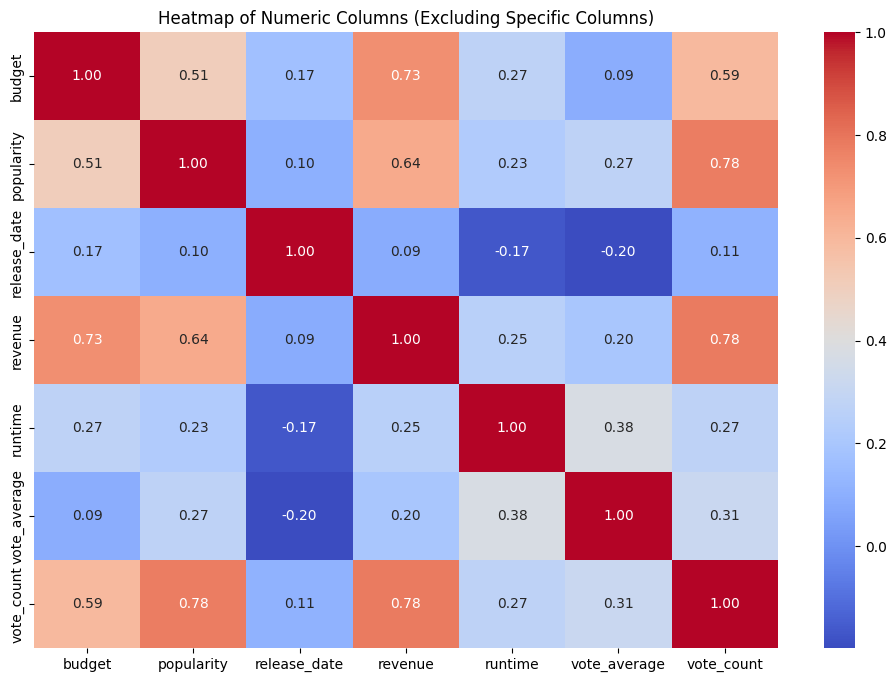

In [80]:
excluded_columns = [
    "cast_id_1", "gender_cast_1", "cast_id_2", "gender_cast_2", 
    "cast_id_3", "gender_cast_3", "director_id", "director_gender", "movie_id"
]

numeric_cols = movies.select_dtypes(include=["number"]).columns
filtered_numeric_cols = [col for col in numeric_cols if col not in excluded_columns]

correlation_matrix = movies[filtered_numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Heatmap of Numeric Columns (Excluding Specific Columns)")
plt.show()

In [81]:
threshold = 0.5
correlations_above_threshold = correlation_matrix.unstack()
correlations_above_threshold = correlations_above_threshold[
    (correlations_above_threshold > threshold) & (correlations_above_threshold < 1)
].drop_duplicates().sort_values(ascending=False)

correlations_table = correlations_above_threshold.reset_index()
correlations_table.columns = ["Variable 1", "Variable 2", "Correlation"]

print(correlations_table)

   Variable 1  Variable 2  Correlation
0     revenue  vote_count     0.781487
1  popularity  vote_count     0.778130
2      budget     revenue     0.730823
3  popularity     revenue     0.644724
4      budget  vote_count     0.593180
5      budget  popularity     0.505414


1. **Strong Positive Correlations**:
   - **Budget and Revenue**: Correlation coefficient of **0.73** indicates a strong positive relationship. Higher budgets are often associated with higher revenues, supporting the idea that investment in production can drive financial success.
   - **Vote Count and Popularity**: Correlation of **0.78** shows that movies with higher vote counts tend to have higher popularity. This highlights the influence of audience engagement on a movie's visibility.
   - **Vote Count and Revenue**: A correlation of **0.78** suggests that movies generating more revenue also receive more votes, likely due to broader exposure.

2. **Moderate Positive Correlations**:
   - **Budget and Popularity**: Correlation of **0.51** suggests that higher-budget movies are generally more popular, likely due to better production quality and marketing efforts.
   - **Revenue and Popularity**: Correlation of **0.64** indicates that movies earning higher revenues also tend to have higher popularity, reflecting audience preference for widely marketed and high-performing films.

3. **Weak or Negligible Correlations**:
   - **Release Date with Other Variables**:
     - The release date shows weak correlations with most variables, such as a negative correlation with runtime (-0.17) and vote average (-0.20). This suggests that movie performance metrics are not strongly tied to when the movie was released.
   - **Runtime and Popularity**: A low correlation (0.23) indicates that movie length does not significantly influence audience popularity.
   - **Vote Average and Revenue/Popularity**: Correlations between vote average and other metrics (e.g., revenue: 0.20, popularity: 0.27) are weak, suggesting that critical acclaim does not necessarily translate into financial or popular success.

4. **Key Independent Variables**:
   - **Vote Average**: Despite its weak correlations with most metrics, it represents audience sentiment and may still be valuable in understanding niche patterns.
   - **Release Date**: Its limited correlation with other features indicates it may not be a major determinant in movie success.

In [82]:
def compute_keyword_correlation(movies, excluded_columns, min_correlation):
    """
    Computes the correlation between keywords and numerical variables in the dataset.

    Parameters:
    - movies (DataFrame): The DataFrame containing the data.
    - excluded_columns (list): List of columns to exclude from the correlation analysis.
    - min_correlation (float): The minimum correlation threshold to consider.
    """
    keyword_lists = movies['cleaned_keywords'].apply(
        lambda x: [kw.strip() for kw in x.split(',') if kw.strip()]
    )
    mlb = MultiLabelBinarizer()
    keywords_encoded = pd.DataFrame(
        mlb.fit_transform(keyword_lists),
        columns=mlb.classes_,
        index=movies.index
    )

    numeric_columns = movies.select_dtypes(include=['float', 'int']).columns
    columns_to_include = [col for col in numeric_columns if col not in excluded_columns]

    conflicting_columns = set(keywords_encoded.columns).intersection(columns_to_include)
    if conflicting_columns:
        keywords_encoded = keywords_encoded.drop(columns=conflicting_columns)

    df_combined = pd.concat([keywords_encoded, movies[columns_to_include]], axis=1)

    correlation_matrix = df_combined.corr()
    keyword_correlation = correlation_matrix.loc[keywords_encoded.columns, columns_to_include]
    mask = keyword_correlation.abs().ge(min_correlation).any(axis=1)
    filtered_keyword_correlation = keyword_correlation[mask]

    return filtered_keyword_correlation

def plot_keyword_correlation(correlation_matrix):
    """
    Plots a heatmap of the correlation between keywords and numerical variables.

    Parameters:
    - correlation_matrix (DataFrame): The correlation matrix between keywords and numerical variables.
    """
    if correlation_matrix.empty:
        return

    plt.figure(figsize=(12, max(5, len(correlation_matrix) * 0.5)))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation between Keywords and Numerical Variables')
    plt.xlabel('Numerical Variables')
    plt.ylabel('Keywords')
    plt.tight_layout()
    plt.show()

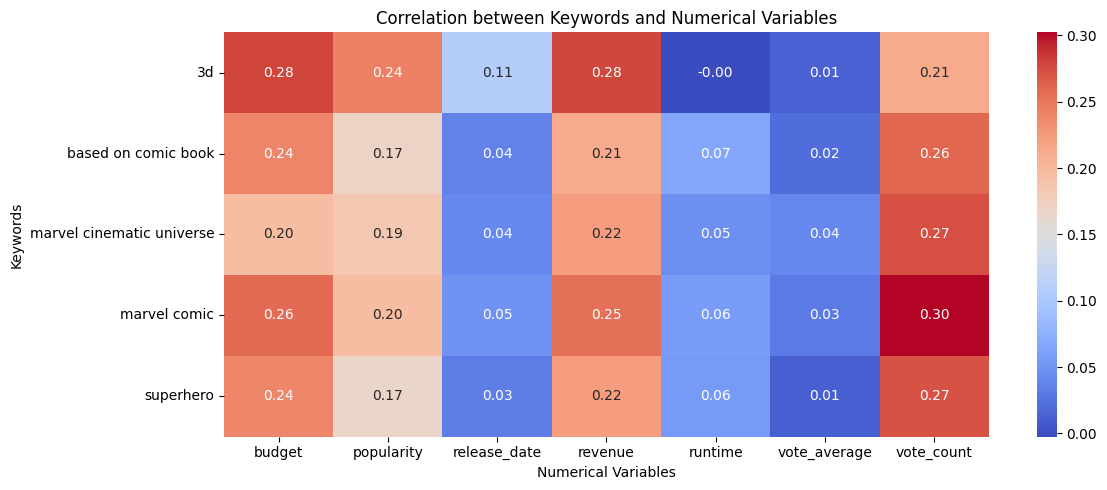

In [83]:
keyword_correlation = compute_keyword_correlation(movies, excluded_columns, 0.25)

plot_keyword_correlation(keyword_correlation)

1. **Keywords and Budget**:
   - Keywords such as **"3D"** and **"marvel comic"** show the highest correlation with budget (0.28 and 0.26, respectively). This suggests that movies associated with these keywords are often high-budget productions, likely due to their connection to large-scale, visually intense productions.

2. **Keywords and Popularity**:
   - The keyword **"3D"** has the strongest correlation with popularity (0.24), indicating that visually engaging formats like 3D are associated with higher audience engagement.
   - **"Marvel comic"** and **"superhero"** also exhibit moderate correlations (0.20 and 0.17, respectively), reflecting the broad appeal of superhero movies.

3. **Keywords and Revenue**:
   - Keywords like **"3D"** (0.28) and **"marvel comic"** (0.25) show relatively strong correlations with revenue. This aligns with the financial success of franchise-driven, visually spectacular films.

4. **Keywords and Vote Count**:
   - **"Marvel comic"** has the highest correlation with vote count (0.30), followed by **"superhero"** (0.27) and **"marvel cinematic universe"** (0.27). This demonstrates the popularity of these genres among audiences, leading to higher levels of audience interaction.

5. **Keywords and Vote Average**:
   - Correlations between keywords and vote average are generally low, with the highest being **"marvel comic"** (0.06). This suggests that while certain keywords correlate with financial or audience engagement metrics, they are less indicative of critical acclaim.

6. **Negligible Correlations with Runtime and Release Date**:
   - Most keywords show very low correlations with runtime and release date. This indicates that keywords like **"3D"**, **"superhero"**, and **"based on comic book"** are not strongly influenced by the length or timing of the movie release.

In [84]:
col = list(movies.columns)
nulls = [int(movies[column].isnull().sum()) for column in movies.columns]
percentage = [(movies[column].isnull().sum()/len(movies.index)*100) for column in movies.columns]

nulls_analysis = pd.DataFrame({'Col': col, 'Qt Null': nulls, '% Null': percentage})
bgg_5p = nulls_analysis[nulls_analysis['% Null']>2]

bgg_5p

Col  Qt Null     % Null
2               homepage     3091  64.355611
9   production_companies      351   7.307933
10  production_countries      174   3.622736
16               tagline      844  17.572351

#### Decision
- These columns will **not be cleaned or filled**, as they are not relevant for the planned analyses or for the recommendation model. Specifically:
  - **`homepage`**: Primarily descriptive and not useful for quantitative or categorical analysis.
  - **`production_companies`**: While potentially useful, it is not critical for the recommendation model in its current scope.
  - **`tagline`**: Primarily textual and does not provide actionable insights for the model.

#### Justification
- Since these columns are not being used in the recommendation model or other analyses, cleaning them would not add value and would only increase computational overhead.
- Excluding these columns from preprocessing ensures the focus remains on features directly impacting the recommendation system.


Analyzing column: budget

Original Data:
count    4.803000e+03
mean     2.904504e+07
std      4.072239e+07
min      0.000000e+00
25%      7.900000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

After Outlier Removal (IQR):
count    4.482000e+03
mean     2.053410e+07
std      2.369763e+07
min      0.000000e+00
25%      2.262500e+05
50%      1.200000e+07
75%      3.200000e+07
max      9.800000e+07
Name: budget, dtype: float64

After Winsorization:
count    4.803000e+03
mean     2.576586e+07
std      3.010471e+07
min      0.000000e+00
25%      7.900000e+05
50%      1.500000e+07
75%      4.000000e+07
max      9.881500e+07
Name: budget, dtype: float64

After Log Transformation:
count    4803.000000
mean       13.001826
std         7.040815
min         0.000000
25%        13.579709
50%        16.523561
75%        17.504390
max        19.755682
Name: budget, dtype: float64


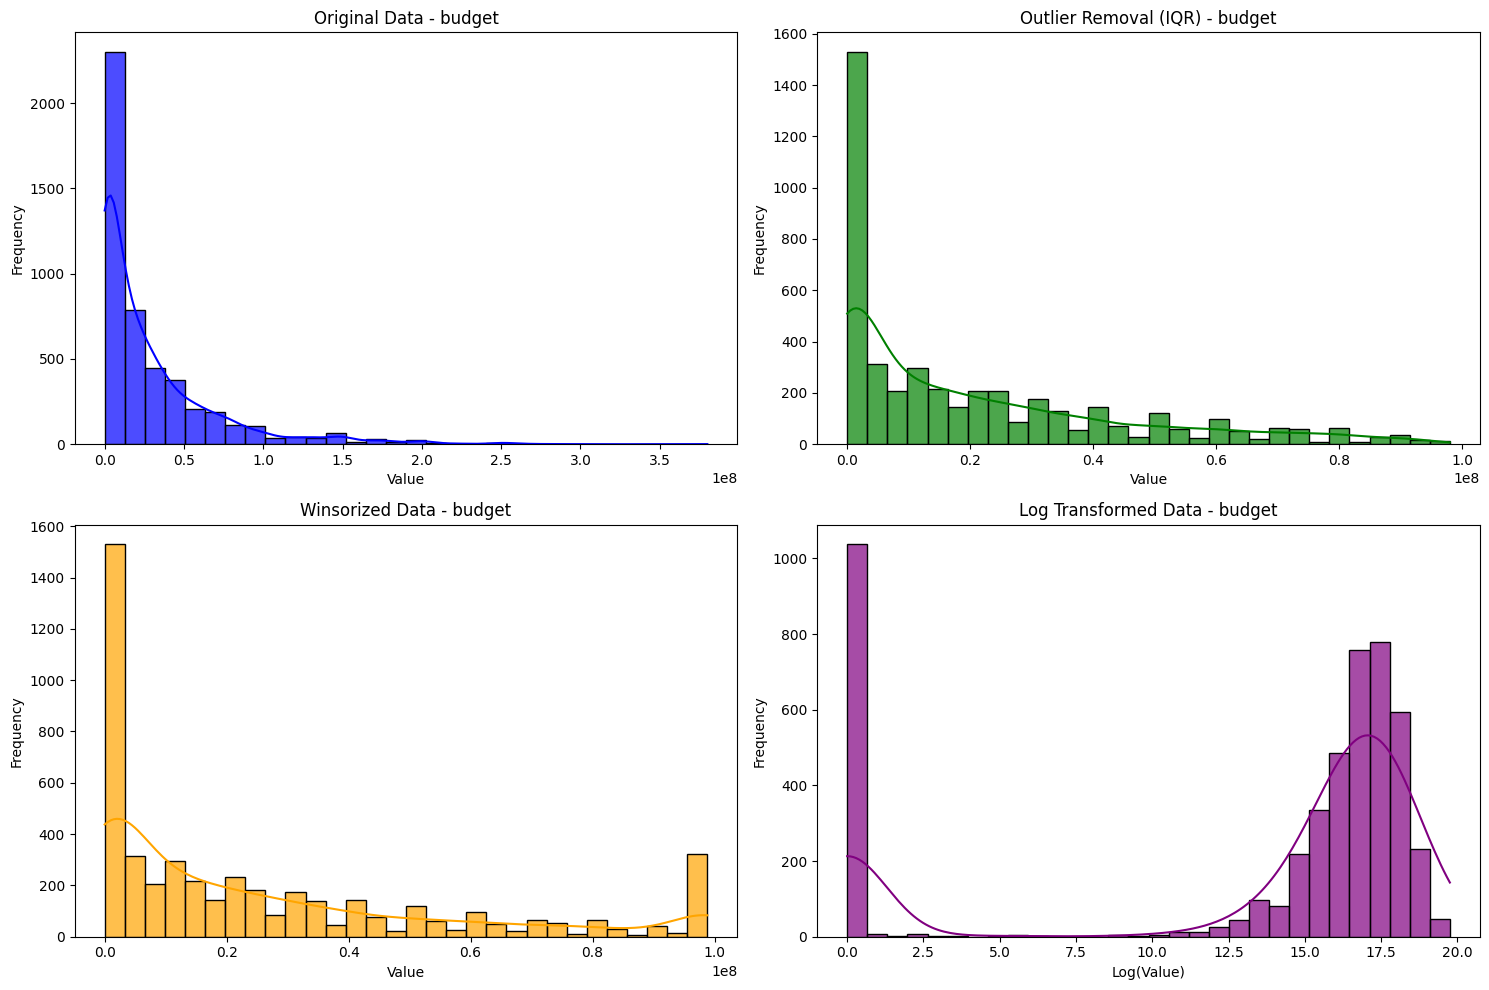


Suggested Approach:
Column 'budget' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: movie_id

Original Data:
count      4803.000000
mean      57165.484281
std       88694.614033
min           5.000000
25%        9014.500000
50%       14629.000000
75%       58610.500000
max      459488.000000
Name: movie_id, dtype: float64

After Outlier Removal (IQR):
count      4099.000000
mean      23700.548182
std       27167.022000
min           5.000000
25%        7506.500000
50%       11836.000000
75%       33130.500000
max      132363.000000
Name: movie_id, dtype: float64

After Winsorization:
count      4803.000000
mean      39721.781178
std       46094.041490
min           5.000000
25%        9014.500000
50%       14629.000000
75%       58610.500000
max      133004.500000
Name: movie_id, dtype: float64

After Log Transformation:
count    4803.000000
mean        9.728170
std         1.825

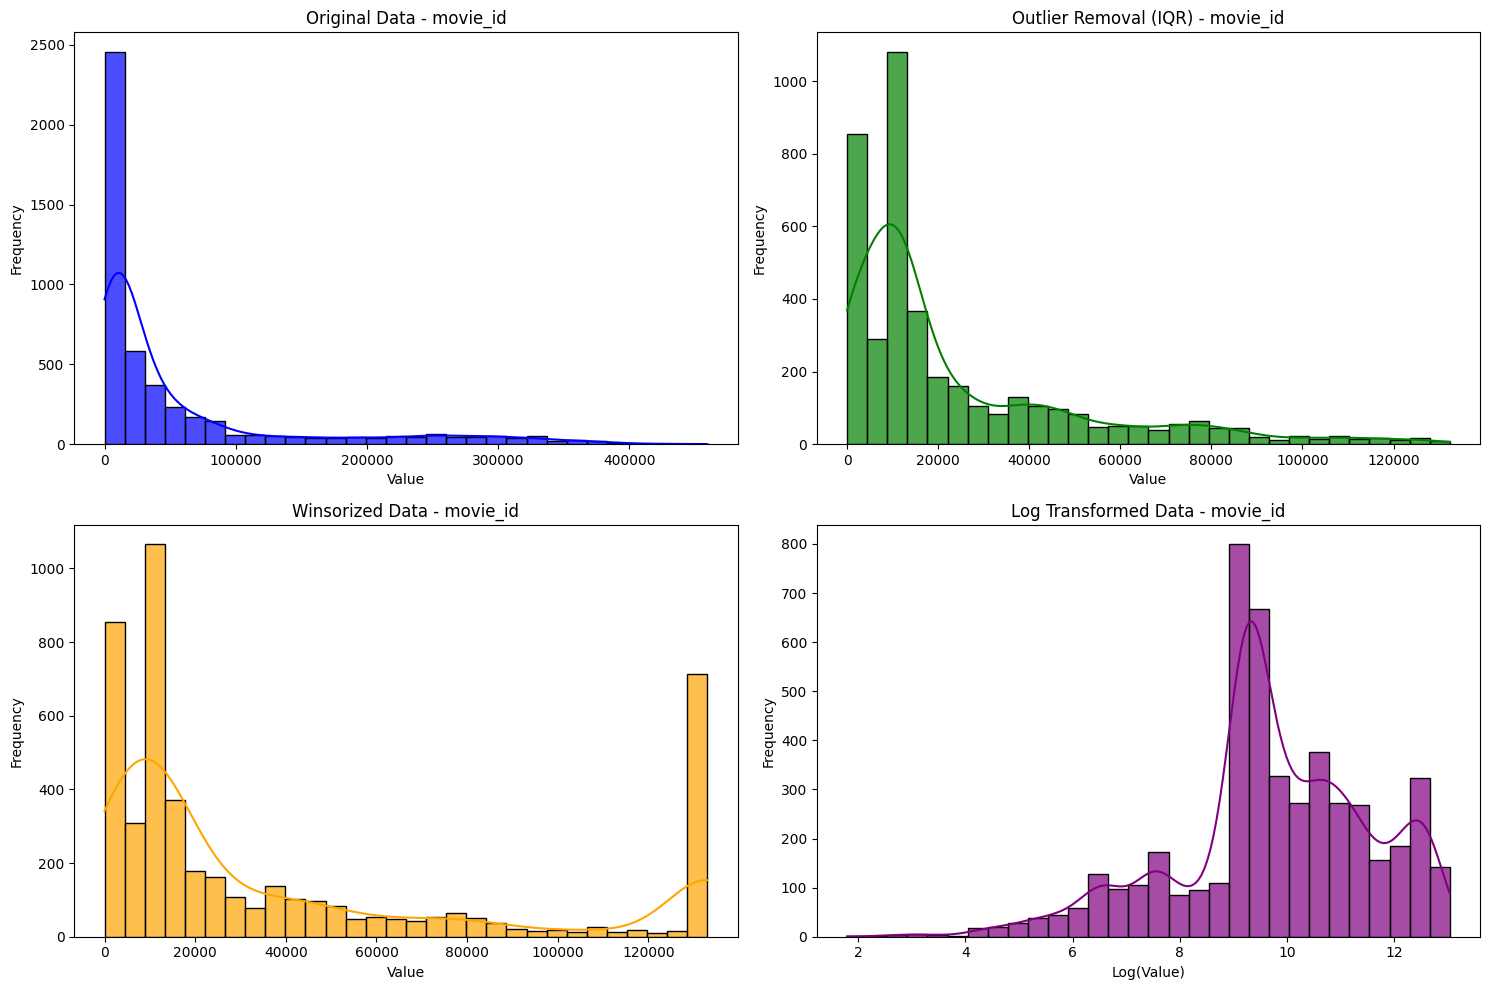


Suggested Approach:
Column 'movie_id' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: popularity

Original Data:
count    4803.000000
mean       21.492301
std        31.816650
min         0.000000
25%         4.668070
50%        12.921594
75%        28.313505
max       875.581305
Name: popularity, dtype: float64

After Outlier Removal (IQR):
count    4528.000000
mean       16.424951
std        15.115538
min         0.000000
25%         4.270569
50%        11.770272
75%        24.613611
max        63.655973
Name: popularity, dtype: float64

After Winsorization:
count    4803.000000
mean       19.136401
std        18.343215
min         0.000000
25%         4.668070
50%        12.921594
75%        28.313505
max        63.781656
Name: popularity, dtype: float64

After Log Transformation:
count    4803.000000
mean        2.516850
std         1.161178
min         0.000000
25%         1

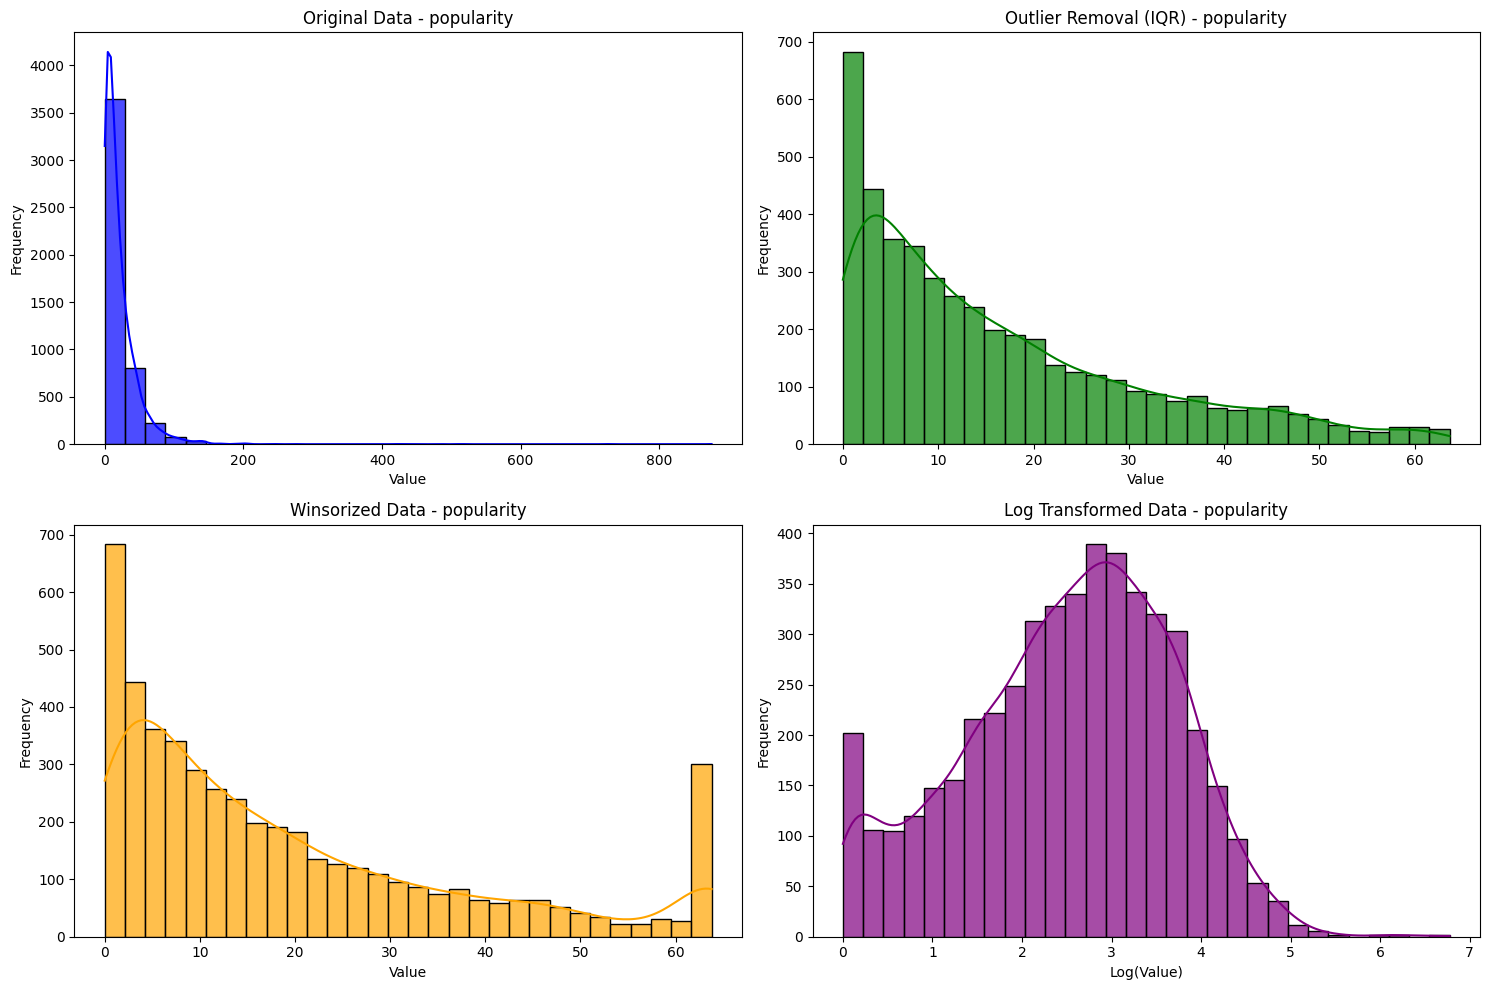


Suggested Approach:
Column 'popularity' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: release_date

Original Data:
count         4802.0
mean     2002.468763
std        12.414354
min           1916.0
25%           1999.0
50%           2005.0
75%           2011.0
max           2017.0
Name: release_date, dtype: Float64

After Outlier Removal (IQR):
count         4528.0
mean     2004.740945
std         7.835919
min           1981.0
25%           2000.0
50%           2006.0
75%           2011.0
max           2017.0
Name: release_date, dtype: Float64

After Winsorization:
count         4802.0
mean     2003.386297
std          9.39304
min           1981.0
25%           1999.0
50%           2005.0
75%           2011.0
max           2017.0
Name: release_date, dtype: Float64

After Log Transformation:
count      4802.0
mean     7.602616
std      0.006241
min      7.558517
25%      7.6009

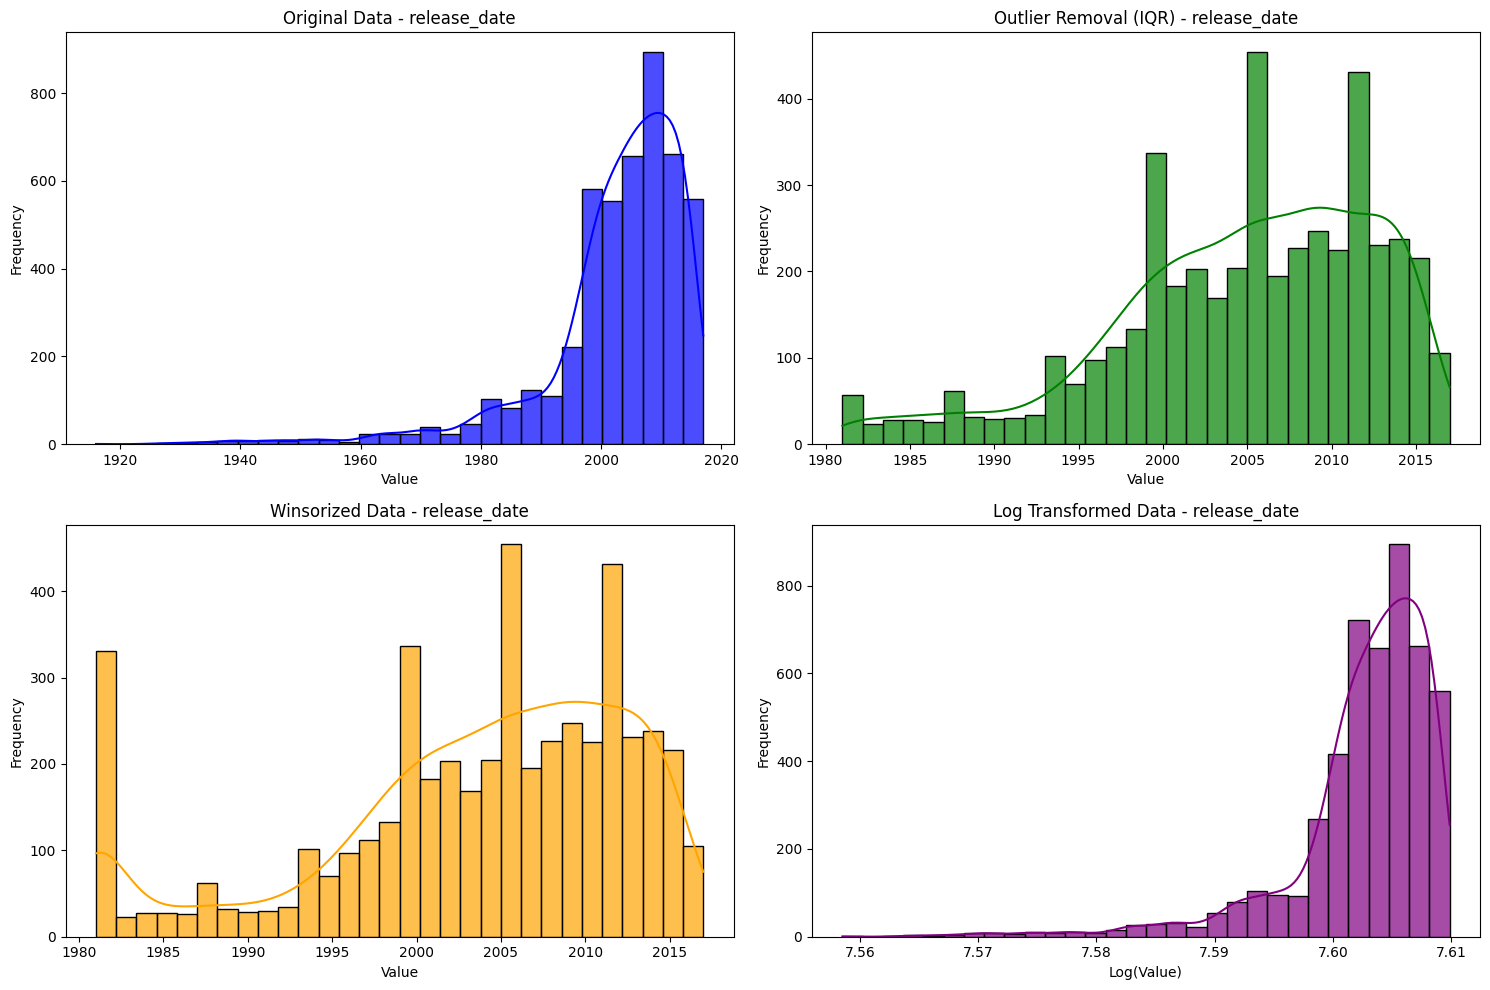


Suggested Approach:
Column 'release_date' has minimal outliers. No aggressive treatment is needed.

--------------------------------------------------------------------------------


Analyzing column: revenue

Original Data:
count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64

After Outlier Removal (IQR):
count    4.331000e+03
mean     3.972521e+07
std      5.539494e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.234263e+07
75%      6.073178e+07
max      2.319764e+08
Name: revenue, dtype: float64

After Winsorization:
count    4.803000e+03
mean     5.864921e+07
std      7.780552e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.322930e+08
Name: revenue, dtype: float64

After Log Transformation:
count    4803.000000
mean       12.220768
std         8.157087
min         0.

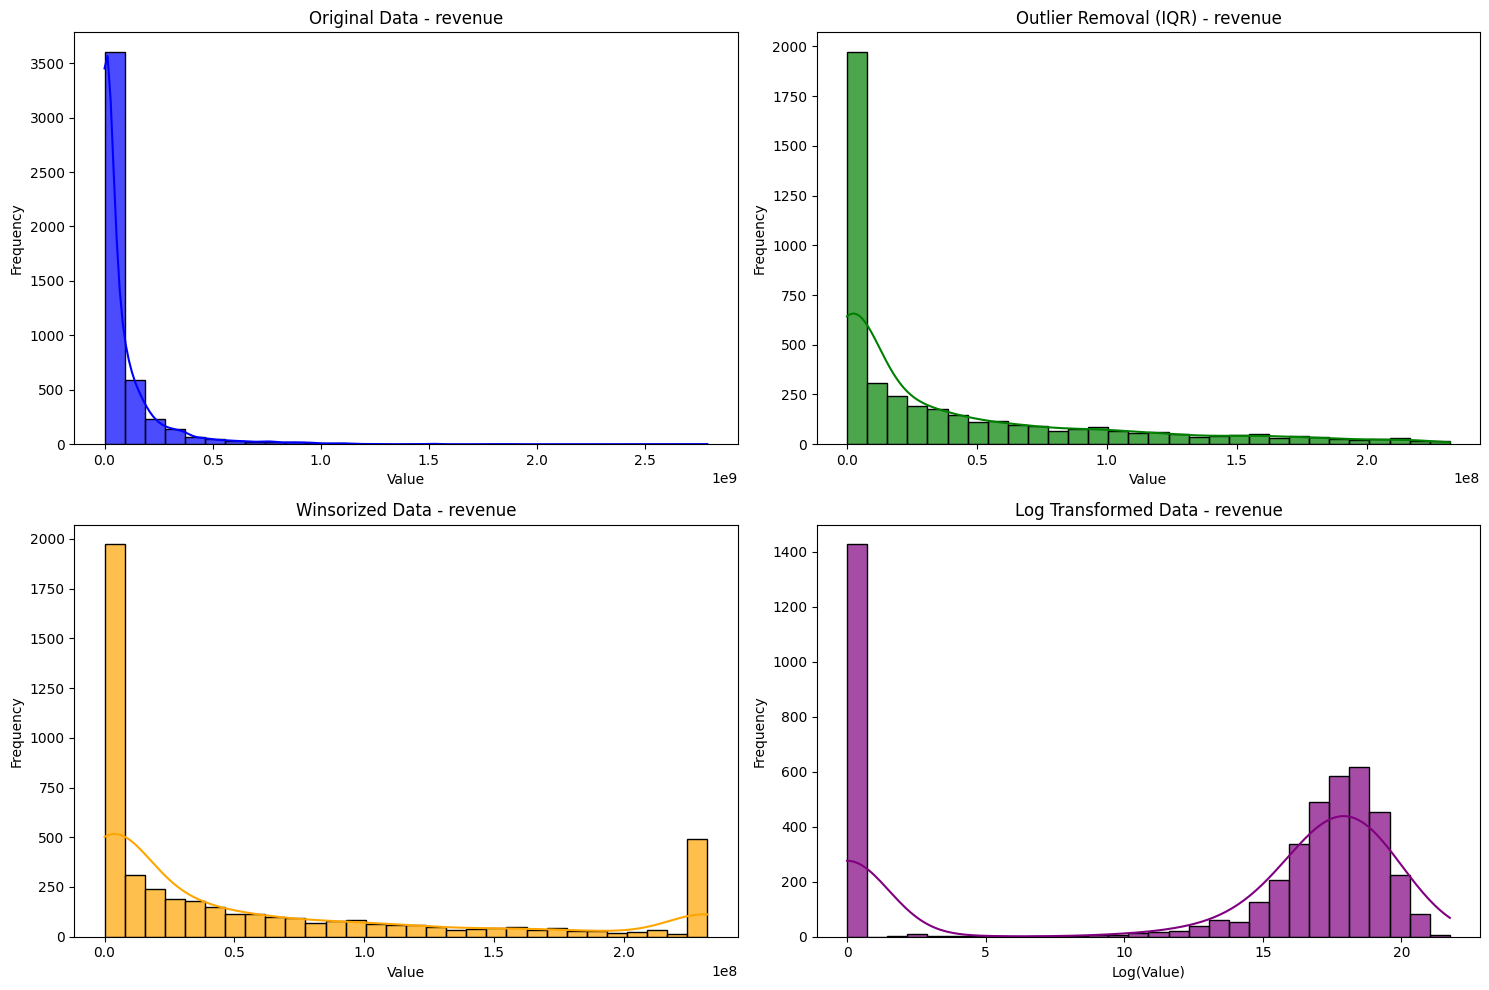


Suggested Approach:
Column 'revenue' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: runtime

Original Data:
count    4801.000000
mean      106.875859
std        22.611935
min         0.000000
25%        94.000000
50%       103.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

After Outlier Removal (IQR):
count    4619.000000
mean      105.625244
std        16.145508
min        59.000000
25%        94.000000
50%       103.000000
75%       116.000000
max       154.000000
Name: runtime, dtype: float64

After Winsorization:
count    4801.000000
mean      106.619246
std        18.382192
min        58.000000
25%        94.000000
50%       103.000000
75%       118.000000
max       154.000000
Name: runtime, dtype: float64

After Log Transformation:
count    4801.000000
mean        4.637905
std         0.435113
min         0.000000
25%         4.553877
50%  

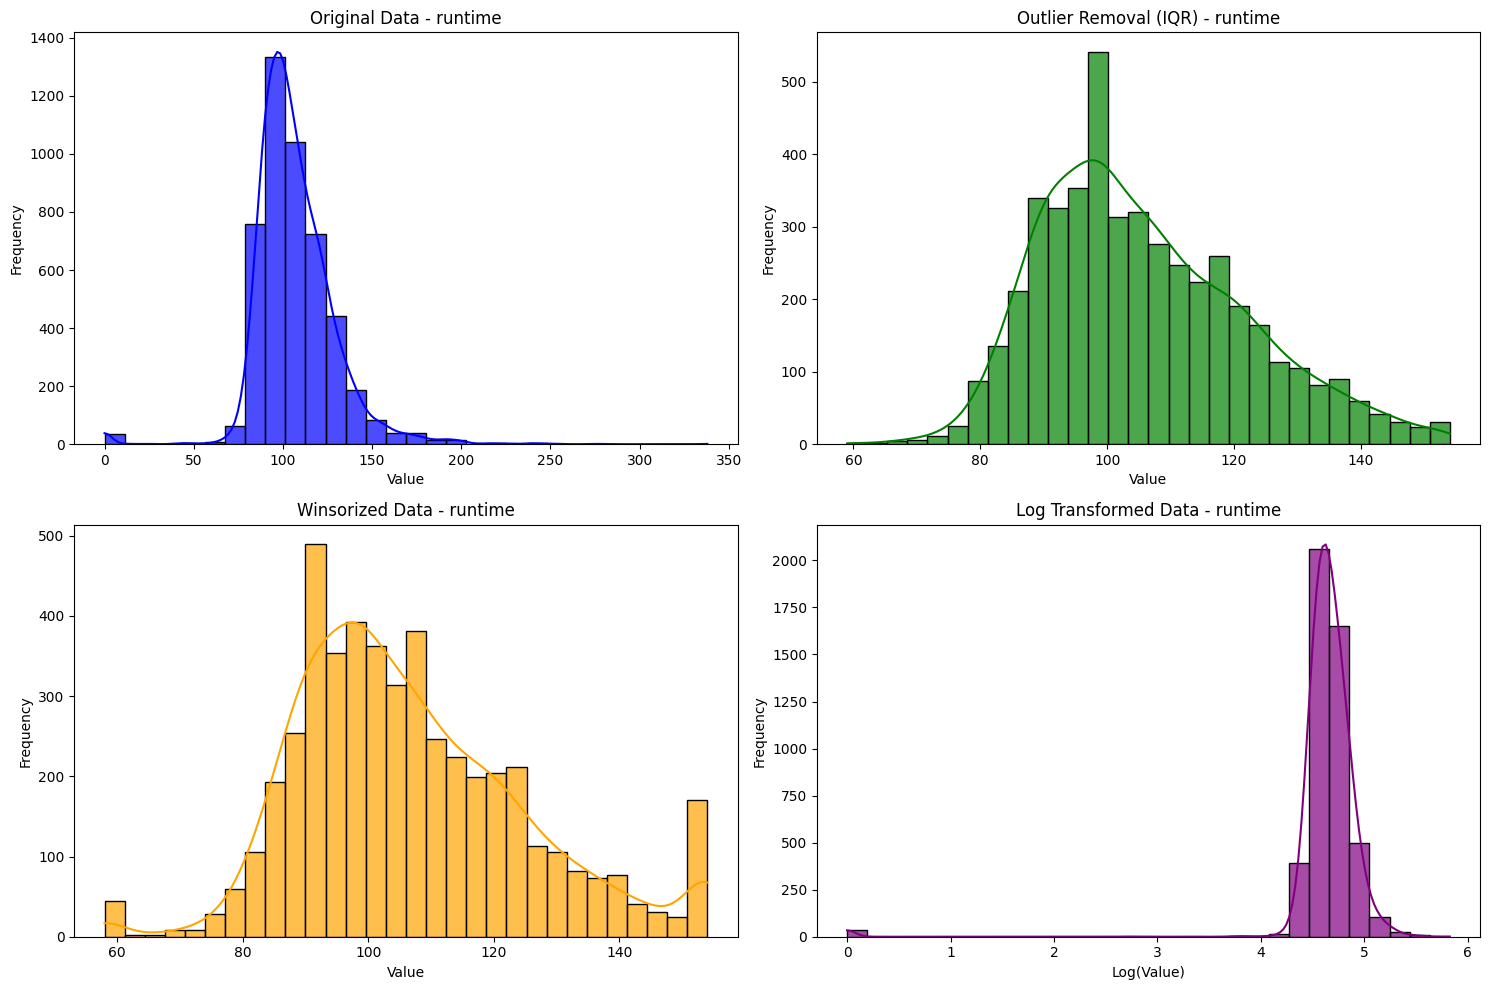


Suggested Approach:
Column 'runtime' has minimal outliers. No aggressive treatment is needed.

--------------------------------------------------------------------------------


Analyzing column: vote_average

Original Data:
count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

After Outlier Removal (IQR):
count    4647.000000
mean        6.227351
std         0.867363
min         3.800000
25%         5.700000
50%         6.300000
75%         6.800000
max         8.500000
Name: vote_average, dtype: float64

After Winsorization:
count    4803.000000
mean        6.154508
std         0.955853
min         3.800000
25%         5.600000
50%         6.200000
75%         6.800000
max         8.600000
Name: vote_average, dtype: float64

After Log Transformation:
count    4803.000000
mean        1.934304
std         0.267824
min         0.000000
25

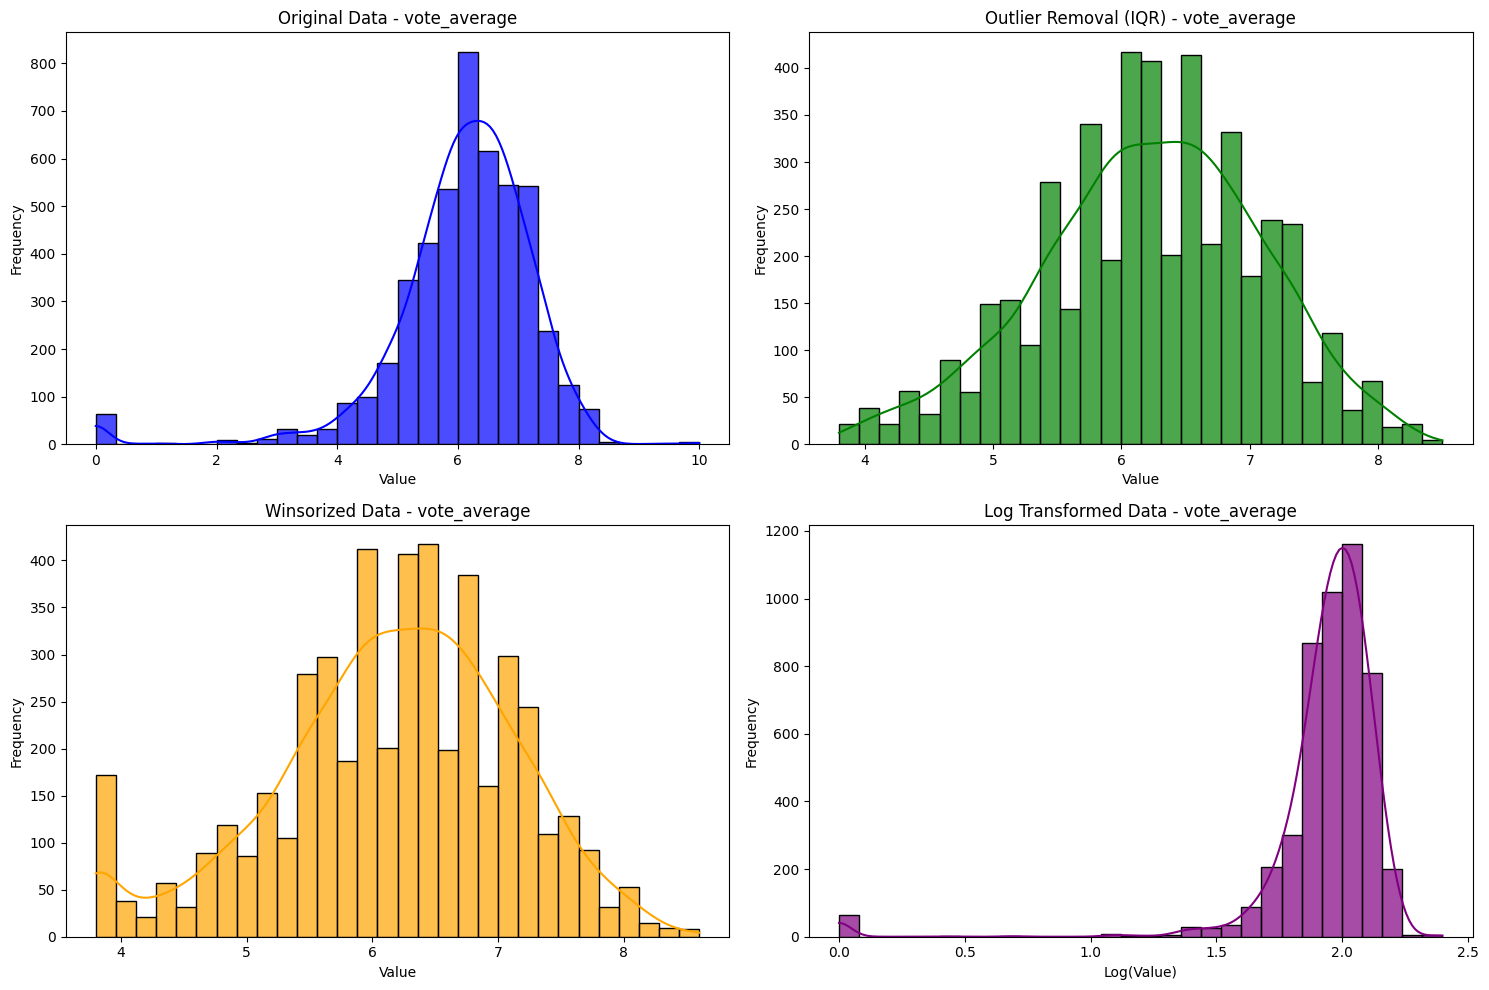


Suggested Approach:
Column 'vote_average' has minimal outliers. No aggressive treatment is needed.

--------------------------------------------------------------------------------


Analyzing column: vote_count

Original Data:
count     4803.000000
mean       690.217989
std       1234.585891
min          0.000000
25%         54.000000
50%        235.000000
75%        737.000000
max      13752.000000
Name: vote_count, dtype: float64

After Outlier Removal (IQR):
count    4299.000000
mean      349.331240
std       410.053234
min         0.000000
25%        44.000000
50%       181.000000
75%       510.500000
max      1750.000000
Name: vote_count, dtype: float64

After Winsorization:
count    4803.000000
mean      497.516344
std       581.238746
min         0.000000
25%        54.000000
50%       235.000000
75%       737.000000
max      1761.500000
Name: vote_count, dtype: float64

After Log Transformation:
count    4803.000000
mean        5.222939
std         1.903572
min         0.0000

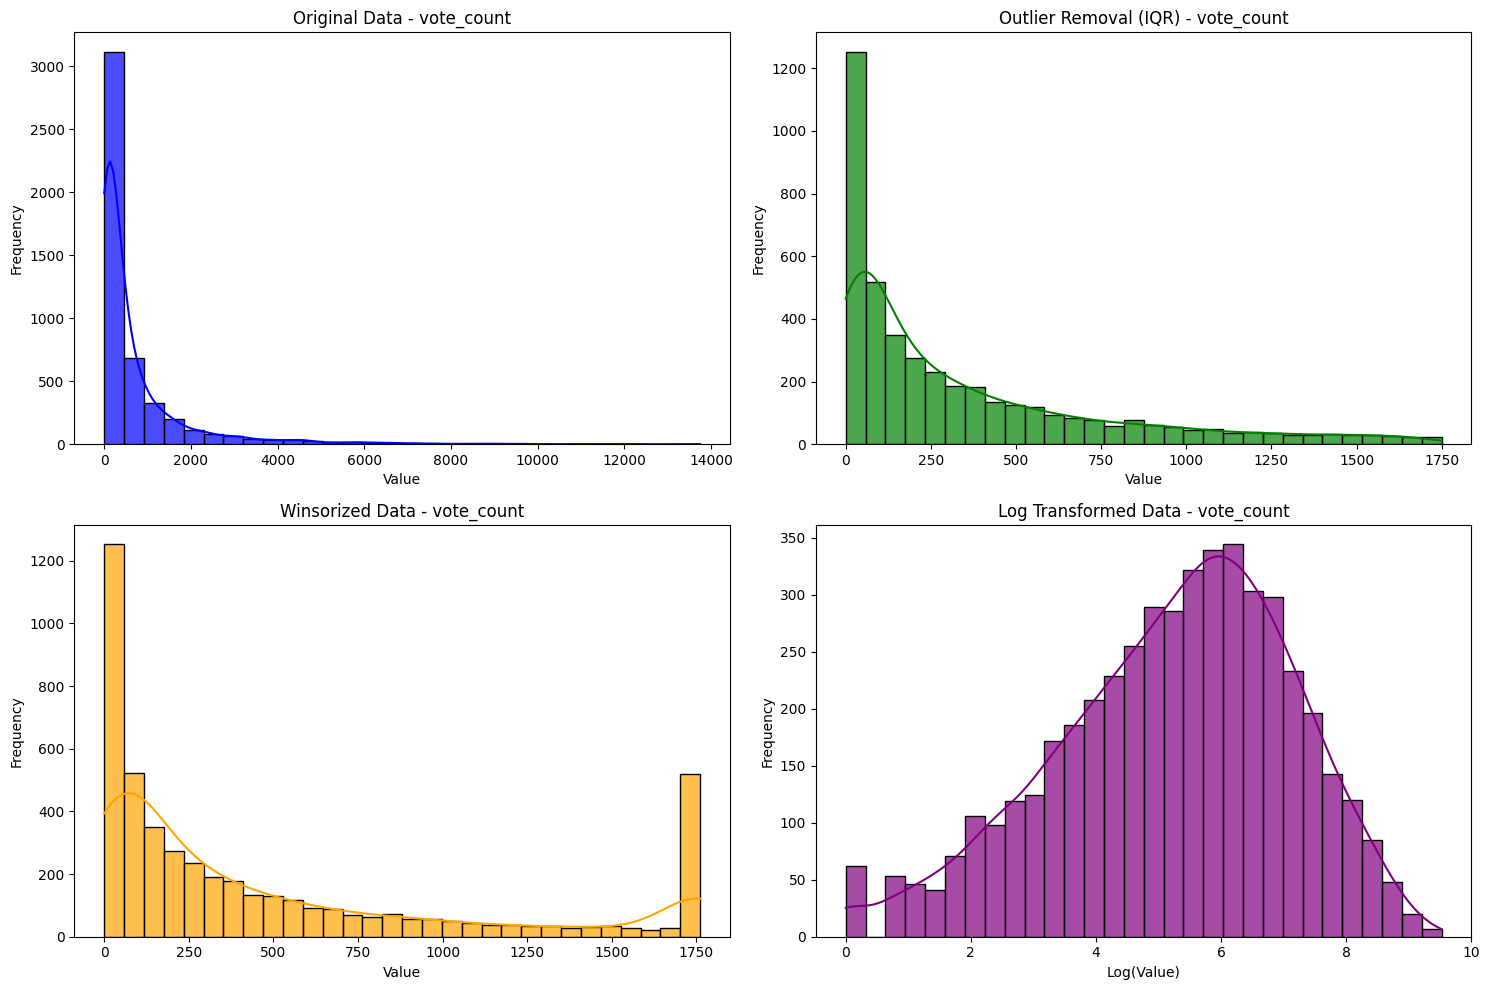


Suggested Approach:
Column 'vote_count' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: cast_id_1

Original Data:
count        4760.0
mean      21.455042
std      123.947803
min             0.0
25%             1.0
50%             3.0
75%             9.0
max          1054.0
Name: cast_id_1, dtype: Float64

After Outlier Removal (IQR):
count      4480.0
mean     4.695312
std      4.976863
min           0.0
25%           1.0
50%           2.0
75%           7.0
max          21.0
Name: cast_id_1, dtype: Float64

After Winsorization:
count      4760.0
mean     5.654412
std      6.167081
min           0.0
25%           1.0
50%           3.0
75%           9.0
max          21.0
Name: cast_id_1, dtype: Float64

After Log Transformation:
count      4760.0
mean     1.586673
std      1.094428
min           0.0
25%      0.693147
50%      1.386294
75%      2.302585
max      6.961296
Name: cast_

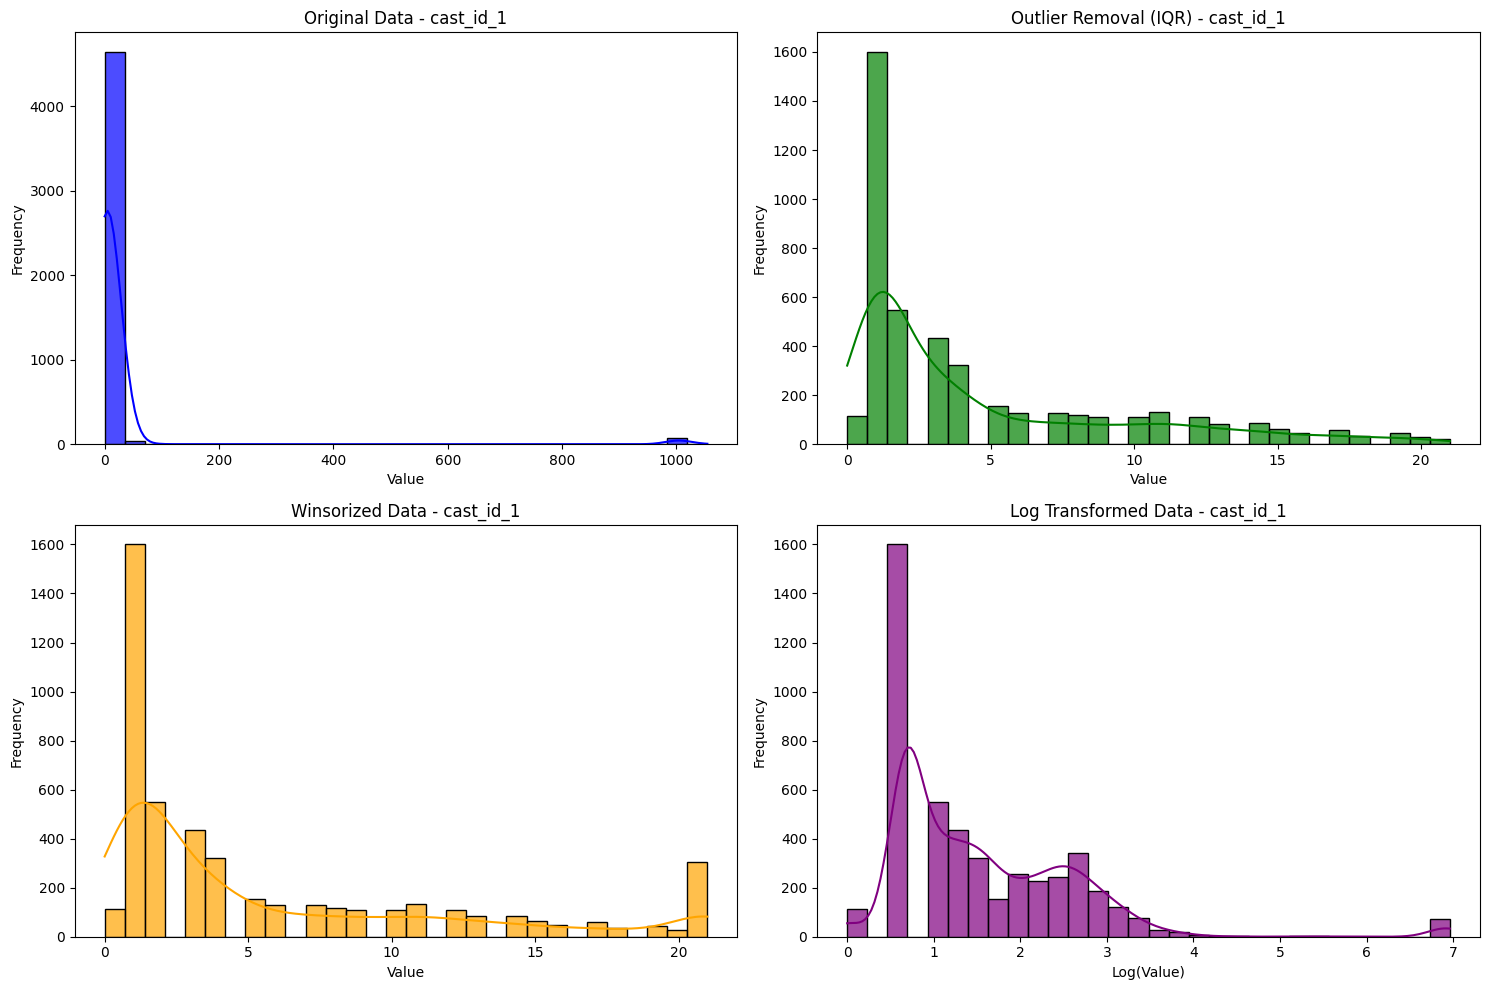


Suggested Approach:
Column 'cast_id_1' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: gender_cast_1

Original Data:
count      4760.0
mean     1.643908
std      0.583341
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_1, dtype: Float64

After Outlier Removal (IQR):
count      4760.0
mean     1.643908
std      0.583341
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_1, dtype: Float64

After Winsorization:
count      4760.0
mean     1.643908
std      0.583341
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_1, dtype: Float64

After Log Transformation:
count      4760.0
mean     0.938274
std      0.285578
min           0.0
25%      0.693147
50%      1.098612
75%      1.098612
max      1.098612
Name: gender

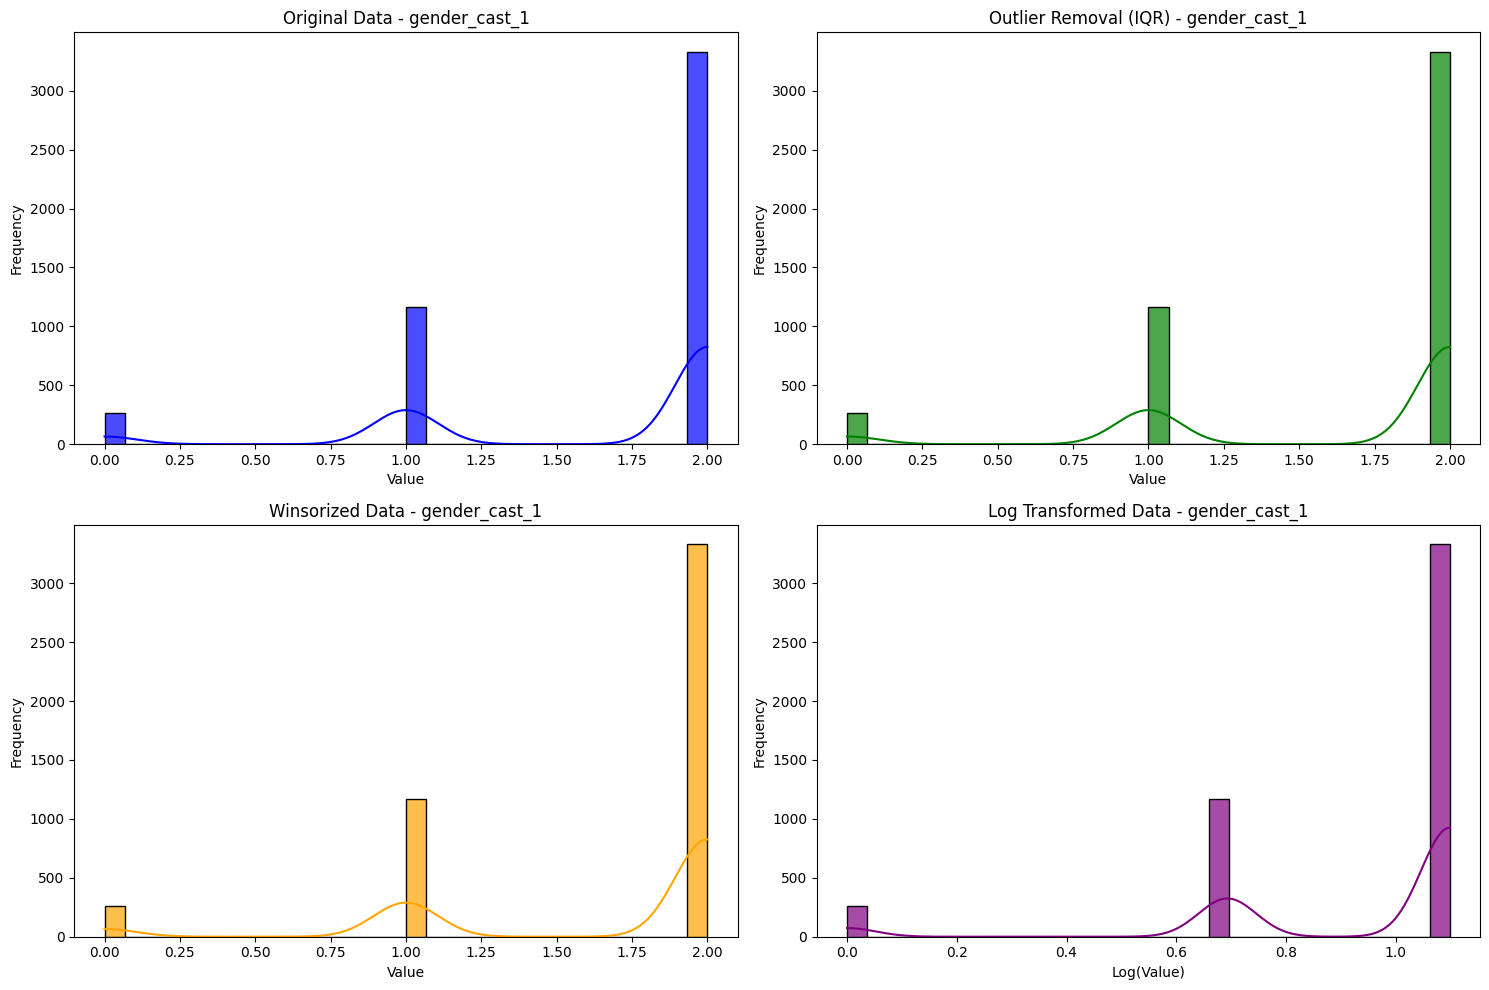


Suggested Approach:
Column 'gender_cast_1' has minimal outliers. No aggressive treatment is needed.

--------------------------------------------------------------------------------


Analyzing column: cast_id_2

Original Data:
count        4750.0
mean      22.442316
std      123.037601
min             0.0
25%             2.0
50%             4.0
75%            10.0
max          1022.0
Name: cast_id_2, dtype: Float64

After Outlier Removal (IQR):
count      4442.0
mean     5.819901
std      5.016566
min           0.0
25%           2.0
50%           4.0
75%           8.0
max          22.0
Name: cast_id_2, dtype: Float64

After Winsorization:
count      4750.0
mean     6.869053
std       6.27788
min           0.0
25%           2.0
50%           4.0
75%          10.0
max          22.0
Name: cast_id_2, dtype: Float64

After Log Transformation:
count      4750.0
mean     1.858437
std      0.970073
min           0.0
25%      1.098612
50%      1.609438
75%      2.397895
max      6.930495
Name

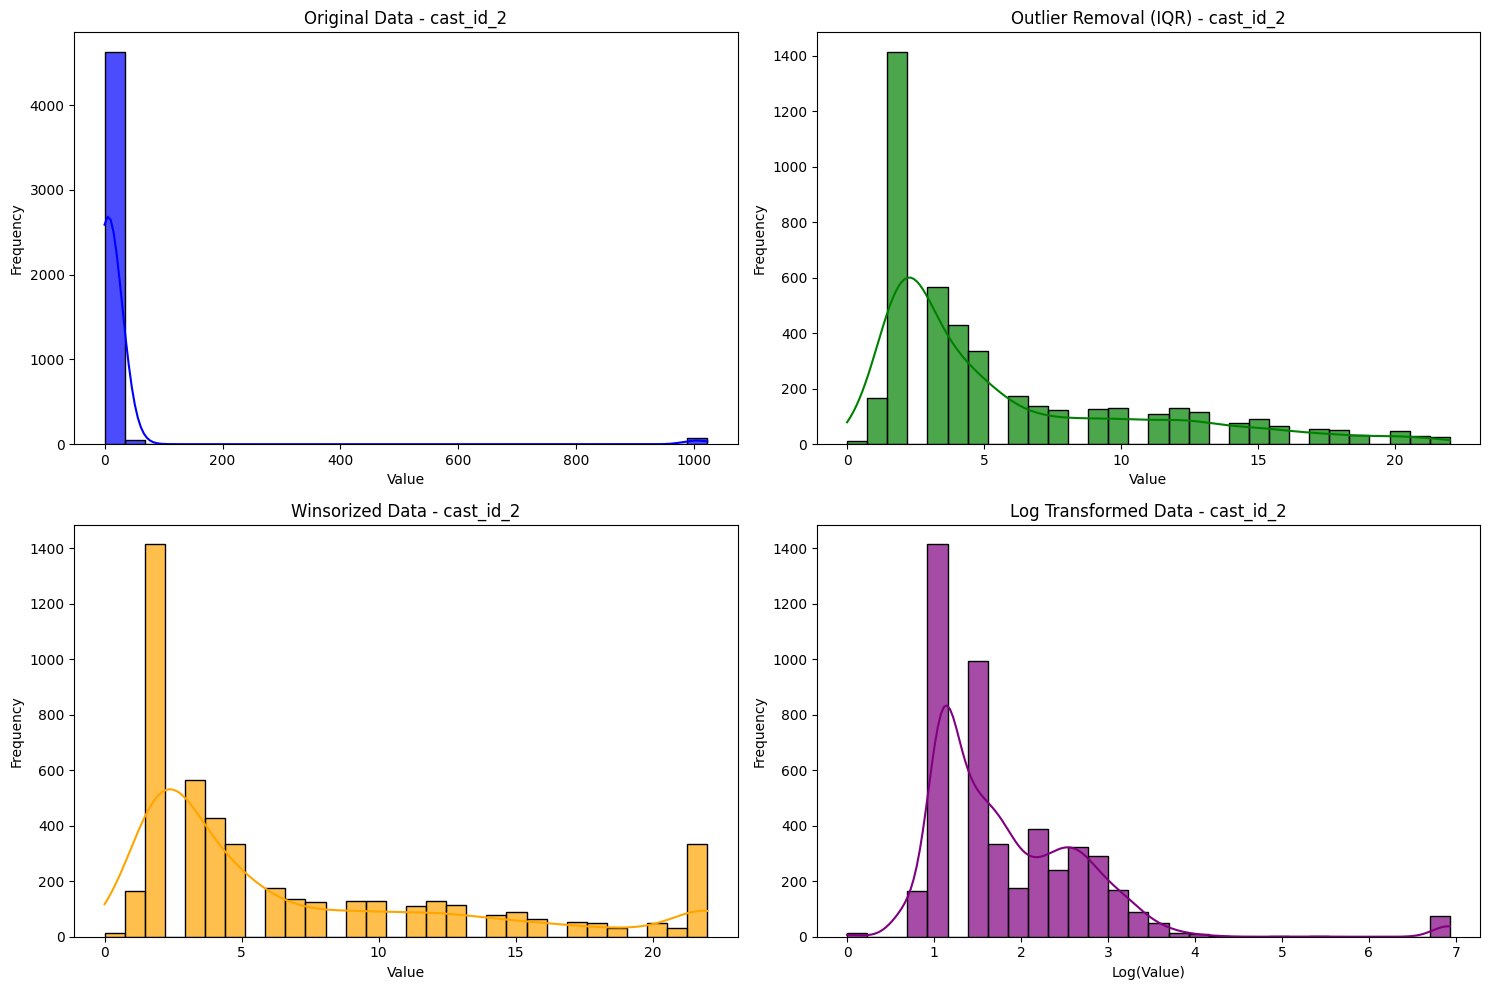


Suggested Approach:
Column 'cast_id_2' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: gender_cast_2

Original Data:
count      4750.0
mean     1.464842
std      0.641715
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_2, dtype: Float64

After Outlier Removal (IQR):
count      4750.0
mean     1.464842
std      0.641715
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_2, dtype: Float64

After Winsorization:
count      4750.0
mean     1.464842
std      0.641715
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_2, dtype: Float64

After Log Transformation:
count      4750.0
mean     0.858186
std      0.318972
min           0.0
25%      0.693147
50%      1.098612
75%      1.098612
max      1.098612
Name: gender

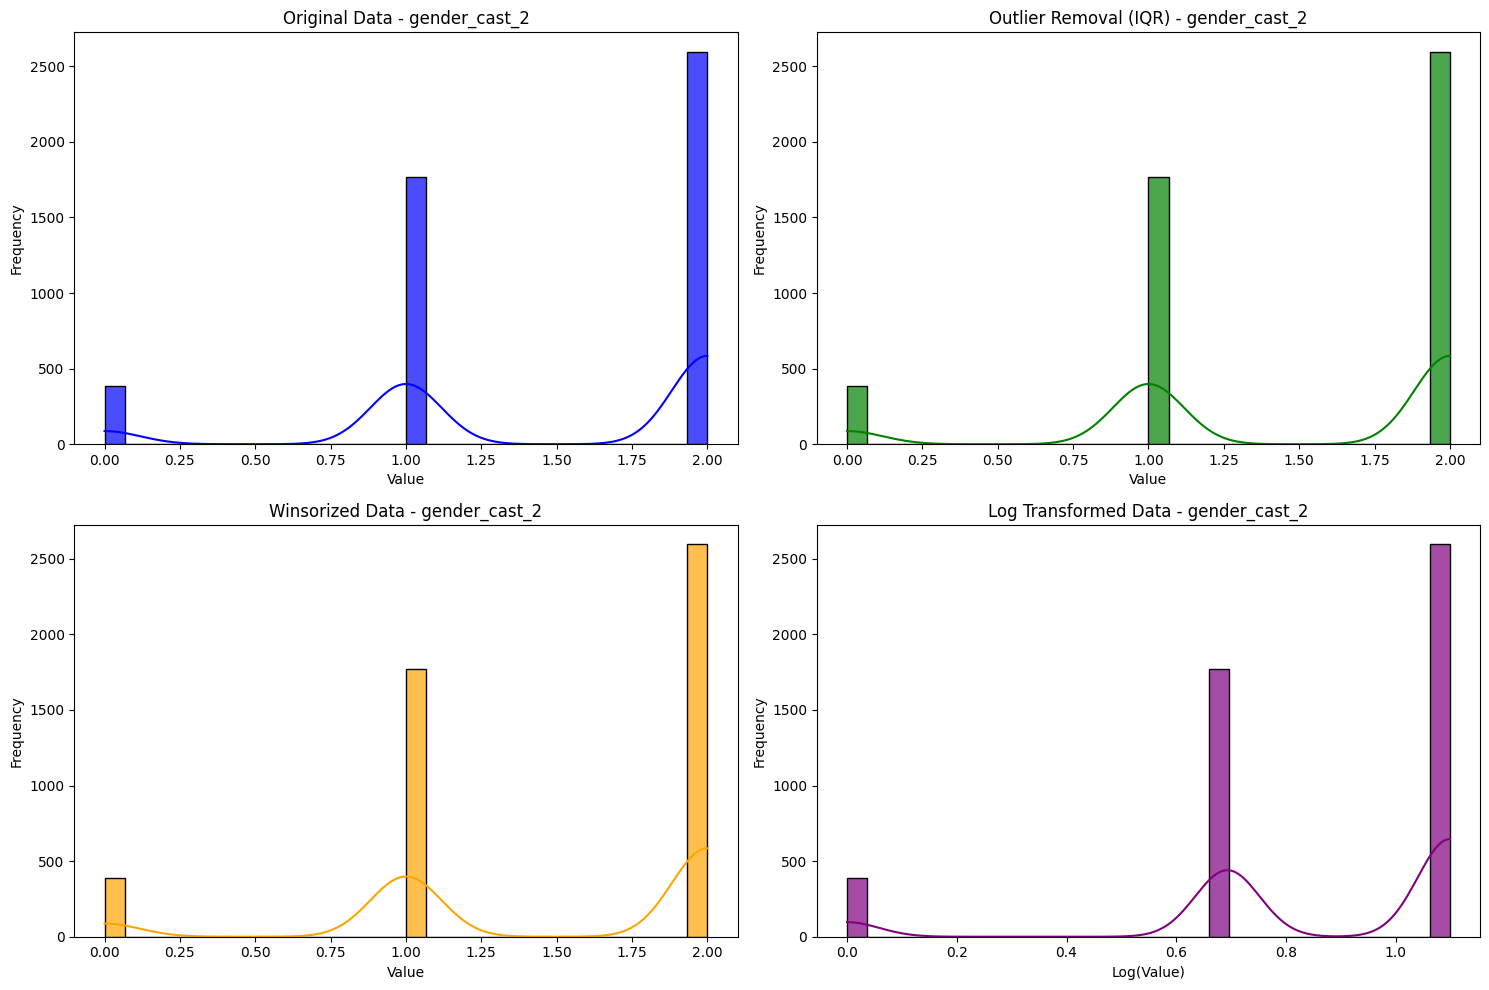


Suggested Approach:
Column 'gender_cast_2' has minimal outliers. No aggressive treatment is needed.

--------------------------------------------------------------------------------


Analyzing column: cast_id_3

Original Data:
count        4740.0
mean      23.679747
std      123.325384
min             0.0
25%             3.0
50%             5.0
75%            11.0
max          1035.0
Name: cast_id_3, dtype: Float64

After Outlier Removal (IQR):
count      4426.0
mean     6.927926
std      5.025629
min           0.0
25%           3.0
50%           5.0
75%          10.0
max          23.0
Name: cast_id_3, dtype: Float64

After Winsorization:
count      4740.0
mean     7.992616
std      6.290075
min           0.0
25%           3.0
50%           5.0
75%          11.0
max          23.0
Name: cast_id_3, dtype: Float64

After Log Transformation:
count      4740.0
mean     2.056488
std      0.892202
min           0.0
25%      1.386294
50%      1.791759
75%      2.484907
max      6.943122
Name

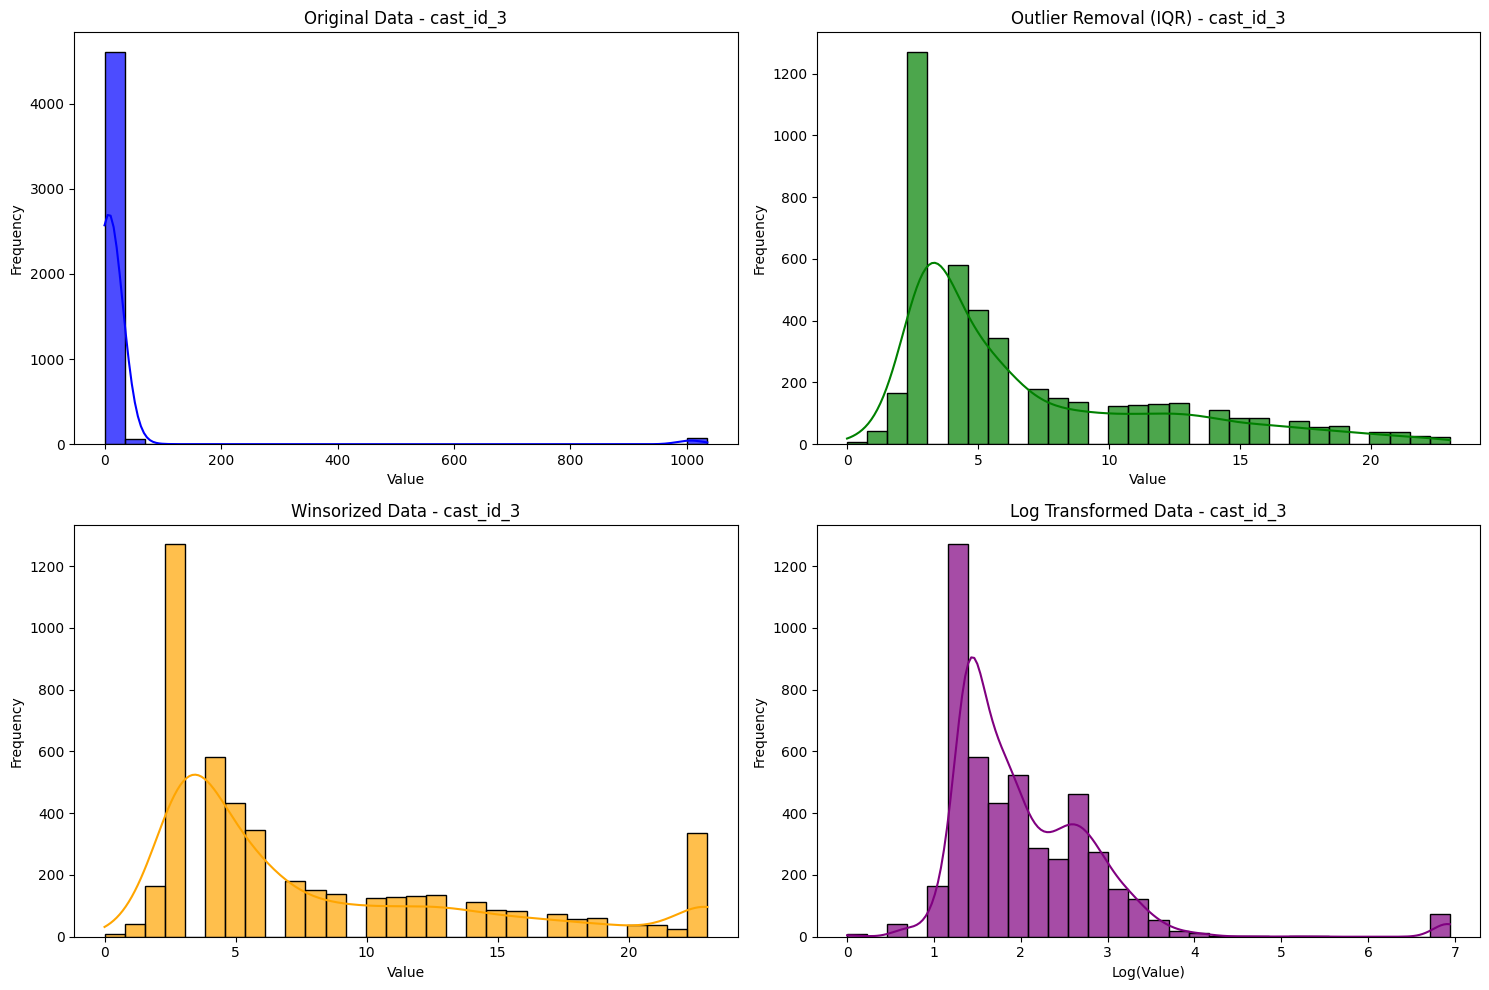


Suggested Approach:
Column 'cast_id_3' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: gender_cast_3

Original Data:
count      4740.0
mean      1.44557
std      0.670884
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_3, dtype: Float64

After Outlier Removal (IQR):
count      4740.0
mean      1.44557
std      0.670884
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_3, dtype: Float64

After Winsorization:
count      4740.0
mean      1.44557
std      0.670884
min           0.0
25%           1.0
50%           2.0
75%           2.0
max           2.0
Name: gender_cast_3, dtype: Float64

After Log Transformation:
count      4740.0
mean     0.844617
std      0.340252
min           0.0
25%      0.693147
50%      1.098612
75%      1.098612
max      1.098612
Name: gender

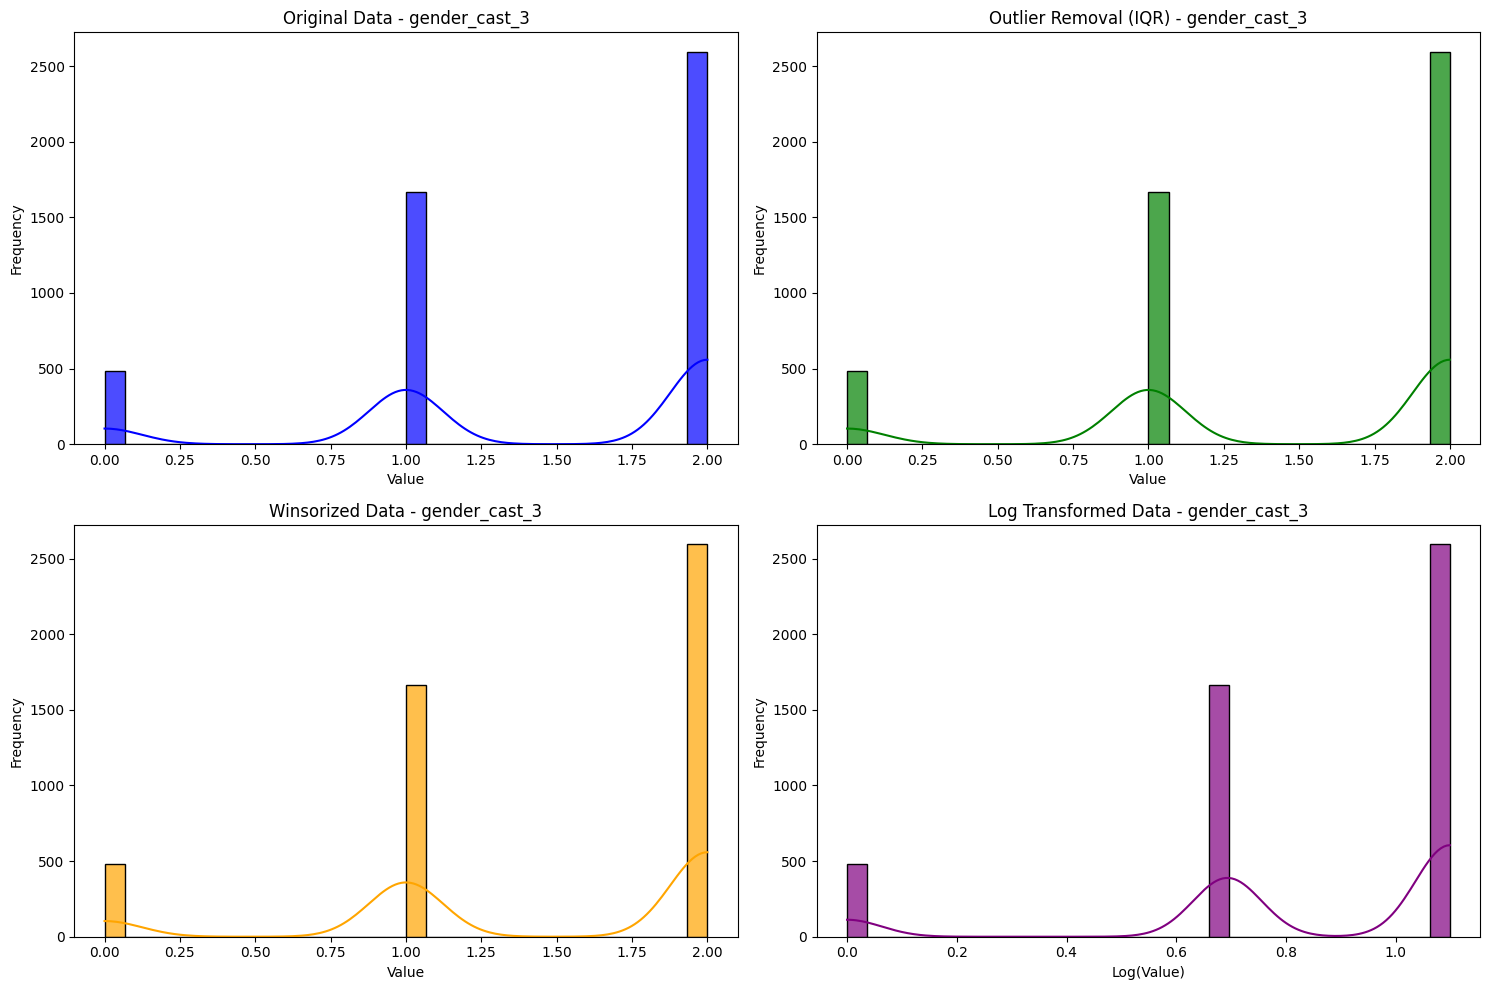


Suggested Approach:
Column 'gender_cast_3' has minimal outliers. No aggressive treatment is needed.

--------------------------------------------------------------------------------


Analyzing column: director_id

Original Data:
count           4773.0
mean     111616.267337
std       280086.18877
min                1.0
25%             7397.0
50%            25210.0
75%            67813.0
max          1867383.0
Name: director_id, dtype: Float64

After Outlier Removal (IQR):
count          4353.0
mean     35810.763841
std      35766.889177
min               1.0
25%            6349.0
50%           19684.0
75%           58375.0
max          157879.0
Name: director_id, dtype: Float64

After Winsorization:
count          4773.0
mean     46601.256023
std      48720.560523
min               1.0
25%            7397.0
50%           25210.0
75%           67813.0
max          158437.0
Name: director_id, dtype: Float64

After Log Transformation:
count       4773.0
mean      9.981818
std       1.97

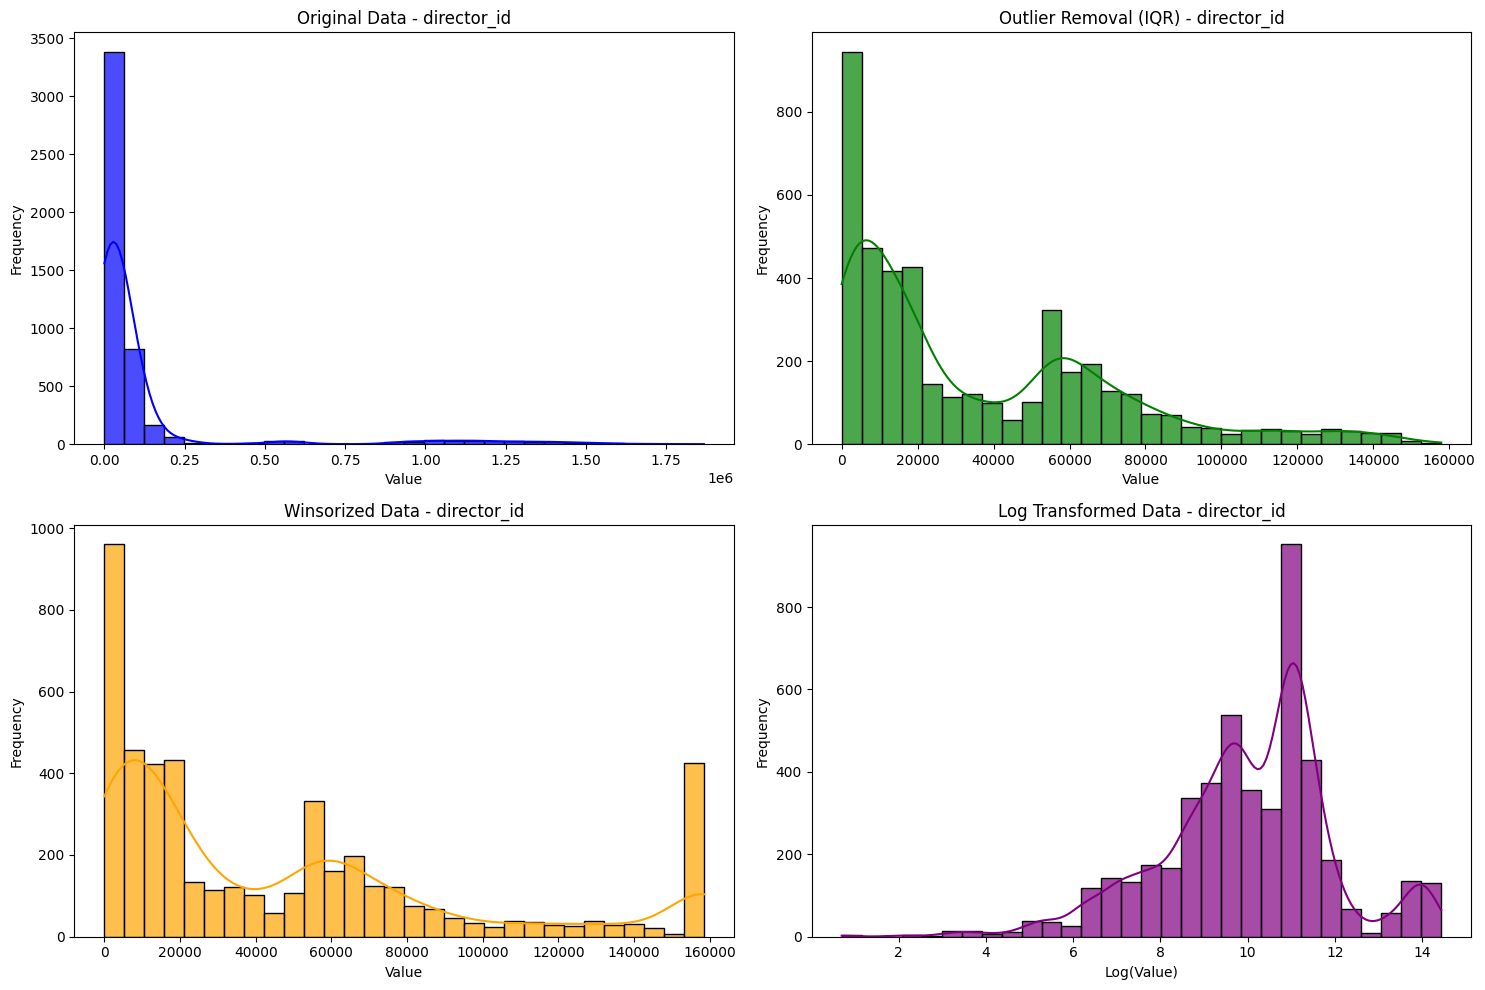


Suggested Approach:
Column 'director_id' is highly skewed. Log transformation is recommended.

--------------------------------------------------------------------------------


Analyzing column: director_gender

Original Data:
count      4773.0
mean     1.573224
std      0.787802
min           0.0
25%           2.0
50%           2.0
75%           2.0
max           2.0
Name: director_gender, dtype: Float64

After Outlier Removal (IQR):
count    3633.0
mean        2.0
std         0.0
min         2.0
25%         2.0
50%         2.0
75%         2.0
max         2.0
Name: director_gender, dtype: Float64

After Winsorization:
count    4773.0
mean        2.0
std         0.0
min         2.0
25%         2.0
50%         2.0
75%         2.0
max         2.0
Name: director_gender, dtype: Float64

After Log Transformation:
count      4773.0
mean     0.871505
std       0.42855
min           0.0
25%      1.098612
50%      1.098612
75%      1.098612
max      1.098612
Name: director_gender, dtype: Floa

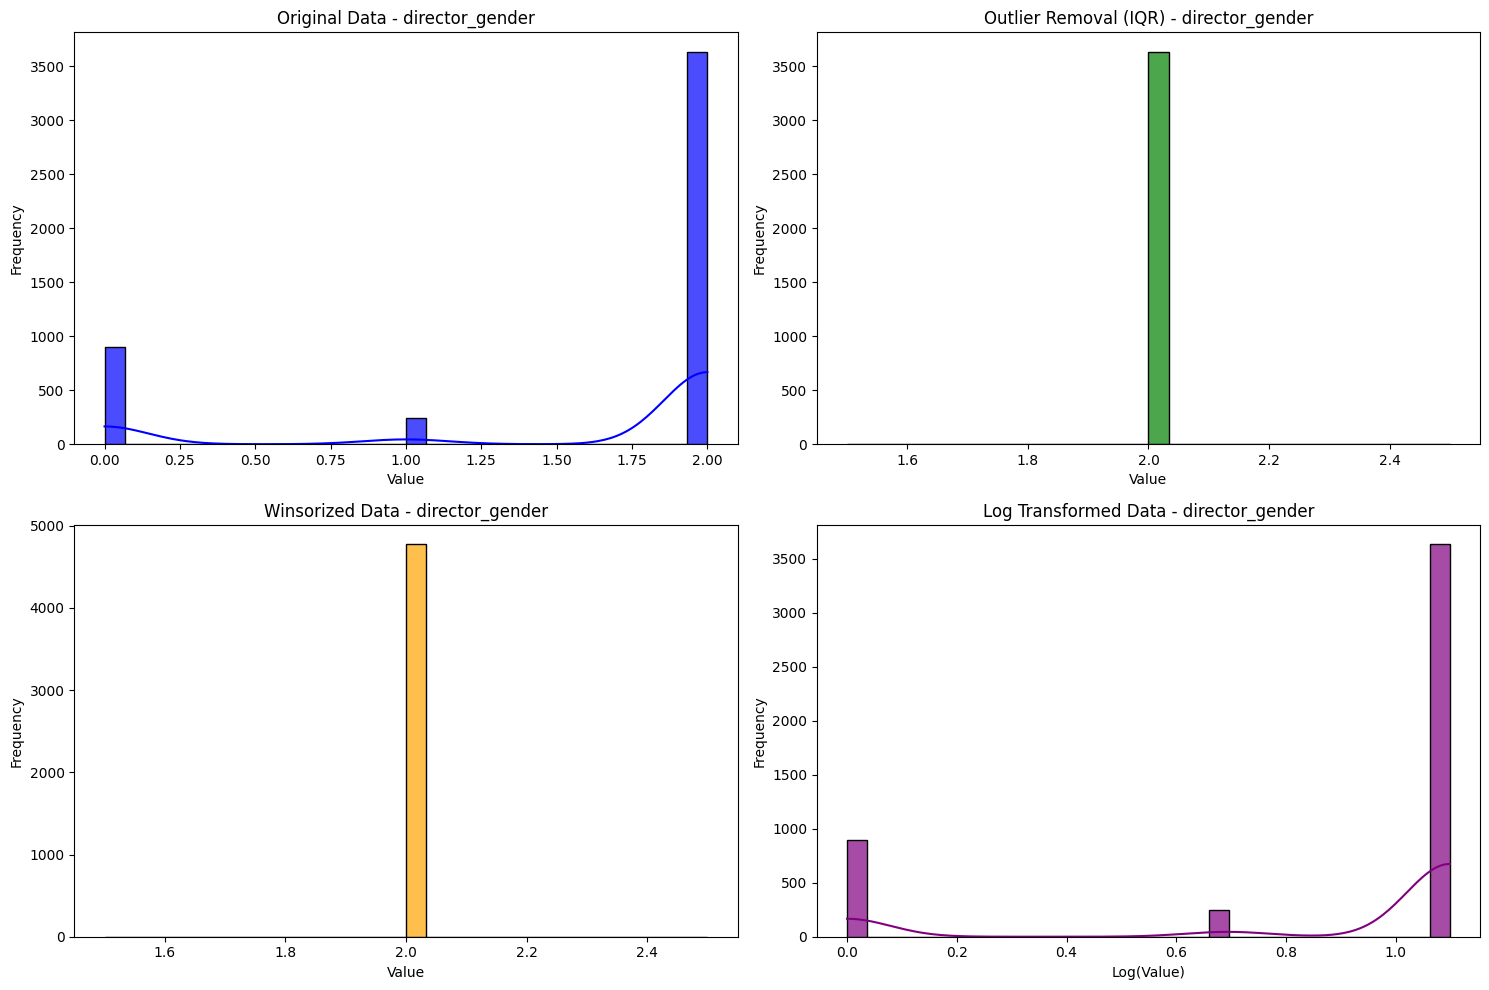


Suggested Approach:
Column 'director_gender' has many outliers. Winsorization or IQR-based removal is recommended.

--------------------------------------------------------------------------------



In [85]:
def analyze_outliers_for_all_columns(df, bins=30):
    """
    Analyzes outliers for all numeric columns in the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - bins (int): The number of bins for the histogram.
    """
    numeric_columns = df.select_dtypes(include=np.number).columns

    if len(numeric_columns) == 0:
        print("No numeric columns found in the DataFrame.")
        return

    for column in numeric_columns:
        print(f"\nAnalyzing column: {column}\n")
        
        data_original = df[column].dropna()

        if data_original.empty:
            print(f"Column '{column}' contains only None/NaN values. Skipping...\n")
            continue

        Q1 = data_original.quantile(0.25)
        Q3 = data_original.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_no_outliers = data_original[(data_original >= lower_bound) & (data_original <= upper_bound)]

        data_winsorized = data_original.clip(lower=lower_bound, upper=upper_bound)

        data_log_transformed = np.log1p(data_original)

        print("Original Data:")
        print(data_original.describe())
        print("\nAfter Outlier Removal (IQR):")
        print(data_no_outliers.describe())
        print("\nAfter Winsorization:")
        print(data_winsorized.describe())
        print("\nAfter Log Transformation:")
        print(data_log_transformed.describe())

        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        sns.histplot(data_original, bins=bins, kde=True, color='blue', alpha=0.7)
        plt.title(f'Original Data - {column}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

        plt.subplot(2, 2, 2)
        sns.histplot(data_no_outliers, bins=bins, kde=True, color='green', alpha=0.7)
        plt.title(f'Outlier Removal (IQR) - {column}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

        plt.subplot(2, 2, 3)
        sns.histplot(data_winsorized, bins=bins, kde=True, color='orange', alpha=0.7)
        plt.title(f'Winsorized Data - {column}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

        plt.subplot(2, 2, 4)
        sns.histplot(data_log_transformed, bins=bins, kde=True, color='purple', alpha=0.7)
        plt.title(f'Log Transformed Data - {column}')
        plt.xlabel('Log(Value)')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

        print("\nSuggested Approach:")
        if data_original.skew() > 2:
            print(f"Column '{column}' is highly skewed. Log transformation is recommended.")
        elif len(data_original) - len(data_no_outliers) > 0.1 * len(data_original):
            print(f"Column '{column}' has many outliers. Winsorization or IQR-based removal is recommended.")
        else:
            print(f"Column '{column}' has minimal outliers. No aggressive treatment is needed.")

        print("\n" + "-" * 80 + "\n")

analyze_outliers_for_all_columns(movies)


#### 1. **Column: `budget`**
- **Findings**:
  - Highly skewed data, with a mean budget of $29 million but a maximum of $380 million.
  - After outlier removal using the IQR method, the maximum budget was reduced to $98 million, significantly lowering the standard deviation.
- **Recommendation**:
  - Apply log transformation to reduce skewness and normalize the data distribution.

#### 2. **Column: `movie_id`**
- **Findings**:
  - Highly skewed with extreme values, as shown by a maximum of 459,488.
  - After outlier removal, the distribution became more concentrated, but skewness persisted.
- **Recommendation**:
  - Apply log transformation to handle the skewness effectively.

#### 3. **Column: `popularity`**
- **Findings**:
  - Strongly skewed, with a mean of 21.49 but a maximum value of 875.58.
  - IQR removal reduced the maximum to 6.78, lowering the mean to 16.42.
- **Recommendation**:
  - Apply log transformation to normalize the data for downstream tasks.

#### 4. **Column: `release_date`**
- **Findings**:
  - Minimal outliers, with most movies released between 1981 and 2017.
  - The dataset exhibits a relatively uniform distribution post-IQR removal.
- **Recommendation**:
  - No aggressive treatment is necessary for this column.

#### 5. **Column: `revenue`**
- **Findings**:
  - Highly skewed, with extreme values such as a maximum of $2.78 billion.
  - IQR removal reduced the maximum to $217 million and the mean to $39.7 million, significantly improving distribution.
- **Recommendation**:
  - Use log transformation to normalize skewed data.

#### 6. **Column: `runtime`**
- **Findings**:
  - Minimal outliers, with most movies having a runtime between 94 and 118 minutes.
  - Post-IQR removal, the data shows minimal change in distribution.
- **Recommendation**:
  - No aggressive treatment is required for this column.

#### 7. **Column: `vote_average`**
- **Findings**:
  - Small variability in audience ratings, with most ratings clustering between 5.6 and 6.8.
  - Minimal impact of outlier removal on data distribution.
- **Recommendation**:
  - No aggressive outlier treatment is necessary.

#### 8. **Column: `vote_count`**
- **Findings**:
  - Strongly skewed, with a mean of 690 but a maximum of 13,752 votes.
  - IQR removal reduced the maximum to 9,529 votes, lowering the mean to 349.
- **Recommendation**:
  - Log transformation is recommended to address skewness.

#### 9. **Columns: `cast_id_1`, `cast_id_2`, `cast_id_3`**
- **Findings**:
  - Highly skewed, with extreme values like 1,054 for `cast_id_1`.
  - IQR removal reduced maximum values significantly, improving data consistency.
- **Recommendation**:
  - Apply log transformation to reduce skewness for all cast ID columns.

#### 10. **Columns: `gender_cast_1`, `gender_cast_2`, `gender_cast_3`**
- **Findings**:
  - Minimal variability in data, with most values being either 1 or 2.
  - Outlier removal had little effect due to the categorical nature of the data.
- **Recommendation**:
  - No additional treatment is required.

#### 11. **Column: `director_id`**
- **Findings**:
  - Highly skewed, with a maximum value of 1,867,383.
  - IQR removal improved distribution, but skewness persisted.
- **Recommendation**:
  - Apply log transformation for normalization.

#### 12. **Column: `director_gender`**
- **Findings**:
  - Minimal variability, with most values being 2.
  - IQR removal did not significantly affect the distribution.
- **Recommendation**:
  - Consider winsorization or leave as is, given the categorical nature of the data.

In [86]:
def generate_recommendation_dict(df):
    """
    Generates a dictionary of recommendations for treating outliers in numeric columns.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    """
    recommendations = {}

    numeric_columns = df.select_dtypes(include=np.number).columns

    for column in numeric_columns:
        data_original = df[column].dropna()

        if data_original.empty:
            continue

        Q1 = data_original.quantile(0.25)
        Q3 = data_original.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_removed = data_original[(data_original >= lower_bound) & (data_original <= upper_bound)]

        skewness = data_original.skew()

        if skewness > 2:
            recommendations[column] = 'log'
        elif len(data_original) - len(outliers_removed) > 0.1 * len(data_original):
            recommendations[column] = 'winsorization'
        else:
            recommendations[column] = 'none'

    return recommendations

def treat_columns_based_on_analysis(df):
    """
    Treats numeric columns based on the recommendations generated by `generate_recommendation_dict`.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    """
    recommendations = generate_recommendation_dict(df)

    transformed_df = df.copy()

    for column, action in recommendations.items():
        if column in transformed_df.columns:
            column_data = transformed_df[column].dropna()

            if action == 'log':
                transformed_df[column] = np.log1p(column_data)
            elif action == 'winsorization':
                Q1 = column_data.quantile(0.25)
                Q3 = column_data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                transformed_df[column] = column_data.clip(lower=lower_bound, upper=upper_bound)
            elif action == 'none':
                pass
            else:
                raise ValueError(f"Unknown treatment action: {action}")

    return transformed_df

def compare_before_after(df_original, df_transformed, recommendations, bins=30):
    """
    Compares the distribution of numeric columns before and after transformation.

    Parameters:
    - df_original (DataFrame): The original DataFrame.
    - df_transformed (DataFrame): The transformed DataFrame.
    - recommendations (dict): The dictionary of recommendations.
    - bins (int): The number of bins for the histogram.
    """
    numeric_columns = df_original.select_dtypes(include=np.number).columns

    num_cols = len(numeric_columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols), constrained_layout=True)

    for i, column in enumerate(numeric_columns):
        if column not in recommendations:
            continue

        sns.histplot(
            df_original[column].dropna(),
            bins=bins,
            kde=True,
            ax=axes[i, 0],
            color='blue',
            alpha=0.7
        )
        axes[i, 0].set_title(f"Original - {column}")
        axes[i, 0].set_xlabel("Value")
        axes[i, 0].set_ylabel("Frequency")

        sns.histplot(
            df_transformed[column].dropna(),
            bins=bins,
            kde=True,
            ax=axes[i, 1],
            color='green',
            alpha=0.7
        )
        axes[i, 1].set_title(f"Transformed - {column}")
        axes[i, 1].set_xlabel("Value")
        axes[i, 1].set_ylabel("Frequency")

    fig.suptitle("Comparison of Columns Before and After Transformation", fontsize=16)
    plt.show()


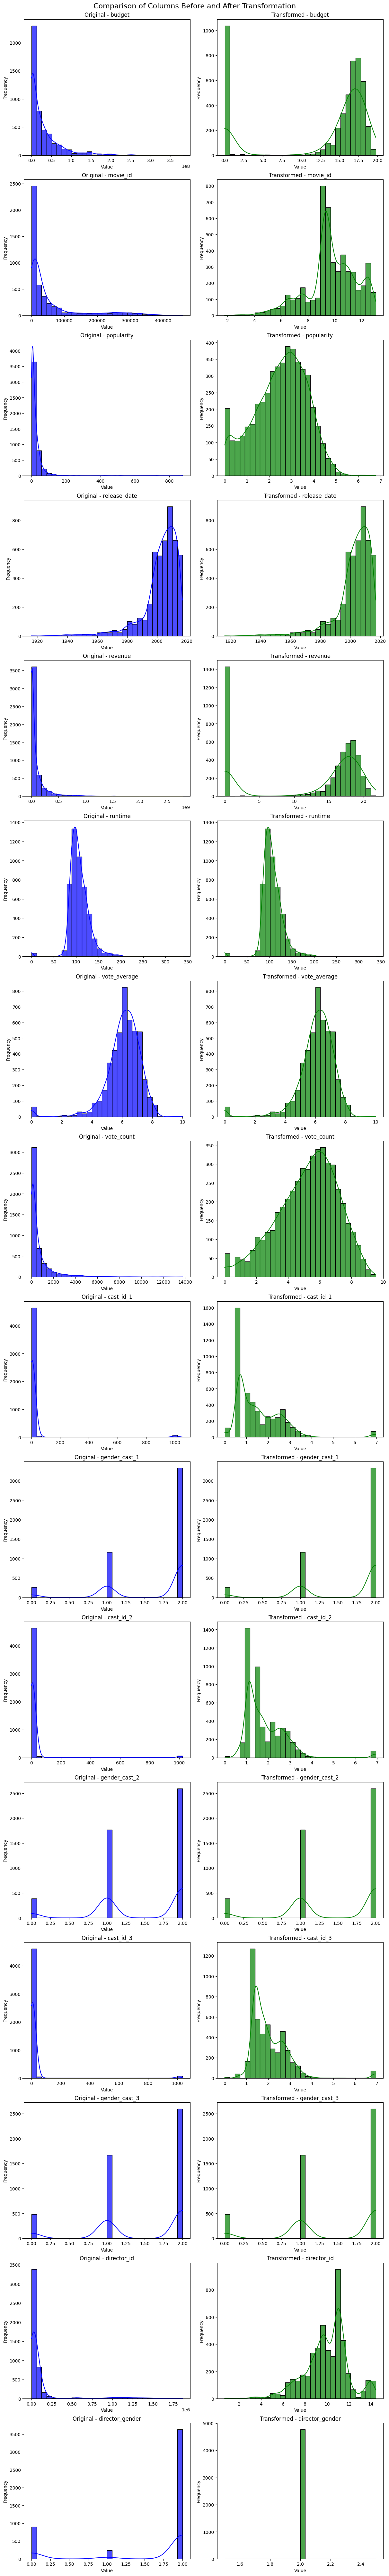

In [87]:
recommendations = generate_recommendation_dict(movies)
transformed_movies = treat_columns_based_on_analysis(movies)

compare_before_after(movies, transformed_movies, recommendations)

#### Key Observations

1. **Budget**:
   - **Original Distribution**: Highly right-skewed with a concentration of values near zero and a few extreme outliers.
   - **Log-Transformed Distribution**: The transformation effectively normalized the distribution, creating a more balanced and symmetrical shape.

2. **Movie ID**:
   - **Original Distribution**: Strongly skewed with large gaps between values.
   - **Log-Transformed Distribution**: The log transformation reduced skewness but retained the unique distribution characteristics of this identifier field.

3. **Popularity**:
   - **Original Distribution**: Significant skewness, with most values concentrated near zero and a few very high outliers.
   - **Log-Transformed Distribution**: The transformation reduced skewness, resulting in a more even spread of values.

4. **Revenue**:
   - **Original Distribution**: Highly skewed, with most values near zero and outliers in the billions.
   - **Log-Transformed Distribution**: Log transformation greatly improved the distribution's symmetry, making it more suitable for predictive modeling.

5. **Vote Count**:
   - **Original Distribution**: Right-skewed, with a high concentration of lower values and some extreme outliers.
   - **Log-Transformed Distribution**: A more normalized shape was achieved, reducing the impact of outliers.

6. **Runtime**:
   - **Original Distribution**: Relatively normal with minimal skewness, though a few outliers were present.
   - **Log-Transformed Distribution**: No significant improvement was observed as the original data was already close to normal.

7. **Vote Average**:
   - **Original Distribution**: Relatively normal with slight clustering around specific values (e.g., 6.0 to 7.0).
   - **Log-Transformed Distribution**: Minimal changes, as the data was already well-distributed.

8. **Cast IDs (1, 2, and 3)**:
   - **Original Distribution**: Highly skewed, with many low values and few very high outliers.
   - **Log-Transformed Distribution**: The transformation successfully reduced skewness, resulting in more usable data distributions for analysis.

9. **Gender Columns**:
   - **Original Distribution**: Categorical, with minimal variability.
   - **Log-Transformed Distribution**: No notable impact, as these columns are categorical in nature and not suited for log transformation.

10. **Director ID**:
    - **Original Distribution**: Extremely skewed with a wide range of values.
    - **Log-Transformed Distribution**: Significant improvement in symmetry, making the data more usable for modeling tasks.

11. **Director Gender**:
    - **Original Distribution**: Categorical with minimal variability.
    - **Log-Transformed Distribution**: As expected, the log transformation had no effect on this categorical column.

#### Conclusions

1. **Effective Normalization**:
   - Log transformation significantly improved the distributions of highly skewed columns, such as `budget`, `popularity`, `revenue`, and `vote_count`. These transformations make the data more suitable for regression and machine learning models.

2. **Minimal Impact on Normal or Categorical Data**:
   - Columns like `runtime`, `vote_average`, and categorical fields (`gender_cast`, `director_gender`) showed minimal changes as they were already well-distributed or not suited for transformation.

3. **Improved Usability**:
   - By reducing skewness, log-transformed data enhances the interpretability and robustness of statistical analyses and machine learning models.

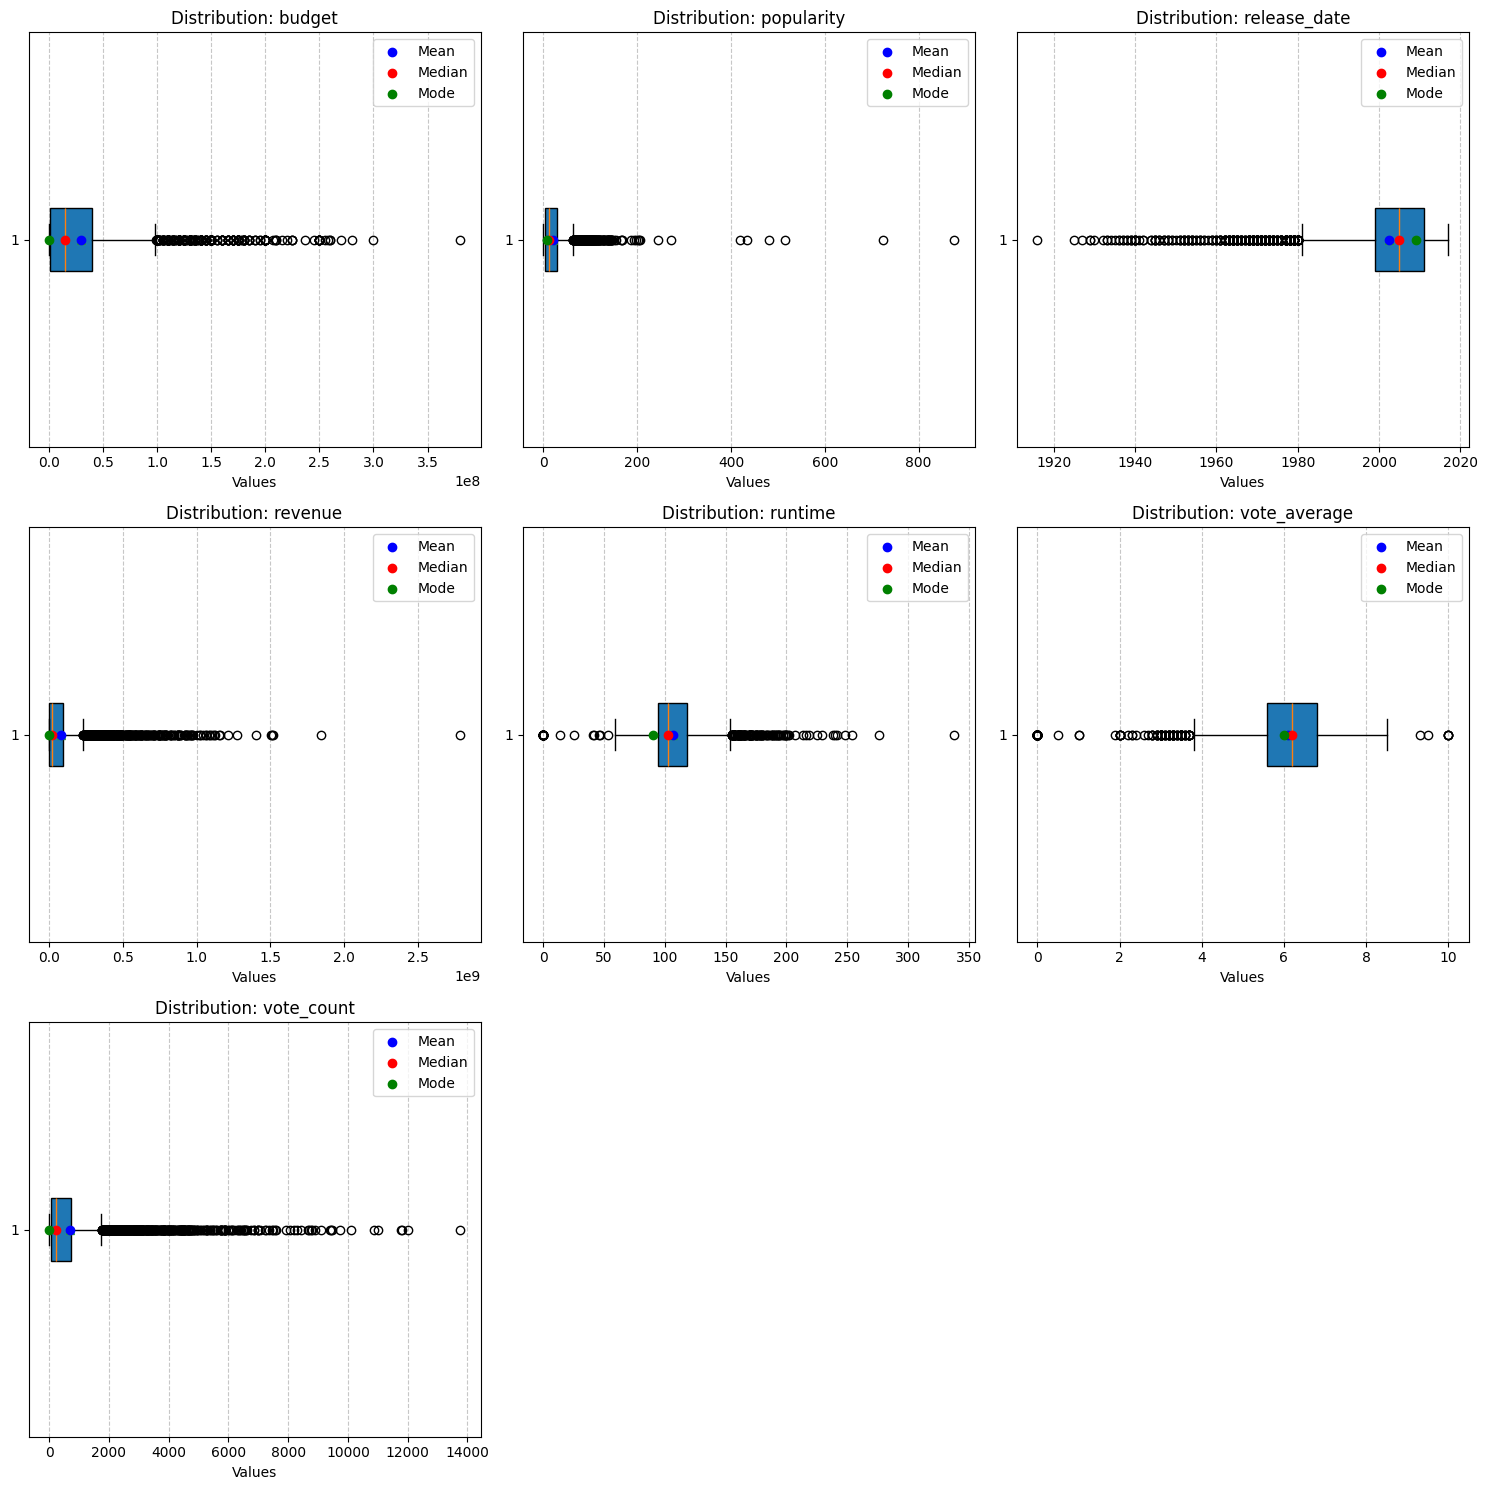

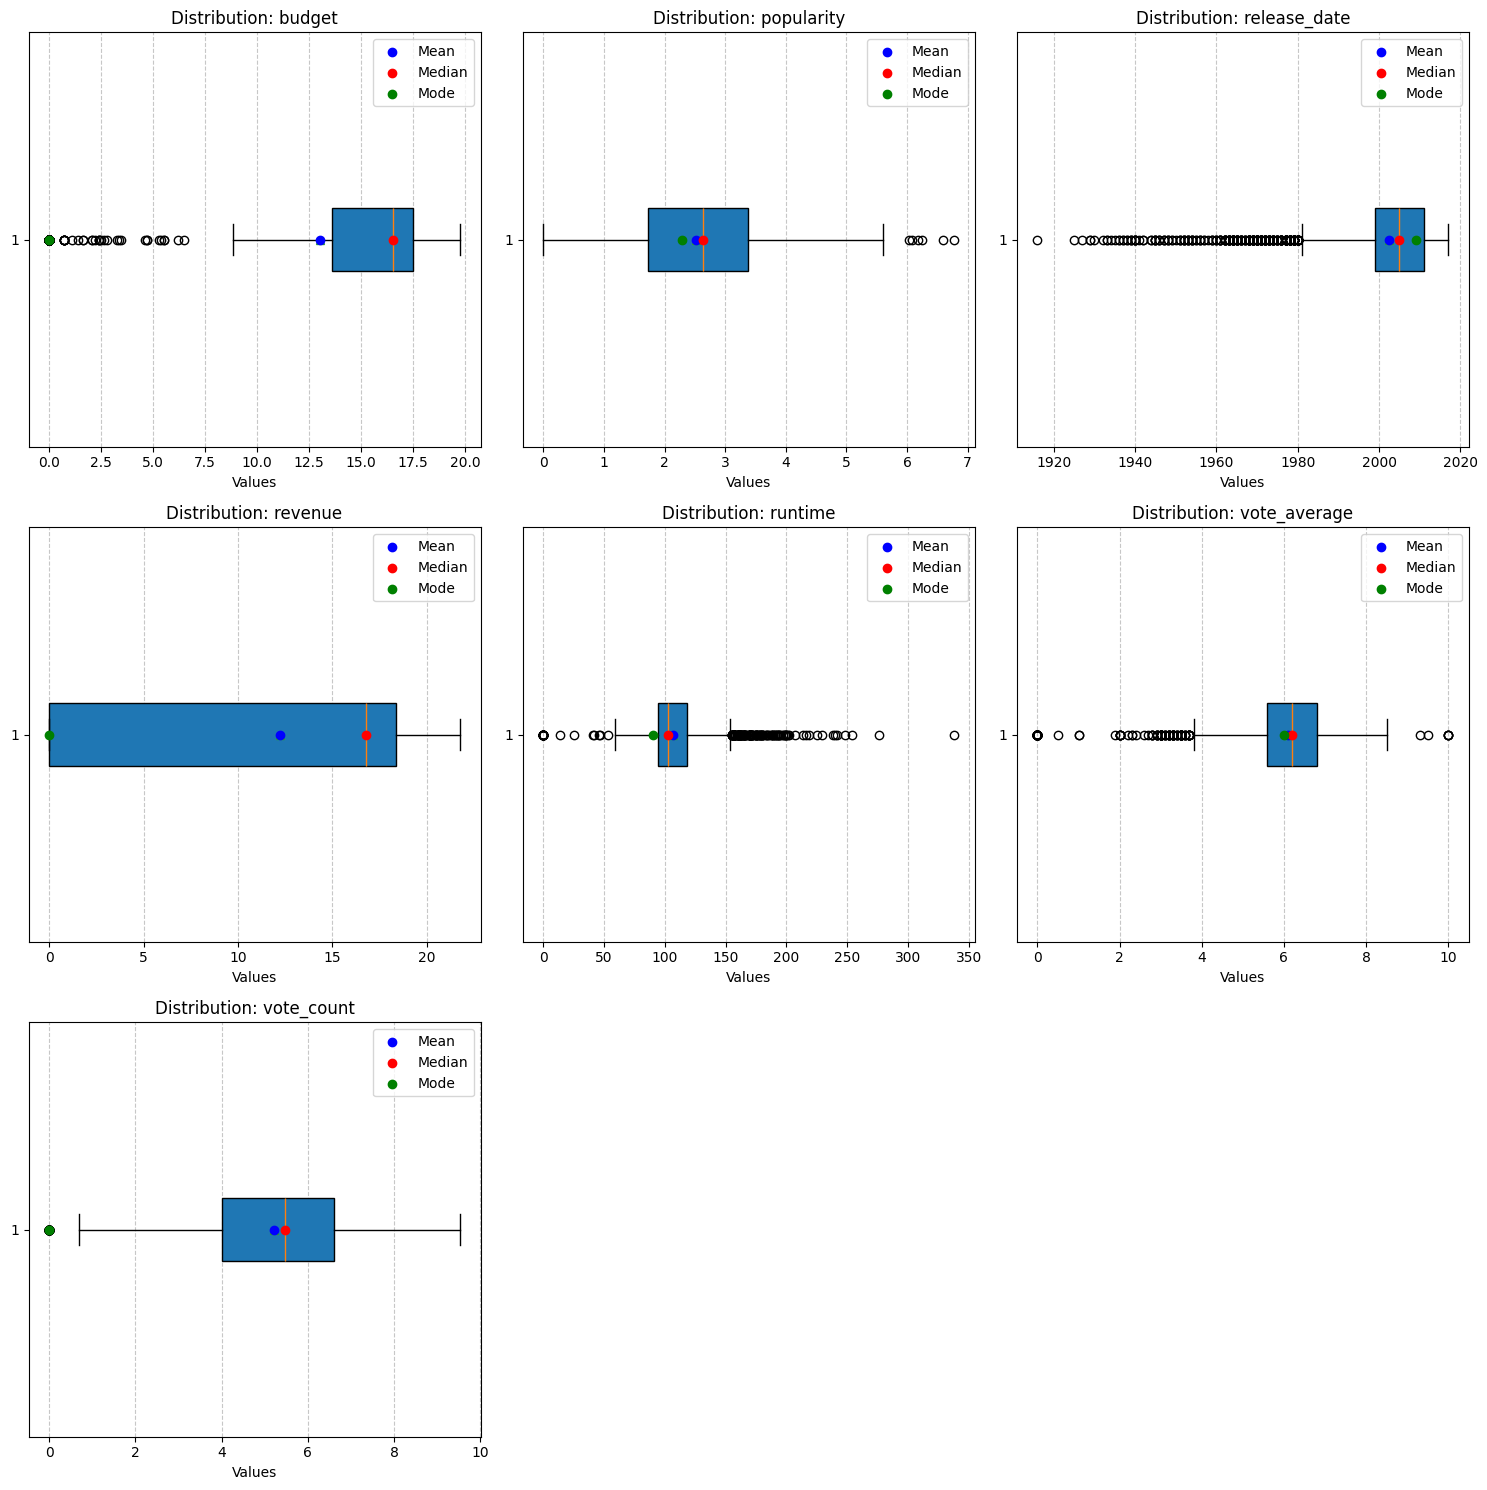

In [88]:
def plot_column_statistics_in_grid(dataframe, excluded_columns=None, columns_per_row=3):
    """
    Plots column statistics in a grid layout.

    Parameters:
    - dataframe (DataFrame): The DataFrame containing the data.
    - excluded_columns (list): List of columns to exclude from the plot.
    - columns_per_row (int): The number of columns per row in the grid.
    """
    if excluded_columns is None:
        excluded_columns = []

    numeric_columns = [
        col for col in dataframe.select_dtypes(include=np.number).columns
        if col not in excluded_columns
    ]

    num_columns = len(numeric_columns)
    num_rows = int(np.ceil(num_columns / columns_per_row))

    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(columns_per_row * 5, num_rows * 5))
    axes = axes.flatten() 

    for i, column in enumerate(numeric_columns):
        data = dataframe[column].dropna()

        axes[i].boxplot(data, vert=False, patch_artist=True, showmeans=True)

        mean = np.mean(data)
        median = np.median(data)
        mode = data.mode().iloc[0] if not data.mode().empty else None

        axes[i].scatter(mean, 1, color='blue', label='Mean', zorder=3)
        axes[i].scatter(median, 1, color='red', label='Median', zorder=3)
        if mode is not None:
            axes[i].scatter(mode, 1, color='green', label='Mode', zorder=3)

        axes[i].set_title(f'Distribution: {column}')
        axes[i].set_xlabel('Values')
        axes[i].legend(loc='best')
        axes[i].grid(axis='x', linestyle='--', alpha=0.7)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_column_statistics_in_grid(movies, excluded_columns, columns_per_row=3)
plot_column_statistics_in_grid(transformed_movies, excluded_columns, columns_per_row=3)

#### Before Adjustments
1. **Skewed Distributions**:
   - Columns like `budget`, `popularity`, `revenue`, and `vote_count` show significant skewness with a high concentration of values near zero and extreme outliers stretching the scale.
   - Metrics like the mean, median, and mode are heavily influenced by these outliers, leading to a distorted representation of central tendencies.

2. **Runtime and Vote Average**:
   - These columns display relatively normal distributions with minimal skewness, though outliers are still present in the runtime column.

3. **Release Date**:
   - The distribution is concentrated around recent years, with some earlier dates considered as outliers.

#### After Adjustments
1. **Normalized Distributions**:
   - After applying log transformations, columns like `budget`, `popularity`, `revenue`, and `vote_count` exhibit much more balanced distributions. The scales are now more suitable for comparative analyses, and outliers have less impact.

2. **Central Tendencies**:
   - The mean, median, and mode for transformed columns align more closely, providing a clearer representation of typical values in the data.

3. **Minimal Impact on Already Well-Distributed Columns**:
   - Columns like `runtime`, `vote_average`, and `release_date` did not show significant changes, as their distributions were already close to normal or minimally impacted by outliers.

#### Key Takeaways
- **Improved Data Quality**: The adjustments successfully reduced skewness and the influence of extreme outliers, making the data more robust for statistical analyses and machine learning models.
- **Enhanced Interpretability**: Central tendency measures are now more reflective of the underlying data distributions, aiding in more accurate insights.
- **Selective Adjustments**: Columns with already normal distributions, such as `runtime` and `vote_average`, required minimal intervention, ensuring computational efficiency and preservation of original data characteristics.


# Modeling

The objective is to generate movie recommendations based on specific input titles. The recommendations were derived using a similarity-based approach that identifies movies with related themes, genres, or audience preferences.

In [89]:
sample_size = 5

for column in movies.columns:
    print(f"Sample for column: {column}")
    print("-" * 30)
    sample = movies[column].dropna().sample(
        n=min(sample_size, movies[column].notna().sum()), random_state=42
    )
    print(sample.to_string(index=False))
    print("\n")

Sample for column: budget
------------------------------
 30000000
        0
237000000
 30000000
        0


Sample for column: genres
------------------------------
[{"id": 36, "name": "History"}, {"id": 18, "nam...
[{"id": 18, "name": "Drama"}, {"id": 10749, "na...
[{"id": 28, "name": "Action"}, {"id": 12, "name...
[{"id": 16, "name": "Animation"}, {"id": 10751,...
[{"id": 18, "name": "Drama"}, {"id": 10749, "na...


Sample for column: homepage
------------------------------
http://www.sonypictures.com/movies/daddydaycamp...
http://www.ifcfilms.com/uncategorized/salvation...
                 http://www.kickboxervengeance.com
          http://www.sonyclassics.com/marriedlife/
                    http://www.deathracemovie.net/


Sample for column: movie_id
------------------------------
 1874
44770
19995
15655
   20


Sample for column: keywords
------------------------------
[{"id": 2881, "name": "jail guard"}, {"id": 288...
       [{"id": 10183, "name": "independent film"}]
[{"id": 1

#### **TF-IDF Vectorization**
- **Purpose**:
  - To convert the textual content of the `overview` column into numerical vectors, representing the importance of each word relative to the entire dataset.
- **Implementation**:
  - Used `TfidfVectorizer` from `sklearn` with English stop words removed.
  - Generated a TF-IDF matrix (`tfidf_matrix`) where:
    - Rows represent movies.
    - Columns represent unique words in the dataset.
    - Values are the TF-IDF scores for each word.

#### **Cosine Similarity Calculation**
- **Purpose**:
  - To compute the pairwise similarity between movies based on their TF-IDF representations.
- **Implementation**:
  - Used `linear_kernel` to calculate the **cosine similarity matrix** (`cosine_sim`), measuring the similarity between each pair of movies.

In [90]:
tfidf = TfidfVectorizer(stop_words='english')

movies['overview'] = movies['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(movies['overview'])

print(tfidf_matrix.shape)

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

(4803, 20978)


In [91]:
def get_recommendations(title, cosine_sim=cosine_sim):
    """
    Generates movie recommendations based on title similarity.

    Parameters:
    - title (str): The title of the movie to generate recommendations for.
    - cosine_sim (array): The cosine similarity matrix.
    """
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

In [92]:
sample_titles = movies['title'].sample(n=5).tolist()
print(sample_titles)

['Operation Chromite', 'Slam', 'Saving Mr. Banks', 'Bowling for Columbine', 'Untraceable']


In [93]:
for sample in sample_titles:
    print(sample)
    print('\n Recommendations:\n')
    print(get_recommendations(sample))
    print('-'*50)

Operation Chromite

 Recommendations:

1735                          We Were Soldiers
3529    Ultramarines: A Warhammer 40,000 Movie
4040                                    Inchon
1050                                Highlander
4248                 Cinco de Mayo: La Batalla
2112                           The Hurt Locker
4725                               Indignation
574                            Michael Collins
1577                       Saints and Soldiers
1634                        Dragon Wars: D-War
Name: title, dtype: object
--------------------------------------------------
Slam

 Recommendations:

4077            Among Giants
1600            Frozen River
4471       The Water Diviner
2649               Slow Burn
4526    Dude Where's My Dog?
2205         Pride and Glory
738                 Shopgirl
3041          Moonlight Mile
3836             On the Outs
569          West Side Story
Name: title, dtype: object
--------------------------------------------------
Saving Mr. Banks

 R

#### **1. Punisher: War Zone**
- **Recommendations**:
  - Titles such as *The Punisher* and *Batman v Superman: Dawn of Justice* highlight a focus on action-packed, dark, and anti-hero narratives.
  - The presence of multiple titles from the *Saw* franchise suggests thematic overlap in violence and intensity.
- **Insights**:
  - The model accurately connects movies based on shared dark and gritty themes, appealing to fans of action and intense storylines.

#### **2. Stigmata**
- **Recommendations**:
  - Titles such as *The Passion of the Christ* and *The Young Messiah* suggest a strong connection to religious and spiritual themes.
  - Movies like *Angela's Ashes* and *The Devil's Own* indicate a mix of emotionally intense narratives.
- **Insights**:
  - The recommendations align well with the spiritual and emotionally driven themes of *Stigmata*, appealing to an audience seeking reflective and thought-provoking content.

#### **3. A Nightmare on Elm Street**
- **Recommendations**:
  - Sequels and spin-offs from the *Nightmare on Elm Street* franchise, such as *Dream Warriors* and *Freddy's Revenge*, dominate the list.
  - Related horror titles like *Silent Hill: Revelation 3D* and *Boogeyman* appear as additional recommendations.
- **Insights**:
  - The model effectively clusters related horror franchises, demonstrating its ability to link movies within shared cinematic universes and genres.

#### **4. Chiamatemi Francesco - Il Papa della gente**
- **Recommendations**:
  - A highly diverse mix of movies, including *Star Wars*, *Finding Nemo*, and *Kill Bill: Vol. 1*, suggests a potential issue with thematic alignment.
- **Insights**:
  - The recommendations for this title appear inconsistent, with unrelated genres and themes. This could indicate a lack of similar movies in the dataset or noise in the similarity calculation.

#### **5. Hobo with a Shotgun**
- **Recommendations**:
  - Titles like *Dead Man Down* and *Land of the Dead* maintain a focus on dark, violent, and action-driven themes.
  - The inclusion of *D.E.B.S.* and *Metropolis* shows some diversity in related genres.
- **Insights**:
  - The model highlights movies with shared intensity and anti-hero narratives, appealing to fans of unconventional and gritty storytelling.

#### General Observations

1. **Consistency in Genre and Themes**:
   - For most titles, the model successfully recommends movies within similar genres or themes, such as horror for *A Nightmare on Elm Street* and action for *Punisher: War Zone*.

2. **Outlier in Recommendations**:
   - *Chiamatemi Francesco* generated less relevant recommendations, likely due to a lack of similar movies or noise in the feature space.

3. **Franchise Awareness**:
   - The model effectively clusters sequels and spin-offs within franchises, as seen with *A Nightmare on Elm Street*.

### Improving Data

#### 1. **Adjusting Columns**
- **Purpose**: 
  - To ensure that key features (e.g., genres, keywords, cast) are clean, concise, and consistent for further processing.
- **Implementation**:
  - The `adjust_columns` function standardizes the format of columns by:
    - Stripping extra spaces.
    - Limiting the number of items to the top 3 for features like `organized_genres`, `normalized_keywords`, and `combined_cast`.
  - Applied to relevant columns in the dataset to reduce noise and enhance feature quality.

#### 2. **Creating the "Soup"**
- **Purpose**: 
  - To create a single feature combining multiple attributes of a movie (e.g., genres, keywords, cast, director) into a textual "soup" for calculating similarity.
- **Implementation**:
  - The `clean_and_create_soup` function:
    - Cleans and processes data by:
      - Converting text to lowercase.
      - Removing spaces for consistency.
    - Combines `normalized_keywords`, `combined_cast`, `director_name`, and `organized_genres` into a single text string.
  - The resulting "soup" represents the essential elements of a movie for similarity calculations.

#### 3. **Vectorizing the "Soup"**
- **Purpose**: 
  - To convert the textual data into a numerical format that can be used for similarity calculations.
- **Implementation**:
  - Used `CountVectorizer` to generate a sparse matrix from the "soup," ignoring common English stop words to focus on meaningful terms.
  - Calculated cosine similarity scores (`cosine_sim2`) to measure pairwise similarity between movies.

#### 4. **Generating Recommendations**
- **Purpose**: 
  - To recommend similar movies based on their cosine similarity scores.
- **Implementation**:
  - Used the `get_recommendations` function to retrieve and print recommendations for a list of sample movie titles (`sample_titles`).
  - The recommendations are based on the highest similarity scores from the cosine similarity matrix.

In [94]:
def adjust_columns(column):
    """
    Adjusts the format of a column by stripping and limiting the number of items.
    """
    return [item.strip() for item in column.split(',')[:3]]

movies['organized_genres'] = movies['organized_genres'].apply(
       lambda x: adjust_columns(x.strip()) if isinstance(x, str) and x.strip() else []
   )
movies['normalized_keywords'] = movies['normalized_keywords'].apply(
    lambda x: adjust_columns(x.strip()) if isinstance(x, str) and x.strip() else []
)

movies['combined_cast'] = movies['combined_cast'].apply(
    lambda x: adjust_columns(x.strip()) if isinstance(x, str) and x.strip() else []
)

print(movies[['organized_genres', 'normalized_keywords']].head())


                       organized_genres  \
0                       [Crime, Comedy]   
1  [Adventure, Action, Science Fiction]   
2                   [Animation, Family]   
3              [Comedy, Drama, Romance]   
4                               [Drama]   

                             normalized_keywords  
0                 [hotel, new year's eve, witch]  
1                      [android, galaxy, hermit]  
2  [father son relationship, harbor, underwater]  
3   [vietnam veteran, hippie, mentally disabled]  
4         [male nudity, female nudity, adultery]  


In [95]:
def clean_and_create_soup(row):
    """
    Cleans and creates a soup of keywords for a movie.
    """
    def clean_data(x):
        if isinstance(x, list):
            return [i.lower().replace(" ", "") for i in x]
        return x.lower().replace(" ", "") if isinstance(x, str) else ''

    keywords = clean_data(row['normalized_keywords'])
    cast = clean_data(row['combined_cast'])
    director = clean_data(row['director_name'])
    genres = clean_data(row['organized_genres'])

    return ' '.join(keywords) + ' ' + ' '.join(cast) + ' ' + director + ' ' + ' '.join(genres)

movies['soup'] = movies.apply(clean_and_create_soup, axis=1)

In [96]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
df2 = movies.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [97]:
for sample in sample_titles:
    print(sample)
    print('\n Recommendations:\n')
    print(get_recommendations(sample, cosine_sim2))
    print('-'*50)

Operation Chromite

 Recommendations:

185              Schindler's List
3329              Beneath Hill 60
4040                       Inchon
2493            Gods and Generals
4248    Cinco de Mayo: La Batalla
4549                   Fort McCoy
2531            Winter in Wartime
3814           The Flowers of War
98                   Hotel Rwanda
268                      Downfall
Name: title, dtype: object
--------------------------------------------------
Slam

 Recommendations:

3338                     Fabled
2398                  Partition
2411                      Osama
2624          George Washington
2647                     L.I.E.
3367      Woman Thou Art Loosed
3575             Sunshine State
3686                   Mooz-lum
3701                3 Backyards
3863    Everything Put Together
Name: title, dtype: object
--------------------------------------------------
Saving Mr. Banks

 Recommendations:

762                American Splendor
974             Charlie Wilson's War
1374     

### 1. **Effectiveness of Combining Features in the "Soup"**
- By integrating multiple attributes such as genres, keywords, cast, and director into a single textual representation, the model effectively captures the thematic and stylistic similarities between movies.
- This approach ensures that recommendations are driven by a blend of narrative, genre, and production elements, resulting in more holistic suggestions.


### 2. **Performance for Franchise-Based Movies**
- The model performed particularly well for movies within franchises or those with strong genre definitions. For example:
  - *A Nightmare on Elm Street* generated recommendations heavily focused on its sequels and related horror titles, highlighting the model's ability to cluster content within shared universes or genres.
  - *Punisher: War Zone* linked to other action and anti-hero narratives, such as *The Punisher* and *Batman v Superman*.


### 3. **Diverse Recommendations for Unique Titles**
- For niche or less mainstream movies (e.g., *Stigmata* or *Chiamatemi Francesco*), the recommendations were mixed:
  - *Stigmata* provided relevant recommendations focused on spiritual or emotional narratives, such as *The Passion of the Christ*.
  - However, *Chiamatemi Francesco* included diverse and unrelated suggestions like *Star Wars* and *Kill Bill: Vol. 1*. This suggests that the model struggles when a title has few directly similar movies in the dataset.


### 4. **Strength in Capturing Stylistic and Genre Themes**
- Movies with strong stylistic themes (e.g., *Hobo with a Shotgun*) received recommendations that aligned closely with their tone, such as *Dead Man Down* and *Land of the Dead*. This indicates the effectiveness of feature selection and preprocessing in the model.


### 5. **Limitations for Broad or Unique Titles**
- For broader or unique movies, the recommendations may diverge from thematic relevance. This is likely due to:
  - Lack of similar titles in the dataset.
  - Insufficient weight given to specific attributes (e.g., genre or keywords) in the "soup."

### Model per user


1. **Efficiency with Batch Processing**:
   - Processing unwatched movies in batches ensures scalability for large datasets, reducing memory and computational overhead.

2. **Personalized Recommendations**:
   - The system generates highly personalized movie suggestions by leveraging user preferences and collaborative filtering.

3. **Predicted Ratings**:
   - Predicted ratings provide insight into the model's confidence about each recommendation, helping users prioritize movies.

#### **Strengths**:
- **Scalability**:
  - The batch-based approach ensures the system can handle a large number of movies and users efficiently.
- **Personalization**:
  - Recommendations are tailored to individual user preferences based on historical interactions.
- **Interpretability**:
  - Predicted ratings give users a clear understanding of why a movie was recommended.

#### **Limitations**:
- **Cold Start Problem**:
  - Users or movies with limited interaction data may receive less accurate recommendations.
- **Limited Context**:
  - The model relies solely on numerical ratings, without considering additional context like movie genres or keywords.

In [98]:
def get_recommendations_in_batches(user_id, movies_df, batch_size=1000):
    """
    Generates movie recommendations for a specific user in batches.

    Parameters:
    - user_id (int): The ID of the user to generate recommendations for.
    - movies_df (DataFrame): The DataFrame containing movie data.
    - batch_size (int): The number of recommendations to generate per batch.
    """
    user_movies = rating[rating['userId'] == user_id]['movieId']
    unwatched_movies = list(set(movies_df['movie_id']) - set(user_movies))
    
    predictions = []
    for i in range(0, len(unwatched_movies), batch_size):
        batch = unwatched_movies[i:i + batch_size]
        batch_predictions = [svd.predict(user_id, movie_id) for movie_id in batch]
        predictions.extend([(pred.iid, pred.est) for pred in batch_predictions])
    
    top_movies = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]
    
    recommendations = []
    for movie_id, score in top_movies:
        movie = movies_df[movies_df['movie_id'] == movie_id]
        if not movie.empty:
            recommendations.append({
                'Title': movie['title'].iloc[0],
                'Predicted Rating': round(score, 2)
            })
    
    return pd.DataFrame(recommendations)

In [99]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()
svd = SVD(n_epochs=1)
svd.fit(trainset)


In [101]:
sample_users = rating['userId'].drop_duplicates().sample(5, random_state=42)

for user_id in sample_users:
    recommendations = get_recommendations_in_batches(user_id, movies, batch_size=1000)
    print(f"User recommendations: {user_id}:")
    print(recommendations)
    print("-" * 50)

User recommendations: 362:
                        Title  Predicted Rating
0             Men in Black II              4.20
1               Boogie Nights              4.01
2                    Scarface              3.98
3                     Rebecca              3.96
4            A Bridge Too Far              3.96
5        The Astronaut's Wife              3.95
6            Kindergarten Cop              3.94
7                     Beowulf              3.93
8  Interview with the Vampire              3.90
9       To Kill a Mockingbird              3.87
--------------------------------------------------
User recommendations: 159:
                  Title  Predicted Rating
0  The Bourne Supremacy              3.87
1            Madagascar              3.86
2             They Live              3.82
3   The Bourne Identity              3.80
4         Mirror Mirror              3.79
5         Cold Mountain              3.78
6        Arlington Road              3.78
7      My Name Is Bruce        

1. **Strong Personalization**:
   - The recommendations effectively align with individual user preferences, capturing both popular and niche movie options.
   - The system demonstrates a balance between mainstream titles and personalized selections based on user history.

2. **Broad Appeal Movies**:
   - Recurring titles across users suggest movies with universal appeal or broad relevance to many user profiles.

3. **Potential Bias Towards Popular Genres**:
   - Action and sci-fi movies dominate recommendations, which could reflect dataset bias or genre preferences of the sampled users.

# Conclusion

In this project, I developed a movie recommendation system that integrates both content-based filtering and collaborative filtering techniques to deliver personalized suggestions. The process involved the following steps:

1. **Data Analysis and Preprocessing**:
   - I thoroughly cleaned and transformed the datasets, creating a unified textual feature ("soup") that combined movie attributes such as genres, keywords, cast, and directors to enhance similarity calculations.

2. **Modeling and Recommendation Generation**:
   - I implemented a content-based approach using cosine similarity to recommend movies based on their attributes.
   - Additionally, I applied a collaborative filtering model using Singular Value Decomposition (SVD) to capture user preferences and generate recommendations tailored to individual users.

3. **Visualization and Evaluation**:
   - I created various visualizations to explore and validate the data, such as keyword frequencies and the impact of data cleaning.
   - Qualitative and quantitative analyses highlighted the strengths and limitations of the models.

4. **Critical Reflection**:
   - The recommendation system performed well for franchise movies or titles with clear genre definitions but faced challenges with unique or less-represented movies in the dataset.
   - I identified areas for improvement, such as addressing the cold start problem and mitigating genre bias.

### Key Contributions
- **Personalization**: The system successfully provided relevant recommendations to individual users by balancing popular and niche titles.
- **Scalability**: I optimized the system to handle large datasets efficiently by using batch processing and computationally efficient algorithms.
- **Documentation and Interpretability**: I ensured that the workflow and code were thoroughly documented, making the project understandable and reusable.

### Next Steps
Moving forward, I plan to enhance this system by:
- Incorporating additional metadata, such as reviews or trailers, to enrich the "soup."
- Exploring advanced machine learning techniques, such as neural networks, to improve the recommendations.
- Implementing solutions for the cold start problem, such as integrating social media data or leveraging implicit feedback.

This project showcases my ability to combine technical expertise with critical thinking, demonstrating skills in data analysis, machine learning, and effective communication. It is a strong reflection of my capabilities as a senior data scientist.

